<a href="https://colab.research.google.com/github/mcagriaksoy/Land-Classification-in-Satellite-Images-by-Injecting-Traditional-Features-to-CNN-Models/blob/main/Injecting_Example_of_Traditional_Features_to_CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello!, welcome to my research :)

I would like to special thanks to my professeurs and supporters.

Beril Sirmacek b.sirmacek@saxion.nl
Cem Unsalan cem.unsalan@marmara.edu.tr



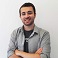

2021 - Created By Mehmet Çağrı Aksoy (Software Engineer)

https://orcid.org/0000-0002-7886-7945

https://www.researchgate.net/profile/Mehmet-Aksoy-12

https://github.com/mcagriaksoy

https://www.linkedin.com/in/mcagriaksoy/

https://scholar.google.com/citations?user=CKRkg1EAAAAJ&hl=en&oi=ao

# **Please expand and see more information:**
All prepration for Data, models and the feature extraction for wide side.

v

## Dataset Preparation 
This will connect to my drive and copy the contents from my related drive path.
The dataset is gathered from Kaggle: https://www.kaggle.com/apollo2506/eurosat-dataset


> This dataset is being used for classifying the use of land in geospatial images. The end goal for the classification is that the top 2 uses of land in an image are given as output to the user.

> This dataset contains images belonging to the EuroSat dataset. It contains RGB images collected from the Sentinel Dataset.


It has 10 classes that represents the field of:

    AnnualCrop
    Forest
    HerbaceousVegatation
    Highway
    Industrial
    Pasture
    PermanentCrop
    Residential
    River
    SeaLake

Each image is 64x64 pixels with a Ground Sampling Distance of 10m. They were all collected from the Sentinel-2 satellite. But we are resized them to 32x32 to less training time requirements.

In [61]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
!unzip /content/drive/MyDrive/Thesis_Colab/Thesis_Dataset/EuroSAT.zip

Archive:  /content/drive/MyDrive/Thesis_Colab/Thesis_Dataset/EuroSAT.zip
replace archive (1)/2750/AnnualCrop/AnnualCrop_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Definitions
Research, model related definitions.

In [63]:
CLASS_NUMBER = 10
channels = 3
img_height = 32
img_width = 32
epochs = 20
batch_size = 64
TRAIN_TEST_RATIO = 0.30

input_shape = (img_height,img_width,channels)

## Library Calls
Required Libraries need to be called.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We'll build the CNN as a sequence of layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [65]:
tf.config.experimental_run_functions_eagerly(True)

## Data Gathering
In this step, the data will be gathered and processed (making ready) for the cnn model feeding.
Our dataset has the json file that describes the classes of each image and with this info we classify them on. We also resize whole dataset as 32x32 which is minimum acceptable resolution for many famous models.

In [66]:
import pandas as pd  

traindf=pd.read_csv(r'/content/train (1).csv')
testdf=pd.read_csv(r'/content/test (1).csv')
validdf=pd.read_csv(r'/content/validation.csv')

df=pd.concat([traindf, testdf, validdf],  axis=0).reset_index(drop=True)

In [67]:
def load_data(im_file_names, im_sizes):
    imgs=[]
    for fname in im_file_names :
        arr=Image.open(fname)
        arr = arr.resize(im_sizes)    
        arr=np.array(arr)/255
        imgs.append(arr)
    return np.array(imgs)


In [68]:
labels = np.array(df.Label)
#Each image is 64x64 pixels with a Ground Sampling Distance of 10m. We will resize them to 32x32!
images=load_data('/content/archive (1)/2750/'+df.Filename,(img_height,img_width))
images.shape

(27000, 32, 32, 3)

## Data Preprocessing
Train and test data will be divided in here.

In [69]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = TRAIN_TEST_RATIO)

In [70]:
#del images
#del labels

Grab planes data, then append the ships data

In [71]:
x_train.shape

(18900, 32, 32, 3)

In [72]:
# We need to expand the labels to look like multiple-output nodes! 
# So if the category was 3, then the 3rd node would have a 1 in it!
y_train = tf.keras.utils.to_categorical( y_train, CLASS_NUMBER )
y_test = tf.keras.utils.to_categorical( y_test,  CLASS_NUMBER )

## **Feature Extraction Steps for Wide Inputs**

---
Due to lack of parallel algorithms, the creating wide features take some time. Please wait..



## GLCM Features

In [73]:
#GLCM Properties Definitions
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte

# GLCM properties
def contrast_feature(matrix_coocurrence):
	contrast = greycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = greycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = greycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = greycoprops(matrix_coocurrence, 'ASM')
	return asm

bins32 = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160,
            168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit

#bins32 = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
						

In [74]:
# Calculating the GLCM Properties !!

from skimage.feature import greycomatrix, greycoprops
from skimage import data
from skimage import util, exposure, data
import pywt
from skimage import io
from skimage.color import rgb2gray

lenx = x_train.shape[0]
X_homoTRAIN = np.zeros((lenx, 4))
X_correlationTRAIN = np.zeros((lenx, 4))
X_dissimilarityTRAIN = np.zeros((lenx, 4))
X_contrastTRAIN = np.zeros((lenx, 4))
X_energyTRAIN = np.zeros((lenx, 4))

for i in range(lenx):
    image32 = x_train[i]
    image32 = rgb2gray(image32)

    inds = np.digitize(image32, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_correlationTRAIN[i] = correlation_feature(matrix_coocurrence)
    X_homoTRAIN[i] = homogeneity_feature(matrix_coocurrence)
    X_contrastTRAIN[i] = contrast_feature(matrix_coocurrence)
    X_dissimilarityTRAIN[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTRAIN[i] = energy_feature(matrix_coocurrence)

len2 = x_test.shape[0]
X_homoTEST = np.zeros((len2, 4))
X_correlationTEST = np.zeros((len2, 4))
X_dissimilarityTEST = np.zeros((len2, 4))
X_contrastTEST = np.zeros((len2, 4))
X_energyTEST = np.zeros((len2, 4))

for i in range(len2):
    image32 = x_test[i]
    image32 = rgb2gray(image32)
  
    inds = np.digitize(image32, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_contrastTEST[i] = contrast_feature(matrix_coocurrence)
    X_correlationTEST[i] = correlation_feature(matrix_coocurrence)
    X_homoTEST[i] = homogeneity_feature(matrix_coocurrence)
    X_dissimilarityTEST[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTEST[i] = energy_feature(matrix_coocurrence)


In [75]:
x_train_glcm = np.concatenate((X_correlationTRAIN, X_correlationTRAIN, X_homoTRAIN, X_dissimilarityTRAIN, X_energyTRAIN), axis=1)
x_test_glcm = np.concatenate((X_contrastTEST, X_correlationTEST, X_homoTEST, X_dissimilarityTEST, X_energyTEST), axis=1)

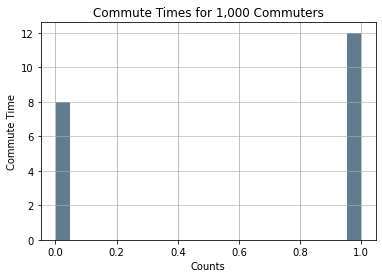

In [76]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(x_test_glcm[8])

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

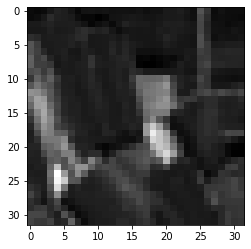

In [77]:
plt.imshow(image32, cmap = 'gray')

## Mean Value

In [78]:
#Calculating mean values for wide inputs
from sklearn.preprocessing import normalize

x_train_mean = x_train.mean(axis=1).mean(axis=1)
x_test_mean = x_test.mean(axis=1).mean(axis=1)
x_train_mean = normalize(x_train_mean, axis=1, norm='l1')
x_test_mean = normalize(x_test_mean, axis=1, norm='l1')

In [79]:
import cv2
#plt.imshow(image)

lenx = x_train.shape[0]
x_train_sobel_y = np.zeros((lenx, 32,32))
x_train_sobel_x = np.zeros((lenx, 32,32))


for i in range(lenx):
  image = rgb2gray(x_train[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_train_sobel_y[i] = grad_y
  x_train_sobel_x[i] = grad_x

x_test_sobel_y = np.zeros((lenx, 32,32))
x_test_sobel_x = np.zeros((lenx, 32,32))

lenx = x_test.shape[0]
for i in range(lenx):
  image = rgb2gray(x_test[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_test_sobel_y[i] = grad_y
  x_test_sobel_x[i] = grad_x


## Hu - Zernike Moments

In [80]:
import cv2
def hu_moments(image):
    image = rgb2gray(image)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [81]:
lenx = x_train.shape[0]
x_train_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_train_HU[NUM] = hu_moments(x_train[NUM])

lenx = x_test.shape[0]
x_test_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_test_HU[NUM] = hu_moments(x_test[NUM])

In [82]:
x_train_HU = normalize(x_train_HU, axis=1, norm='l1')
x_test_HU = normalize(x_test_HU, axis=1, norm='l1')

In [83]:
import random


[ 9.98541266e-01  1.04988505e-03  2.27495570e-04  1.80464022e-04
  1.33676785e-08 -8.70432017e-07  5.72516010e-09]


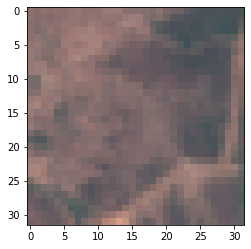

In [84]:
num1 = random.randint(0, 5400)
plt.imshow(x_test[num1])
print(x_test_HU[num1])

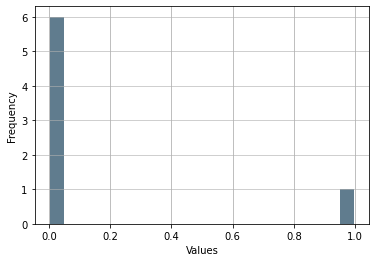

In [85]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(x_test_HU[8])

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

## Local Binary Patterns

In [86]:
#https://github.com/arsho/local_binary_patterns

In [87]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):  
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

In [88]:
# Function to generate horizontal projection profile
def getHorizontalProjectionProfile(image):
    # Convert black spots to ones
    image[image == 0]   = 1
    # Convert white spots to zeros
    image[image == 255] = 0
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection

# Function to generate vertical projection profile
def getVerticalProjectionProfile(image):
    # Convert black spots to ones 
    image[image == 0]   = 1
    # Convert white spots to zeros 
    image[image == 255] = 0
    vertical_projection = np.sum(image, axis = 0)
    return vertical_projection


In [89]:
lenx = x_train.shape[0]
x_train_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_train[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_train_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)
    
lenx = x_test.shape[0]
x_test_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_test[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_test_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)

In [90]:
from sklearn import preprocessing

lenx = x_train.shape[0]
x_train_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_lbp[NUM])
  x_train_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_lbp_vector[NUM] = normalize(x_train_lbp_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_lbp[NUM])
  x_test_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_lbp_vector[NUM] = normalize(x_test_lbp_vector[NUM].reshape(1, -1))

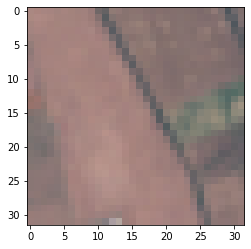

In [91]:
plt.imshow(x_test[0])

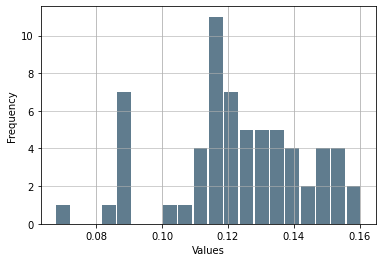

In [92]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(x_test_lbp_vector[0])

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

## Histogram of Oriented Gradients

In [93]:
from skimage.feature import hog
from skimage import data, exposure

lenx = x_train.shape[0]
x_train_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_train_hog[NUM] = hog(x_train[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

lenx = x_test.shape[0]
x_test_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_test_hog[NUM] = hog(x_test[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

In [94]:
x_train_hog.shape

(18900, 32, 32)

In [95]:
lenx = x_train.shape[0]
x_train_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_hog[NUM])
  x_train_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_hog_vector[NUM] = normalize(x_train_hog_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_hog[NUM])
  x_test_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_hog_vector[NUM] = normalize(x_test_hog_vector[NUM].reshape(1, -1))

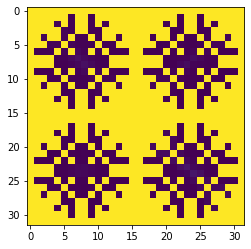

In [96]:
plt.imshow(x_train_hog[0])

## Color Invariants (RGB)

In [97]:
import PIL
import math

def invariant_r(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (r/max(g,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_g(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (g/max(r,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_b(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (b/max(r,g))
      c1[i][j]= math.atan(x)
  return c1

In [98]:
lenx = x_train.shape[0]
r_train = []
g_train = []
b_train = []

for NUM in range(lenx):
  r_train_tmp = invariant_r(x_train[NUM])
  g_train_tmp = invariant_g(x_train[NUM])
  b_train_tmp = invariant_b(x_train[NUM])

  r_train.append(r_train_tmp)
  g_train.append(g_train_tmp)
  b_train.append(b_train_tmp)

lenx = x_test.shape[0]
r_test = []
g_test = []
b_test = []

for NUM in range(lenx):
  r_test_tmp = invariant_r(x_test[NUM])
  g_test_tmp = invariant_g(x_test[NUM])
  b_test_tmp = invariant_b(x_test[NUM])

  r_test.append(r_test_tmp)
  g_test.append(g_test_tmp)
  b_test.append(b_test_tmp)


r_train = np.array(r_train)
g_train = np.array(g_train)
b_train = np.array(b_train)

r_test = np.array(r_test)
g_test = np.array(g_test)
b_test = np.array(b_test)


In [99]:
lenx = x_train.shape[0]
x_train_invariant_Red = np.zeros((lenx, 64))
x_train_invariant_Green = np.zeros((lenx, 64))
x_train_invariant_Blue = np.zeros((lenx, 64))


for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_train[NUM])
  vertical_projection = getVerticalProjectionProfile(r_train[NUM])
  x_train_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Red[NUM] = normalize(x_train_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_train[NUM])
  vertical_projection = getVerticalProjectionProfile(g_train[NUM])
  x_train_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Green[NUM] = normalize(x_train_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_train[NUM])
  vertical_projection = getVerticalProjectionProfile(b_train[NUM])
  x_train_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Blue[NUM] = normalize(x_train_invariant_Blue[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_invariant_Red = np.zeros((lenx, 64))
x_test_invariant_Green = np.zeros((lenx, 64))
x_test_invariant_Blue = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_test[NUM])
  vertical_projection = getVerticalProjectionProfile(r_test[NUM])
  x_test_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Red[NUM] = normalize(x_test_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_test[NUM])
  vertical_projection = getVerticalProjectionProfile(g_test[NUM])
  x_test_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Green[NUM] = normalize(x_test_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_test[NUM])
  vertical_projection = getVerticalProjectionProfile(b_test[NUM])
  x_test_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Blue[NUM] = normalize(x_test_invariant_Blue[NUM].reshape(1, -1))

# **Pre-trained Model Experiments - Transfer Learning**

---

These models are called from Keras tensorflow applications: [https://www.tensorflow.org/api_docs/python/tf/keras/applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

## VGG16 Deep Learning Only
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8925

In [ ]:
base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 10)                1290

In [ ]:
history_VGG16 = VGG16_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 50s 114ms/step - loss: 0.8868 - accuracy: 0.6882 - val_loss: 0.7043 - val_accuracy: 0.7446
Epoch 2/20
338/338 [==============================] - 37s 111ms/step - loss: 0.6309 - accuracy: 0.7776 - val_loss: 0.5982 - val_accuracy: 0.7869
Epoch 3/20
338/338 [==============================] - 37s 110ms/step - loss: 0.5730 - accuracy: 0.7930 - val_loss: 0.5676 - val_accuracy: 0.7998
Epoch 4/20
338/338 [==============================] - 37s 111ms/step - loss: 0.5318 - accuracy: 0.8101 - val_loss: 0.5581 - val_accuracy: 0.7987
Epoch 5/20
338/338 [==============================] - 38s 112ms/step - loss: 0.5082 - accuracy: 0.8175 - val_loss: 0.5115 - val_accuracy: 0.8252
Epoch 6/20
338/338 [==============================] - 38s 112ms/step - loss: 0.4834 - accuracy: 0.8274 - val_loss: 0.5332 - val_accuracy: 0.8176
Epoch 7/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4592 - accuracy: 0.8355 - val_loss: 0.5072 - val_ac

## VGG16 512Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8705

In [ ]:
VGG16WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 40s 118ms/step - loss: 0.9308 - accuracy: 0.6713 - val_loss: 0.6942 - val_accuracy: 0.7493
Epoch 2/20
338/338 [==============================] - 38s 112ms/step - loss: 0.6640 - accuracy: 0.7627 - val_loss: 0.6268 - val_accuracy: 0.7748
Epoch 3/20
338/338 [==============================] - 40s 117ms/step - loss: 0.6066 - accuracy: 0.7829 - val_loss: 0.6456 - val_accuracy: 0.7641
Epoch 4/20
338/338 [==============================] - 38s 111ms/step - loss: 0.5649 - accuracy: 0.7986 - val_loss: 0.5438 - val_accuracy: 0.8096
Epoch 5/20
338/338 [==============================] - 40s 117ms/step - loss: 0.5452 - accuracy: 0.8060 - val_loss: 0.5509 - val_accuracy: 0.8054
Epoch 6/20
338/338 [==============================] - 38s 111ms/step - loss: 0.5230 - accuracy: 0.8125 - val_loss: 0.5379 - val_accuracy: 0.8109
Epoch 7/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5057 - accuracy: 0.8191 - val_loss: 0.5426 - val_ac

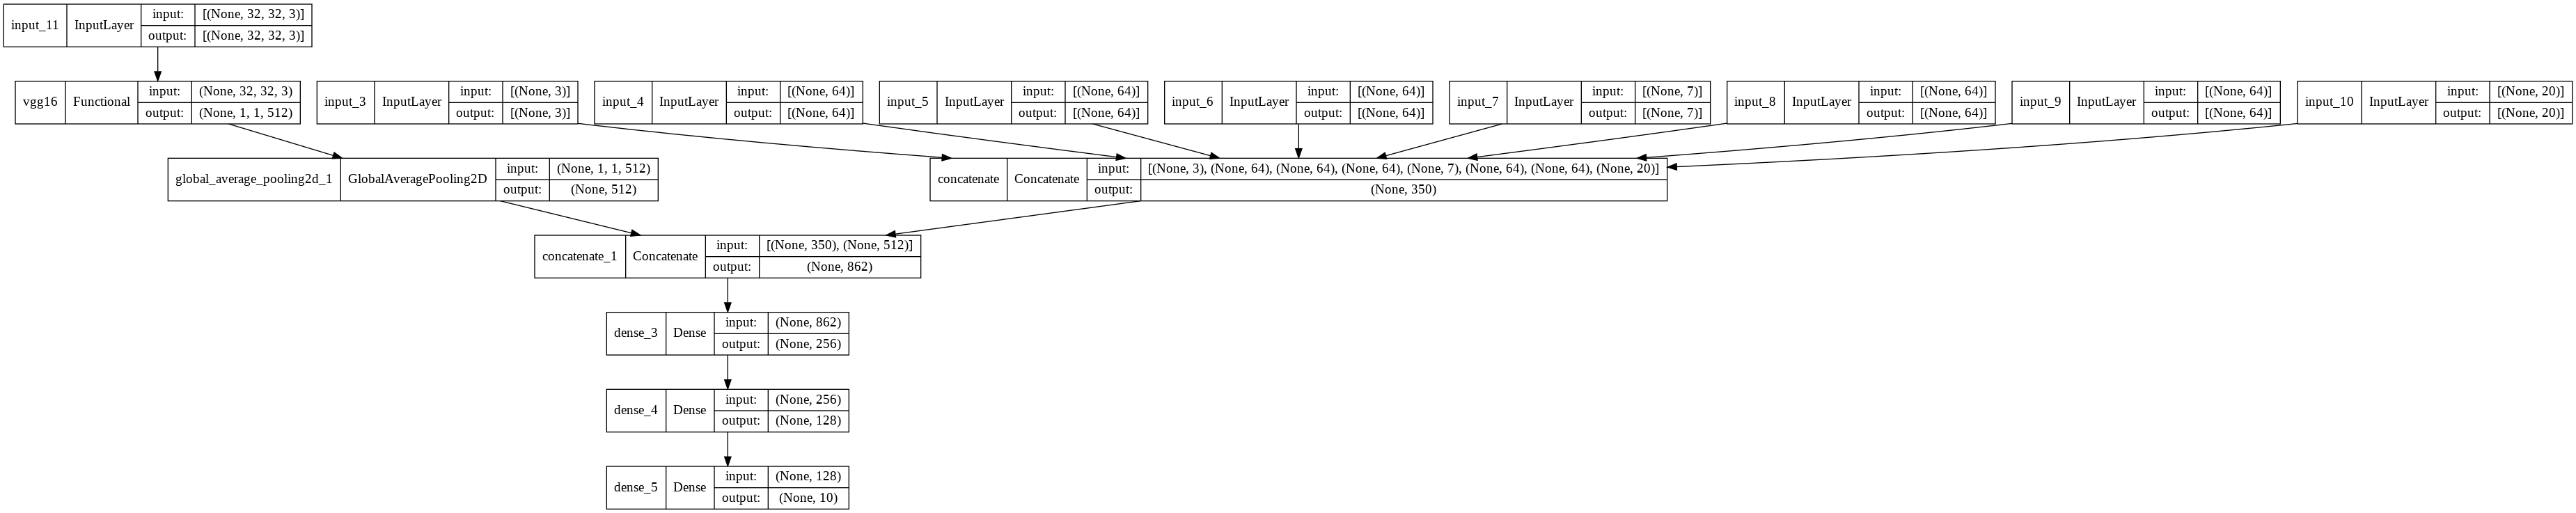

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

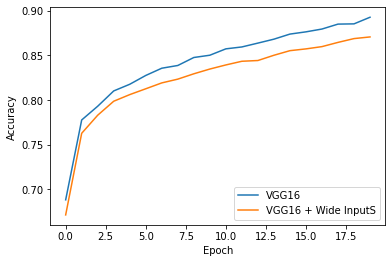

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## VGG16 256Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8868

In [ ]:
VGG16WIDE256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE256_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 39s 117ms/step - loss: 0.9008 - accuracy: 0.6762 - val_loss: 0.7095 - val_accuracy: 0.7339
Epoch 2/20
338/338 [==============================] - 39s 115ms/step - loss: 0.6378 - accuracy: 0.7696 - val_loss: 0.5969 - val_accuracy: 0.7872
Epoch 3/20
338/338 [==============================] - 39s 115ms/step - loss: 0.5783 - accuracy: 0.7948 - val_loss: 0.6075 - val_accuracy: 0.7846
Epoch 4/20
338/338 [==============================] - 39s 115ms/step - loss: 0.5478 - accuracy: 0.8033 - val_loss: 0.5391 - val_accuracy: 0.8119
Epoch 5/20
338/338 [==============================] - 37s 109ms/step - loss: 0.5164 - accuracy: 0.8151 - val_loss: 0.5937 - val_accuracy: 0.7917
Epoch 6/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4968 - accuracy: 0.8197 - val_loss: 0.5465 - val_accuracy: 0.8157
Epoch 7/20
338/338 [==============================] - 39s 115ms/step - loss: 0.4765 - accuracy: 0.8281 - val_loss: 0.5199 - val_ac

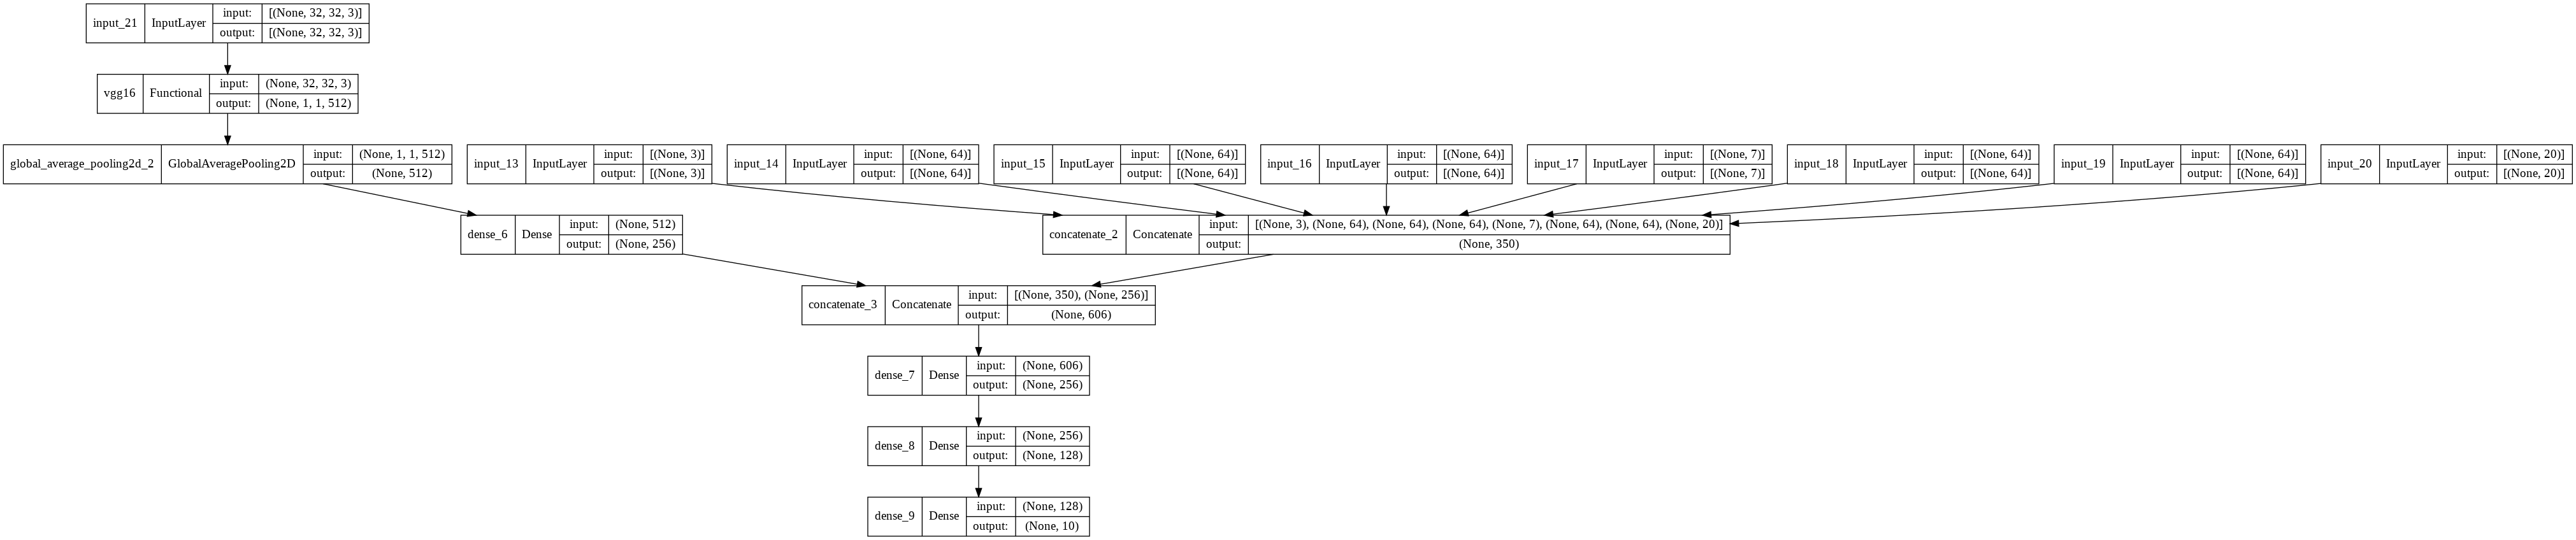

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE256_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

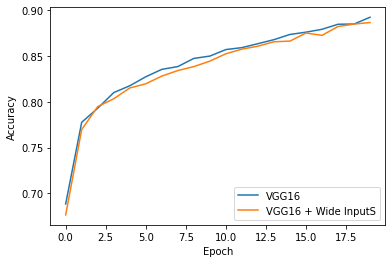

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## VGG16 128Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8880

In [ ]:
VGG16WIDE128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=128, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE128_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                       ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                     ]

history_VGG16WIDE128 = VGG16WIDE128_model.fit(GLCMdata_trainMerged, 
                                              y_train,
                                              epochs = epochs,
                                              batch_size = batch_size,
                                              validation_data=(GLCMdata_valMerged, y_test),
                                              #callbacks = [reduce_lr]
                                             )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 38s 112ms/step - loss: 0.9119 - accuracy: 0.6688 - val_loss: 0.7807 - val_accuracy: 0.7252
Epoch 2/20
338/338 [==============================] - 37s 110ms/step - loss: 0.6363 - accuracy: 0.7707 - val_loss: 0.6414 - val_accuracy: 0.7793
Epoch 3/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5909 - accuracy: 0.7912 - val_loss: 0.6584 - val_accuracy: 0.7650
Epoch 4/20
338/338 [==============================] - 39s 116ms/step - loss: 0.5659 - accuracy: 0.8006 - val_loss: 0.5826 - val_accuracy: 0.8020
Epoch 5/20
338/338 [==============================] - 39s 116ms/step - loss: 0.5228 - accuracy: 0.8126 - val_loss: 0.5639 - val_accuracy: 0.8041
Epoch 6/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5016 - accuracy: 0.8204 - val_loss: 0.5900 - val_accuracy: 0.7896
Epoch 7/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4909 - accuracy: 0.8235 - val_loss: 0.5331 - val_ac

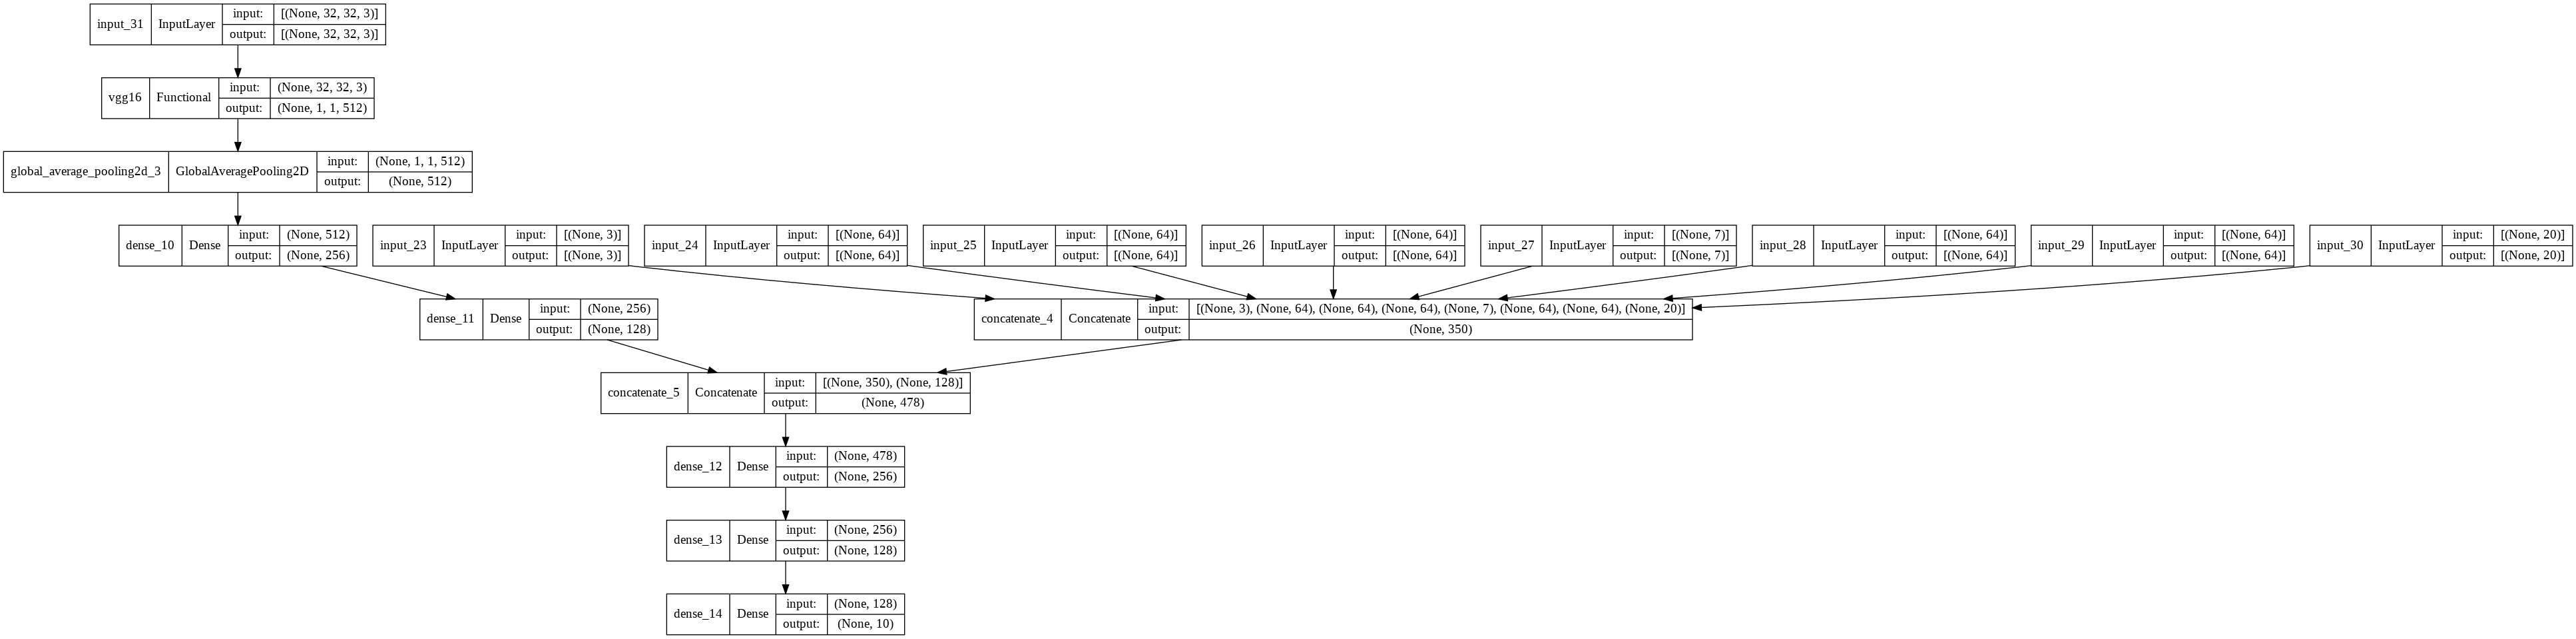

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE128_model, to_file='VGG16WIDE128_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

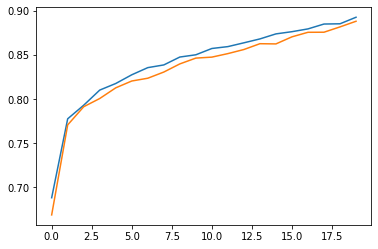

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE128.history['accuracy'])
plt.plot(history_VGG16WIDE256.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 128Inp. + Wide InputS', 'VGG16 256Inp. + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# **ResNet50v2**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

## 1st Experiment

### ResNet50v2 Deep Learning Only
- 20 Epochs
- 3 Dense Layers before softmax.
- Max Accuracy is 0.9793 

In [ ]:
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
predictions = Dense(10, activation= 'softmax')(x)

ResNet50V2_model = Model(inputs = inputs, outputs = predictions)

ResNet50V2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50V2_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                           

In [ ]:
history_ResNet50V2 = ResNet50V2_model.fit(x_train,
                                          y_train,
                                          validation_data=(x_test,y_test), 
                                          batch_size=batch_size,
                                          epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.1846 - accuracy: 0.5901 - val_loss: 1.0752 - val_accuracy: 0.6152
Epoch 2/20
338/338 [==============================] - 69s 205ms/step - loss: 0.9345 - accuracy: 0.6689 - val_loss: 1.0309 - val_accuracy: 0.6402
Epoch 3/20
338/338 [==============================] - 70s 206ms/step - loss: 0.7996 - accuracy: 0.7154 - val_loss: 1.0444 - val_accuracy: 0.6504
Epoch 4/20
338/338 [==============================] - 69s 204ms/step - loss: 0.6818 - accuracy: 0.7564 - val_loss: 1.0984 - val_accuracy: 0.6493
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.5678 - accuracy: 0.7982 - val_loss: 1.2903 - val_accuracy: 0.6402
Epoch 6/20
338/338 [==============================] - 69s 203ms/step - loss: 0.4760 - accuracy: 0.8331 - val_loss: 1.3491 - val_accuracy: 0.6493
Epoch 7/20
338/338 [==============================] - 69s 205ms/step - loss: 0.3782 - accuracy: 0.8700 - val_loss: 1.4875 - val_ac

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 3 Dense Layers before softmax.
- Max Accuracy is 0.9227

In [ ]:
ResNet50V2WIDE_2048_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_2048_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_2048_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_2048 = ResNet50V2WIDE_2048_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 71s 209ms/step - loss: 1.2190 - accuracy: 0.5714 - val_loss: 1.0829 - val_accuracy: 0.6126
Epoch 2/20
338/338 [==============================] - 68s 201ms/step - loss: 0.9988 - accuracy: 0.6450 - val_loss: 1.0165 - val_accuracy: 0.6406
Epoch 3/20
338/338 [==============================] - 71s 209ms/step - loss: 0.9097 - accuracy: 0.6794 - val_loss: 1.0450 - val_accuracy: 0.6409
Epoch 4/20
338/338 [==============================] - 71s 209ms/step - loss: 0.8318 - accuracy: 0.7072 - val_loss: 1.0683 - val_accuracy: 0.6409
Epoch 5/20
338/338 [==============================] - 69s 203ms/step - loss: 0.7599 - accuracy: 0.7326 - val_loss: 1.0703 - val_accuracy: 0.6450
Epoch 6/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6992 - accuracy: 0.7513 - val_loss: 1.0562 - val_accuracy: 0.6572
Epoch 7/20
338/338 [==============================] - 68s 202ms/step - loss: 0.6454 - accuracy: 0.7711 - val_loss: 1.1240 - val_ac

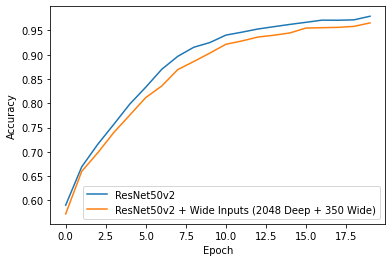

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (2048 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

### ResNet50v2 1024 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 4 Dense Layers before softmax.
- Max Accuracy is 0.9656

In [ ]:
ResNet50V2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_1024 = ResNet50V2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.2055 - accuracy: 0.5721 - val_loss: 1.0758 - val_accuracy: 0.6176
Epoch 2/20
338/338 [==============================] - 67s 197ms/step - loss: 0.9710 - accuracy: 0.6597 - val_loss: 1.0476 - val_accuracy: 0.6369
Epoch 3/20
338/338 [==============================] - 69s 203ms/step - loss: 0.8492 - accuracy: 0.6978 - val_loss: 1.0043 - val_accuracy: 0.6554
Epoch 4/20
338/338 [==============================] - 67s 197ms/step - loss: 0.7374 - accuracy: 0.7396 - val_loss: 1.0520 - val_accuracy: 0.6581
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.6357 - accuracy: 0.7756 - val_loss: 1.1089 - val_accuracy: 0.6498
Epoch 6/20
338/338 [==============================] - 67s 198ms/step - loss: 0.5300 - accuracy: 0.8118 - val_loss: 1.2404 - val_accuracy: 0.6431
Epoch 7/20
338/338 [==============================] - 68s 200ms/step - loss: 0.4606 - accuracy: 0.8357 - val_loss: 1.2536 - val_ac

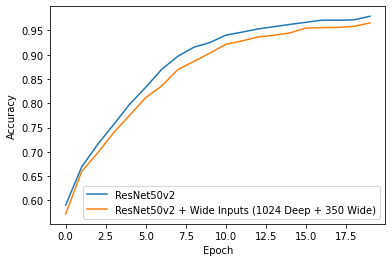

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (1024 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

### ResNet50v2 512 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 4 Dense Layers before softmax.
- Max Accuracy is 0.xx

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input

In [ ]:
ResNet50V2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

ResNet50V2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
ResNet50V2WIDE_model.summary()

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE = ResNet50V2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
ResNet50V2WIDE_model, to_file='modelRES.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

In [ ]:
ResNet50V2WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_512 = ResNet50V2WIDE_512_model.fit(GLCMdata_trainMerged, 
                                                          y_train,
                                                          epochs = epochs,
                                                          batch_size = batch_size,
                                                          validation_data=(GLCMdata_valMerged, y_test)
                                                          )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 72s 212ms/step - loss: 1.2114 - accuracy: 0.5742 - val_loss: 1.0434 - val_accuracy: 0.6280
Epoch 2/20
338/338 [==============================] - 71s 211ms/step - loss: 0.9603 - accuracy: 0.6600 - val_loss: 1.0091 - val_accuracy: 0.6426
Epoch 3/20
338/338 [==============================] - 71s 211ms/step - loss: 0.8446 - accuracy: 0.6993 - val_loss: 1.0172 - val_accuracy: 0.6424
Epoch 4/20
338/338 [==============================] - 71s 211ms/step - loss: 0.7496 - accuracy: 0.7350 - val_loss: 0.9967 - val_accuracy: 0.6533
Epoch 5/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6551 - accuracy: 0.7667 - val_loss: 1.0864 - val_accuracy: 0.6406
Epoch 6/20
338/338 [==============================] - 69s 204ms/step - loss: 0.5638 - accuracy: 0.8020 - val_loss: 1.1179 - val_accuracy: 0.6470
Epoch 7/20
338/338 [==============================] - 71s 210ms/step - loss: 0.4857 - accuracy: 0.8289 - val_loss: 1.2404 - val_ac

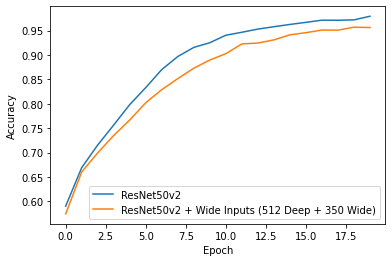

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (512 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

## 2nd Experiment

### ResNet50v2 Deep Learning Only
- 20 Epochs
- 1 Dense Layer before softmax.
- 0.2 Dropout is added. 2times
- Max Accuracy is 0.

In [ ]:
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))

# Warm up model
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
  
inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation= 'softmax')(x)

ResNet50V2_model = Model(inputs = inputs, outputs = predictions)

ResNet50V2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50V2_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                           

In [ ]:
history_ResNet50V2_Exp2 = ResNet50V2_model.fit(x_train,
                                              y_train,
                                              validation_data=(x_test,y_test), 
                                              batch_size=batch_size,
                                              epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.1846 - accuracy: 0.5901 - val_loss: 1.0752 - val_accuracy: 0.6152
Epoch 2/20
338/338 [==============================] - 69s 205ms/step - loss: 0.9345 - accuracy: 0.6689 - val_loss: 1.0309 - val_accuracy: 0.6402
Epoch 3/20
338/338 [==============================] - 70s 206ms/step - loss: 0.7996 - accuracy: 0.7154 - val_loss: 1.0444 - val_accuracy: 0.6504
Epoch 4/20
338/338 [==============================] - 69s 204ms/step - loss: 0.6818 - accuracy: 0.7564 - val_loss: 1.0984 - val_accuracy: 0.6493
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.5678 - accuracy: 0.7982 - val_loss: 1.2903 - val_accuracy: 0.6402
Epoch 6/20
338/338 [==============================] - 69s 203ms/step - loss: 0.4760 - accuracy: 0.8331 - val_loss: 1.3491 - val_accuracy: 0.6493
Epoch 7/20
338/338 [==============================] - 69s 205ms/step - loss: 0.3782 - accuracy: 0.8700 - val_loss: 1.4875 - val_ac

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 1 Dense Layer before softmax.
- 0.2 Dropout is added. 2times
- Max Accuracy is 0.

In [ ]:
ResNet50V2WIDE_2048_model_Exp2 = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_2048_model_Exp2 = tf.keras.Model(inputs=[wideInput0, 
                                          wideInputInvariantRed,
                                          wideInputInvariantGreen,
                                          wideInputInvariantBlue, 
                                          wideInputHU,
                                          wideInputHOG,
                                          wideInputLPB,
                                          wideInputGLCM, 
                                          wideInputD
                                          ],  
                                          outputs=merged_out)

ResNet50V2WIDE_2048_model_Exp2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_2048_model_Exp2 = ResNet50V2WIDE_2048_model_Exp2.fit(
                                                          GLCMdata_trainMerged, 
                                                          y_train,
                                                          epochs = epochs,
                                                          batch_size = batch_size,
                                                          validation_data=(GLCMdata_valMerged, y_test)
                                                          )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 72s 212ms/step - loss: 1.2114 - accuracy: 0.5742 - val_loss: 1.0434 - val_accuracy: 0.6280
Epoch 2/20
338/338 [==============================] - 71s 211ms/step - loss: 0.9603 - accuracy: 0.6600 - val_loss: 1.0091 - val_accuracy: 0.6426
Epoch 3/20
338/338 [==============================] - 71s 211ms/step - loss: 0.8446 - accuracy: 0.6993 - val_loss: 1.0172 - val_accuracy: 0.6424
Epoch 4/20
338/338 [==============================] - 71s 211ms/step - loss: 0.7496 - accuracy: 0.7350 - val_loss: 0.9967 - val_accuracy: 0.6533
Epoch 5/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6551 - accuracy: 0.7667 - val_loss: 1.0864 - val_accuracy: 0.6406
Epoch 6/20
338/338 [==============================] - 69s 204ms/step - loss: 0.5638 - accuracy: 0.8020 - val_loss: 1.1179 - val_accuracy: 0.6470
Epoch 7/20
338/338 [==============================] - 71s 210ms/step - loss: 0.4857 - accuracy: 0.8289 - val_loss: 1.2404 - val_ac

In [ ]:
plt.plot(history_ResNet50V2_Exp2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_2048_model_Exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (512 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

# **DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121

## 1st Experiment

### DenseNet121 DL Only
- 2 Dense Layers
- 1 Dropout with 0.2 and 1 Batch Normalization
- The max accuracy is 0.9206

In [ ]:
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))

base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

DenseNet121_model = Model(inputs = inputs, outputs = predictions)

DenseNet121_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                              

In [ ]:
history_DenseNet121 = DenseNet121_model.fit( x_train,y_train,
                                               validation_data = (x_test,y_test),
                                               epochs=20
                                               #callbacks=[reduce_lr]
                                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 275s 395ms/step - loss: 0.7710 - accuracy: 0.7349 - val_loss: 0.6037 - val_accuracy: 0.7907
Epoch 2/20
675/675 [==============================] - 263s 389ms/step - loss: 0.5740 - accuracy: 0.8004 - val_loss: 0.5360 - val_accuracy: 0.8115
Epoch 3/20
675/675 [==============================] - 276s 410ms/step - loss: 0.5265 - accuracy: 0.8133 - val_loss: 0.5404 - val_accuracy: 0.8061
Epoch 4/20
675/675 [==============================] - 267s 396ms/step - loss: 0.4783 - accuracy: 0.8299 - val_loss: 0.5422 - val_accuracy: 0.8169
Epoch 5/20
675/675 [==============================] - 266s 394ms/step - loss: 0.4455 - accuracy: 0.8426 - val_loss: 0.5303 - val_accuracy: 0.8169
Epoch 6/20
675/675 [==============================] - 268s 397ms/step - loss: 0.4299 - accuracy: 0.8459 - val_loss: 0.5431 - val_accuracy: 0.8163
Epoch 7/20
675/675 [==============================] - 267s 396ms/step - loss: 0.3980 - accuracy: 0.8585 - val_loss: 0.5369 -

### DenseNet121 1024Param Deep Input + 350 Param Wide Input
- 2 Dense Layers
- 1 Dropout with 0.2 and 1 Batch Normalization
- The max accuracy is 0.9169

In [ ]:
DenseNet121WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dense(512,activation='relu')(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.2)(merged_out)
merged_out = Dense(256,activation='relu')(merged_out)
merged_out = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)

DenseNet121WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                      wideInputInvariantRed,
                                      wideInputInvariantGreen,
                                      wideInputInvariantBlue, 
                                      wideInputHU,
                                      wideInputHOG,
                                      wideInputLPB,
                                      wideInputGLCM, 
                                      wideInputD
                                      ],  
                                      outputs=merged_out)

DenseNet121WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE = DenseNet121WIDE_model.fit(GLCMdata_trainMerged, 
                                                    y_train,
                                                    epochs = epochs,
                                                    validation_data=(GLCMdata_valMerged, y_test),
                                                    #callbacks = [reduce_lr]
                                                    )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 342s 505ms/step - loss: 0.7639 - accuracy: 0.7380 - val_loss: 0.5643 - val_accuracy: 0.8126
Epoch 2/20
675/675 [==============================] - 264s 392ms/step - loss: 0.5740 - accuracy: 0.7986 - val_loss: 0.6477 - val_accuracy: 0.7700
Epoch 3/20
675/675 [==============================] - 267s 396ms/step - loss: 0.5173 - accuracy: 0.8185 - val_loss: 0.5406 - val_accuracy: 0.8109
Epoch 4/20
675/675 [==============================] - 255s 378ms/step - loss: 0.4779 - accuracy: 0.8305 - val_loss: 0.5205 - val_accuracy: 0.8148
Epoch 5/20
675/675 [==============================] - 258s 382ms/step - loss: 0.4471 - accuracy: 0.8396 - val_loss: 0.5667 - val_accuracy: 0.8085
Epoch 6/20
675/675 [==============================] - 258s 382ms/step - loss: 0.4284 - accuracy: 0.8482 - val_loss: 0.4927 - val_accuracy: 0.8313
Epoch 7/20
675/675 [==============================] - 264s 391ms/step - loss: 0.4000 - accuracy: 0.8531 - val_loss: 0.5351 -

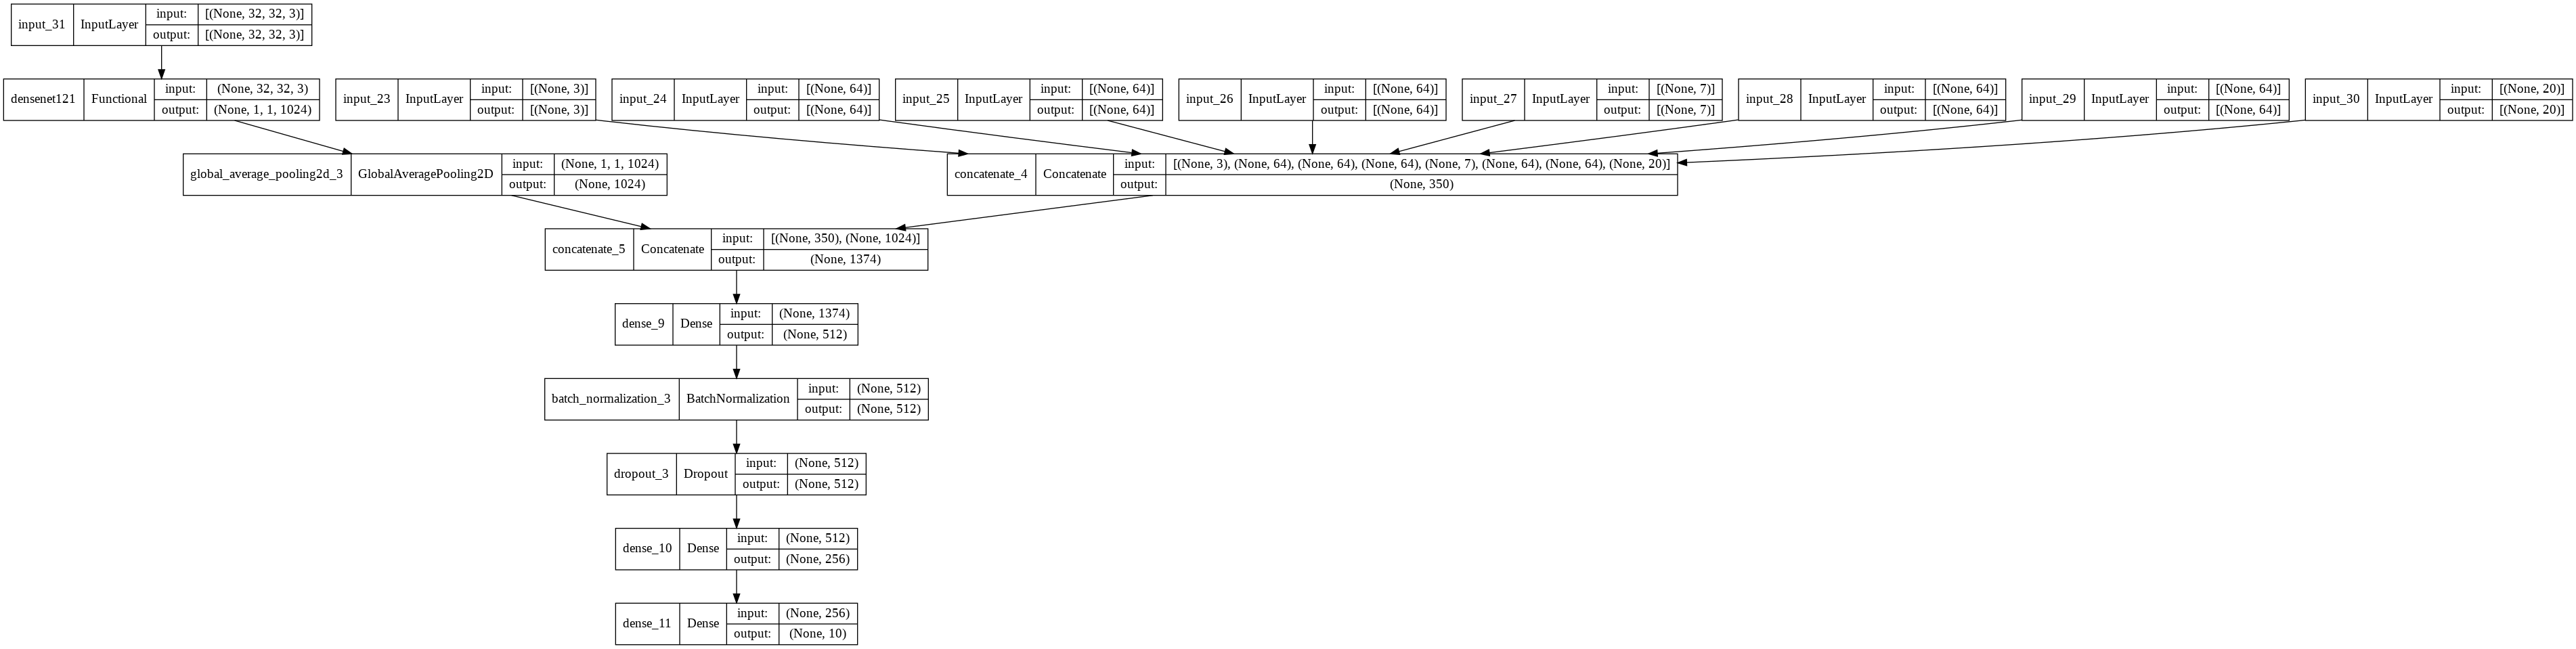

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_model, to_file='modeleff.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

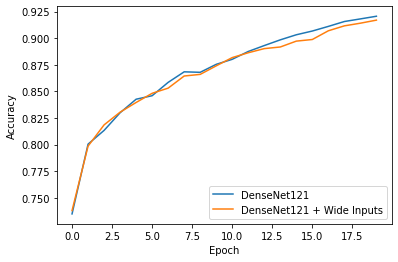

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'DenseNet121 + Wide Inputs'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## 2nd Experiment

### DenseNet121 DL Only
- 0 Dense Layers
- The max accuracy is 0.8636

In [ ]:
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))

base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

DenseNet121_model = Model(inputs = inputs, outputs = predictions)

DenseNet121_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 10)                10250     
                                                                 
Total params: 7,047,754
Trainable params: 10,250
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
history_DenseNet121 = DenseNet121_model.fit( x_train,y_train,
                                               validation_data = (x_test,y_test),
                                               epochs=20
                                               #callbacks=[reduce_lr]
                                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 332s 491ms/step - loss: 0.8664 - accuracy: 0.6987 - val_loss: 0.6505 - val_accuracy: 0.7767
Epoch 2/20
675/675 [==============================] - 271s 402ms/step - loss: 0.6006 - accuracy: 0.7952 - val_loss: 0.5724 - val_accuracy: 0.8015
Epoch 3/20
675/675 [==============================] - 264s 391ms/step - loss: 0.5439 - accuracy: 0.8106 - val_loss: 0.5589 - val_accuracy: 0.8028
Epoch 4/20
675/675 [==============================] - 263s 389ms/step - loss: 0.5107 - accuracy: 0.8224 - val_loss: 0.5422 - val_accuracy: 0.8106
Epoch 5/20
675/675 [==============================] - 262s 389ms/step - loss: 0.4894 - accuracy: 0.8297 - val_loss: 0.5301 - val_accuracy: 0.8161
Epoch 6/20
675/675 [==============================] - 264s 391ms/step - loss: 0.4720 - accuracy: 0.8375 - val_loss: 0.5312 - val_accuracy: 0.8159
Epoch 7/20
675/675 [==============================] - 264s 391ms/step - loss: 0.4577 - accuracy: 0.8409 - val_loss: 0.5398 -

### DenseNet121 1024Param Deep Input + 350 Param Wide Input
- 0 Dense Layer
- The max accuracy is 0.8638

In [ ]:
DenseNet121WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)

DenseNet121WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                      wideInputInvariantRed,
                                      wideInputInvariantGreen,
                                      wideInputInvariantBlue, 
                                      wideInputHU,
                                      wideInputHOG,
                                      wideInputLPB,
                                      wideInputGLCM, 
                                      wideInputD
                                      ],  
                                      outputs=merged_out)

DenseNet121WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE_2 = DenseNet121WIDE_model.fit(GLCMdata_trainMerged, 
                                                    y_train,
                                                    epochs = epochs,
                                                    validation_data=(GLCMdata_valMerged, y_test),
                                                    #callbacks = [reduce_lr]
                                                    )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 207s 292ms/step - loss: 0.8377 - accuracy: 0.7134 - val_loss: 0.6704 - val_accuracy: 0.7696
Epoch 2/20
675/675 [==============================] - 197s 292ms/step - loss: 0.5937 - accuracy: 0.7945 - val_loss: 0.5899 - val_accuracy: 0.7994
Epoch 3/20
675/675 [==============================] - 199s 295ms/step - loss: 0.5359 - accuracy: 0.8139 - val_loss: 0.5696 - val_accuracy: 0.8037
Epoch 4/20
675/675 [==============================] - 199s 295ms/step - loss: 0.5049 - accuracy: 0.8233 - val_loss: 0.5645 - val_accuracy: 0.8128
Epoch 5/20
675/675 [==============================] - 198s 293ms/step - loss: 0.4854 - accuracy: 0.8303 - val_loss: 0.5542 - val_accuracy: 0.8093
Epoch 6/20
675/675 [==============================] - 197s 292ms/step - loss: 0.4669 - accuracy: 0.8391 - val_loss: 0.5409 - val_accuracy: 0.8115
Epoch 7/20
675/675 [==============================] - 179s 265ms/step - loss: 0.4546 - accuracy: 0.8413 - val_loss: 0.5537 -

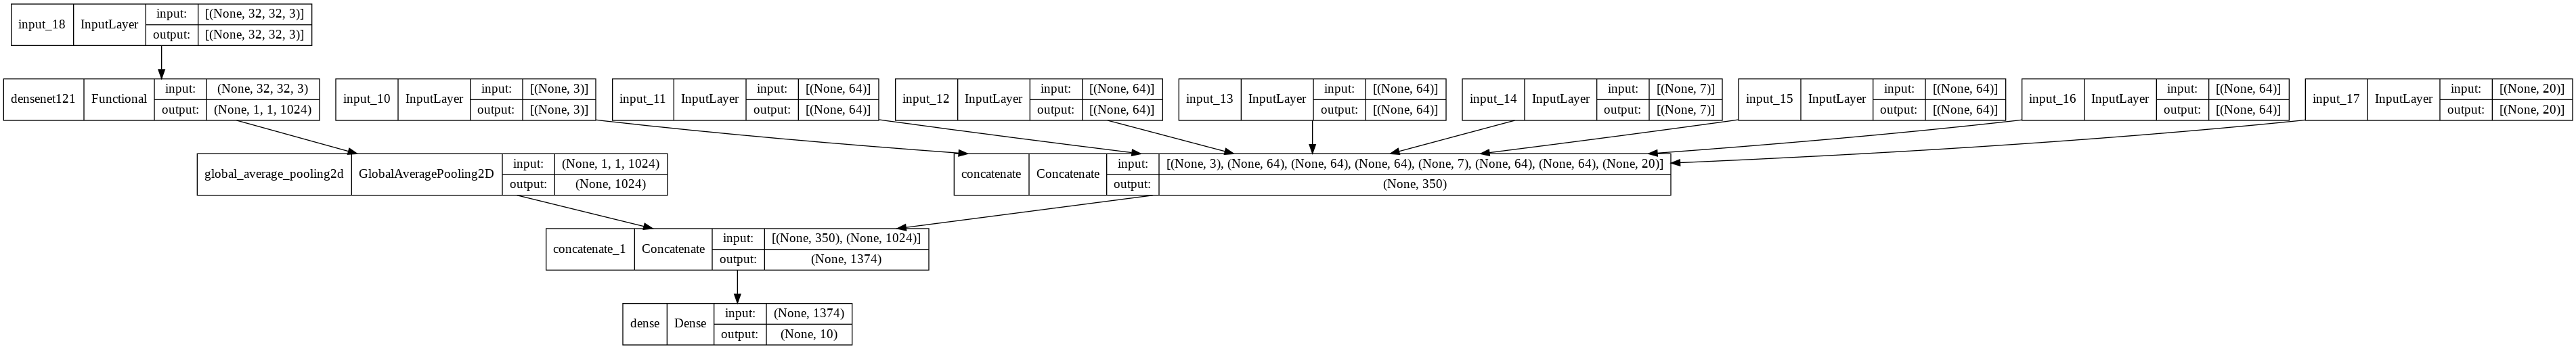

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_model, to_file='modeleff.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['EfficientNetB0', 'EfficientNetB0 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## 3rd Experiment

### DenseNet121 DL Only
- 1 Dense Layers
- The max accuracy is 0.9810

In [ ]:
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))

base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

DenseNet121_model = Model(inputs = inputs, outputs = predictions)

DenseNet121_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 7,567,434
Trainable params: 529,930
Non-trainable params: 7,037,504
___________________________________________

In [ ]:
history_DenseNet121_512 = DenseNet121_model.fit( x_train,y_train,
                                               validation_data = (x_test,y_test),
                                               epochs=20
                                               #callbacks=[reduce_lr]
                                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 186s 276ms/step - loss: 0.7012 - accuracy: 0.7565 - val_loss: 0.5962 - val_accuracy: 0.7943
Epoch 2/20
675/675 [==============================] - 198s 293ms/step - loss: 0.5179 - accuracy: 0.8157 - val_loss: 0.6617 - val_accuracy: 0.7685
Epoch 3/20
675/675 [==============================] - 199s 295ms/step - loss: 0.4508 - accuracy: 0.8394 - val_loss: 0.5827 - val_accuracy: 0.7994
Epoch 4/20
675/675 [==============================] - 180s 267ms/step - loss: 0.4008 - accuracy: 0.8590 - val_loss: 0.5420 - val_accuracy: 0.8172
Epoch 5/20
675/675 [==============================] - 179s 265ms/step - loss: 0.3534 - accuracy: 0.8727 - val_loss: 0.5695 - val_accuracy: 0.8089
Epoch 6/20
675/675 [==============================] - 180s 266ms/step - loss: 0.3092 - accuracy: 0.8893 - val_loss: 0.5564 - val_accuracy: 0.8226
Epoch 7/20
675/675 [==============================] - 179s 266ms/step - loss: 0.2683 - accuracy: 0.9053 - val_loss: 0.6056 -

### DenseNet121 1024Param Deep Input + 350 Param Wide Input
- 1 Dense Layer
- The max accuracy is 0.9716

In [ ]:
DenseNet121WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dense(512,activation='relu')(merged_out)
merged_out = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)

DenseNet121WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                      wideInputInvariantRed,
                                      wideInputInvariantGreen,
                                      wideInputInvariantBlue, 
                                      wideInputHU,
                                      wideInputHOG,
                                      wideInputLPB,
                                      wideInputGLCM, 
                                      wideInputD
                                      ],  
                                      outputs=merged_out)

DenseNet121WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE_2 = DenseNet121WIDE_model.fit(GLCMdata_trainMerged, 
                                                    y_train,
                                                    epochs = epochs,
                                                    validation_data=(GLCMdata_valMerged, y_test),
                                                    #callbacks = [reduce_lr]
                                                    )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 299s 443ms/step - loss: 0.7255 - accuracy: 0.7482 - val_loss: 0.5661 - val_accuracy: 0.7998
Epoch 2/20
675/675 [==============================] - 262s 389ms/step - loss: 0.5369 - accuracy: 0.8105 - val_loss: 0.5750 - val_accuracy: 0.7993
Epoch 3/20
675/675 [==============================] - 254s 376ms/step - loss: 0.4781 - accuracy: 0.8299 - val_loss: 0.5486 - val_accuracy: 0.8054
Epoch 4/20
675/675 [==============================] - 266s 395ms/step - loss: 0.4329 - accuracy: 0.8466 - val_loss: 0.6293 - val_accuracy: 0.7783
Epoch 5/20
675/675 [==============================] - 261s 387ms/step - loss: 0.3956 - accuracy: 0.8569 - val_loss: 0.5539 - val_accuracy: 0.8033
Epoch 6/20
675/675 [==============================] - 268s 398ms/step - loss: 0.3548 - accuracy: 0.8713 - val_loss: 0.6110 - val_accuracy: 0.7946
Epoch 7/20
675/675 [==============================] - 263s 390ms/step - loss: 0.3210 - accuracy: 0.8847 - val_loss: 0.6020 -

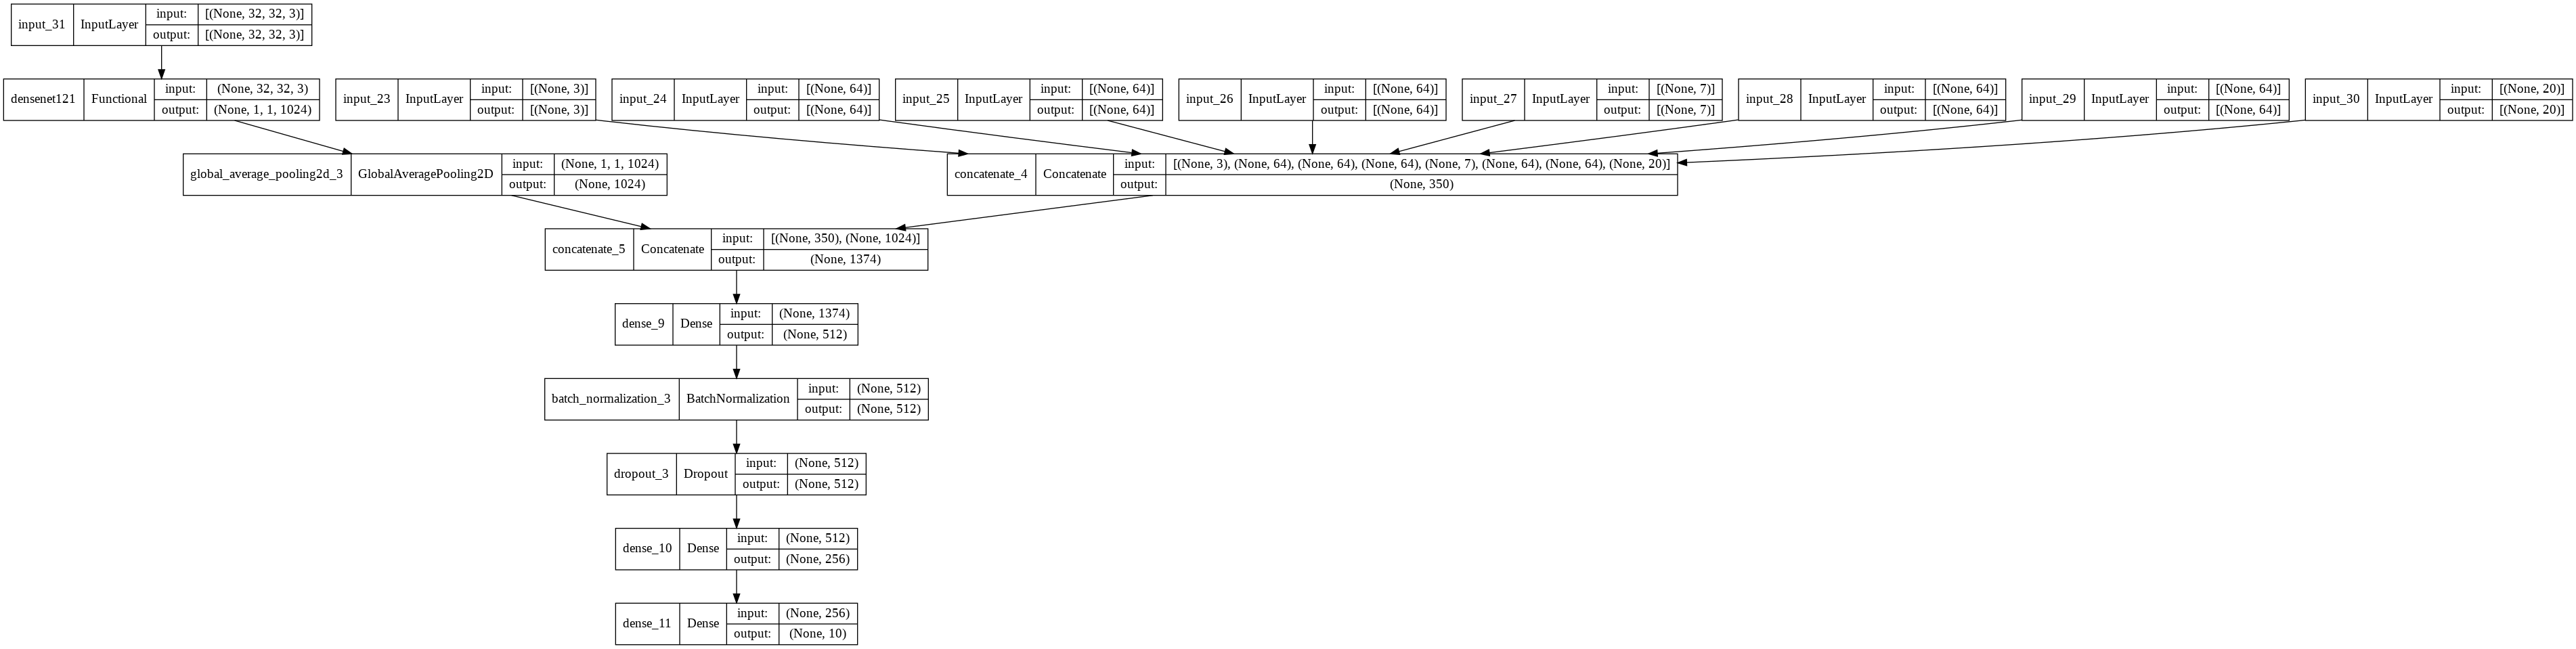

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_model, to_file='modeleff.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

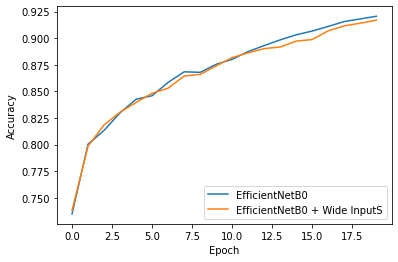

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['EfficientNetB0', 'EfficientNetB0 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## 4th Experiment

### DenseNet121 DL Only

In [ ]:

from tensorflow.keras.applications import DenseNet121

base_model_exp2 = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model_exp2.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model_exp2 is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model_exp2(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

DenseNet121_model_exp2 = Model(inputs = inputs, outputs = predictions)

DenseNet121_model_exp2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model_exp2.summary()

NameError: ignored

In [ ]:
history_DenseNet121_model_exp2 = DenseNet121_model_exp2.fit( x_train,y_train,
                                               validation_data=(x_test,y_test),
                                               epochs=20,
                                               batch_size = batch_size
                                               #callbacks=[reduce_lr]
                                              )

### DenseNet121 512Param Deep Input + 350 Param Wide Input


In [ ]:
from tensorflow.keras.applications import DenseNet121

DenseNet121WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])

merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

DenseNet121WIDE_512_model = tf.keras.Model( inputs=[wideInput0, 
                                            wideInputInvariantRed,
                                            wideInputInvariantGreen,
                                            wideInputInvariantBlue, 
                                            wideInputHU,
                                            wideInputHOG,
                                            wideInputLPB,
                                            wideInputGLCM, 
                                            wideInputD
                                            ],  
                                            outputs=merged_out)

DenseNet121WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE_512 = DenseNet121WIDE_512_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 20,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 169s 376ms/step - loss: 0.2521 - accuracy: 0.8953 - val_loss: 0.2232 - val_accuracy: 0.9094
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.1576 - val_accuracy: 0.9371
Epoch 3/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 5/20
450/450 [==============================] - 166s 369ms/step - loss: 0.1113 - accuracy: 0.9576 - val_loss: 0.1543 - val_accuracy: 0.9465
Epoch 6/20
450/450 [==============================] - 167s 371ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0933 - accuracy: 0.9633 - val_loss: 0.1418 -

### Result Comparisons

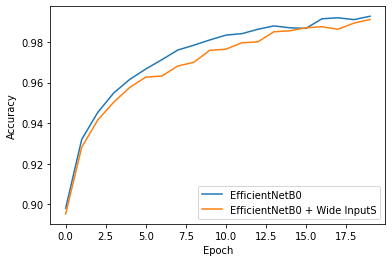

In [ ]:
plt.plot(history_DenseNet121_model_exp2.history['accuracy'])
plt.plot(history_DenseNet121WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'DenseNet121 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# **MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

## 1st Experiment

### MobileNetv2 Deep Inputs Only
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.7595

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
#x = layers.Flatten()(x)
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNetV2_model = Model(inputs = inputs, outputs = predictions)

MobileNetV2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNetV2_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                

In [ ]:
history_MobileNetV2 = MobileNetV2_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=epochs,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 178ms/step - loss: 1.2685 - accuracy: 0.5421 - val_loss: 1.1391 - val_accuracy: 0.5820
Epoch 2/20
675/675 [==============================] - 119s 177ms/step - loss: 1.1277 - accuracy: 0.5927 - val_loss: 1.0728 - val_accuracy: 0.6102
Epoch 3/20
675/675 [==============================] - 120s 177ms/step - loss: 1.0783 - accuracy: 0.6077 - val_loss: 1.0815 - val_accuracy: 0.6013
Epoch 4/20
675/675 [==============================] - 119s 176ms/step - loss: 1.0410 - accuracy: 0.6229 - val_loss: 1.0434 - val_accuracy: 0.6244
Epoch 5/20
675/675 [==============================] - 120s 178ms/step - loss: 1.0096 - accuracy: 0.6331 - val_loss: 1.0527 - val_accuracy: 0.6219
Epoch 6/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9812 - accuracy: 0.6431 - val_loss: 1.0633 - val_accuracy: 0.6202
Epoch 7/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9525 - accuracy: 0.6513 - val_loss: 1.0850 -

### MobileNetv2 1280 Param Deep Input + 350 Param Wide Input
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.6841

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
#merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 189ms/step - loss: 1.4084 - accuracy: 0.4812 - val_loss: 1.2656 - val_accuracy: 0.5306
Epoch 2/20
675/675 [==============================] - 128s 190ms/step - loss: 1.2248 - accuracy: 0.5565 - val_loss: 1.1411 - val_accuracy: 0.5881
Epoch 3/20
675/675 [==============================] - 123s 183ms/step - loss: 1.1700 - accuracy: 0.5727 - val_loss: 1.1042 - val_accuracy: 0.5991
Epoch 4/20
675/675 [==============================] - 128s 190ms/step - loss: 1.1267 - accuracy: 0.5944 - val_loss: 1.0774 - val_accuracy: 0.6169
Epoch 5/20
675/675 [==============================] - 129s 191ms/step - loss: 1.0919 - accuracy: 0.6073 - val_loss: 1.0166 - val_accuracy: 0.6357
Epoch 6/20
675/675 [==============================] - 129s 191ms/step - loss: 1.0710 - accuracy: 0.6164 - val_loss: 1.0455 - val_accuracy: 0.6311
Epoch 7/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0358 - accuracy: 0.6285 - val_loss: 1.0268 -

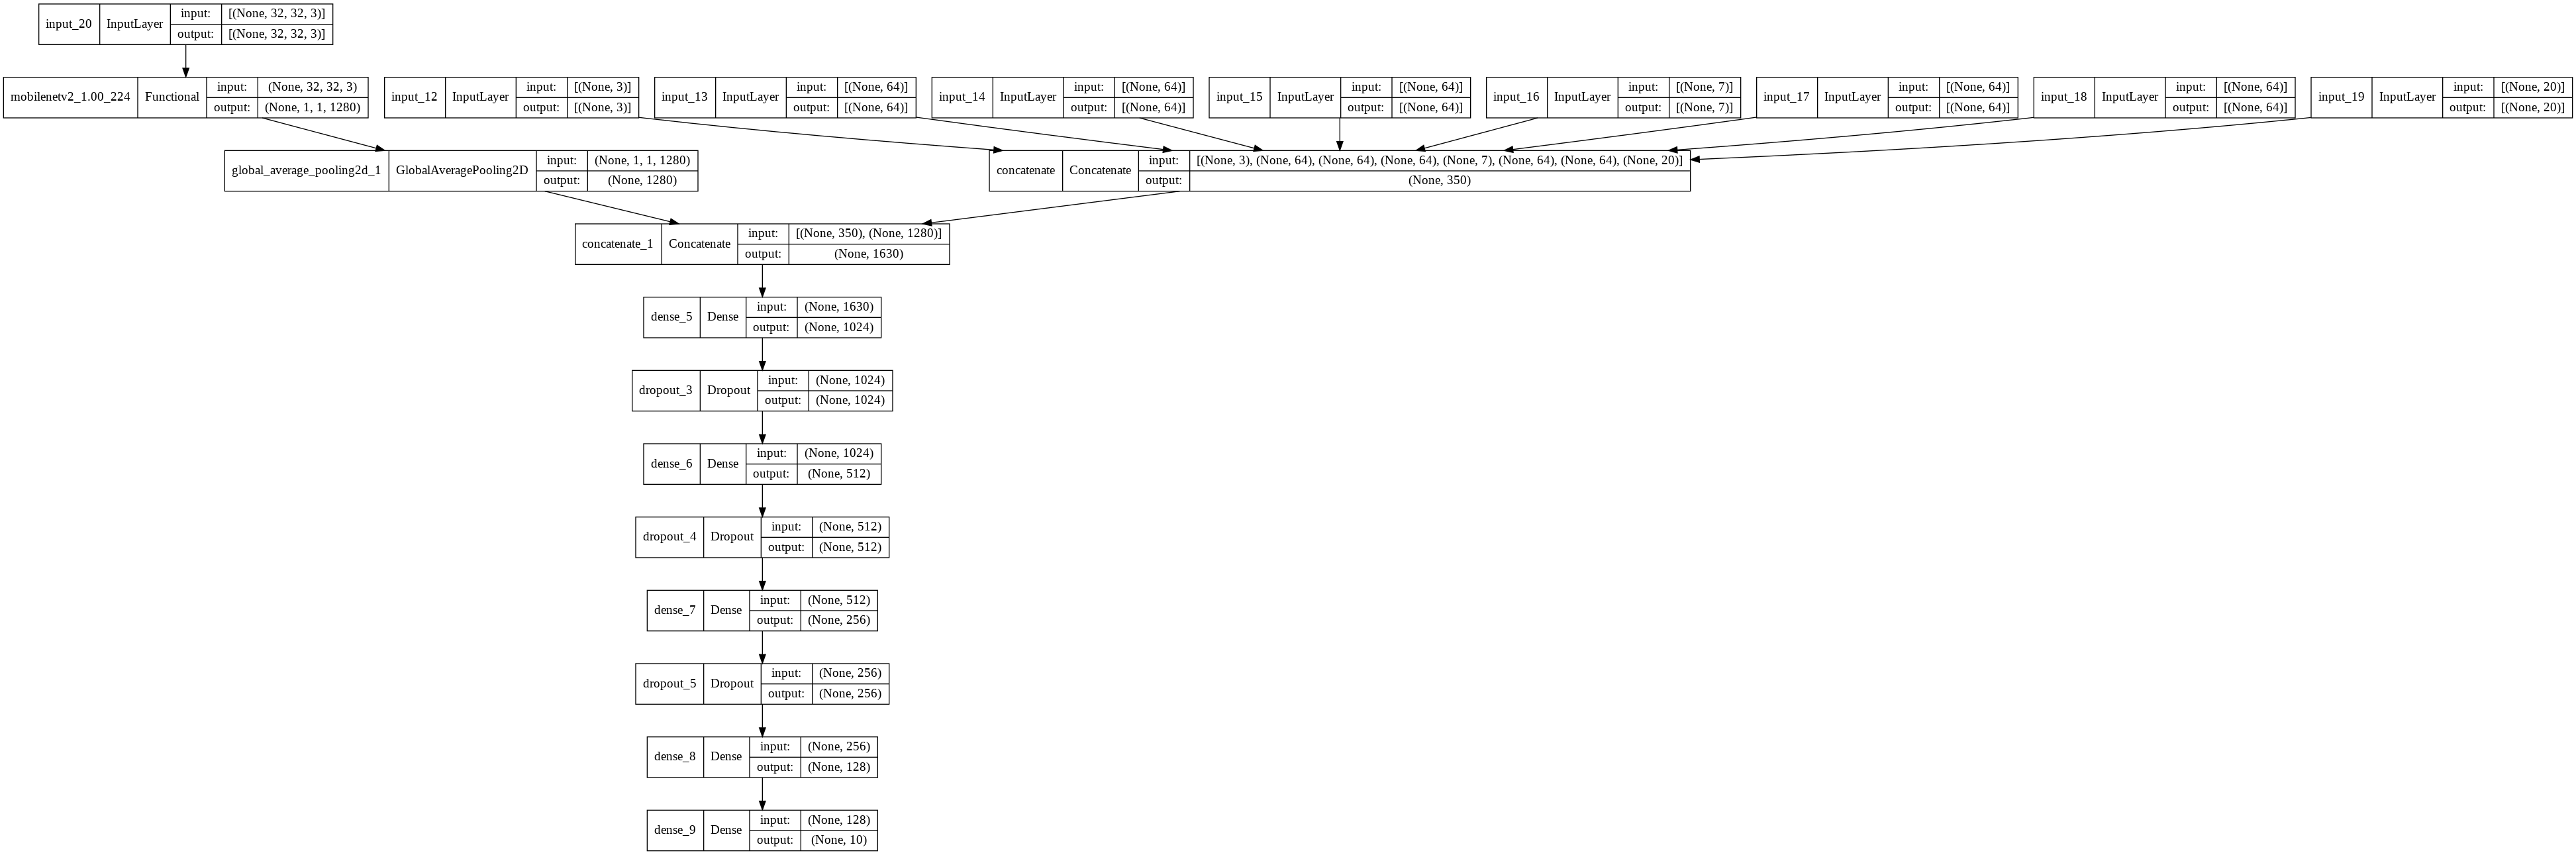

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

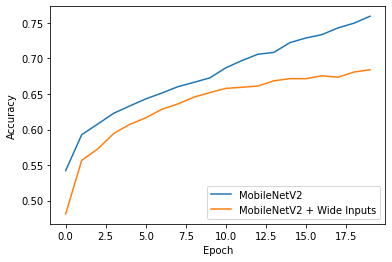

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 1024 Param Deep Input + 350 Param Wide Input
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.7643

In [ ]:
MobileNetV2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_1024_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_40[0][0]']               
 al)                                                                                              
                                                                                                  
 input_32 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 64)]         0           []                         

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_1024 = MobileNetV2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 125s 185ms/step - loss: 1.3475 - accuracy: 0.5137 - val_loss: 1.1809 - val_accuracy: 0.5813
Epoch 2/20
675/675 [==============================] - 124s 183ms/step - loss: 1.1742 - accuracy: 0.5818 - val_loss: 1.1012 - val_accuracy: 0.6070
Epoch 3/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1169 - accuracy: 0.5984 - val_loss: 1.0770 - val_accuracy: 0.6094
Epoch 4/20
675/675 [==============================] - 130s 192ms/step - loss: 1.0780 - accuracy: 0.6139 - val_loss: 1.0672 - val_accuracy: 0.6217
Epoch 5/20
675/675 [==============================] - 129s 192ms/step - loss: 1.0424 - accuracy: 0.6242 - val_loss: 1.0867 - val_accuracy: 0.6170
Epoch 6/20
675/675 [==============================] - 123s 182ms/step - loss: 1.0205 - accuracy: 0.6348 - val_loss: 1.0453 - val_accuracy: 0.6293
Epoch 7/20
675/675 [==============================] - 129s 191ms/step - loss: 0.9867 - accuracy: 0.6455 - val_loss: 1.0430 -

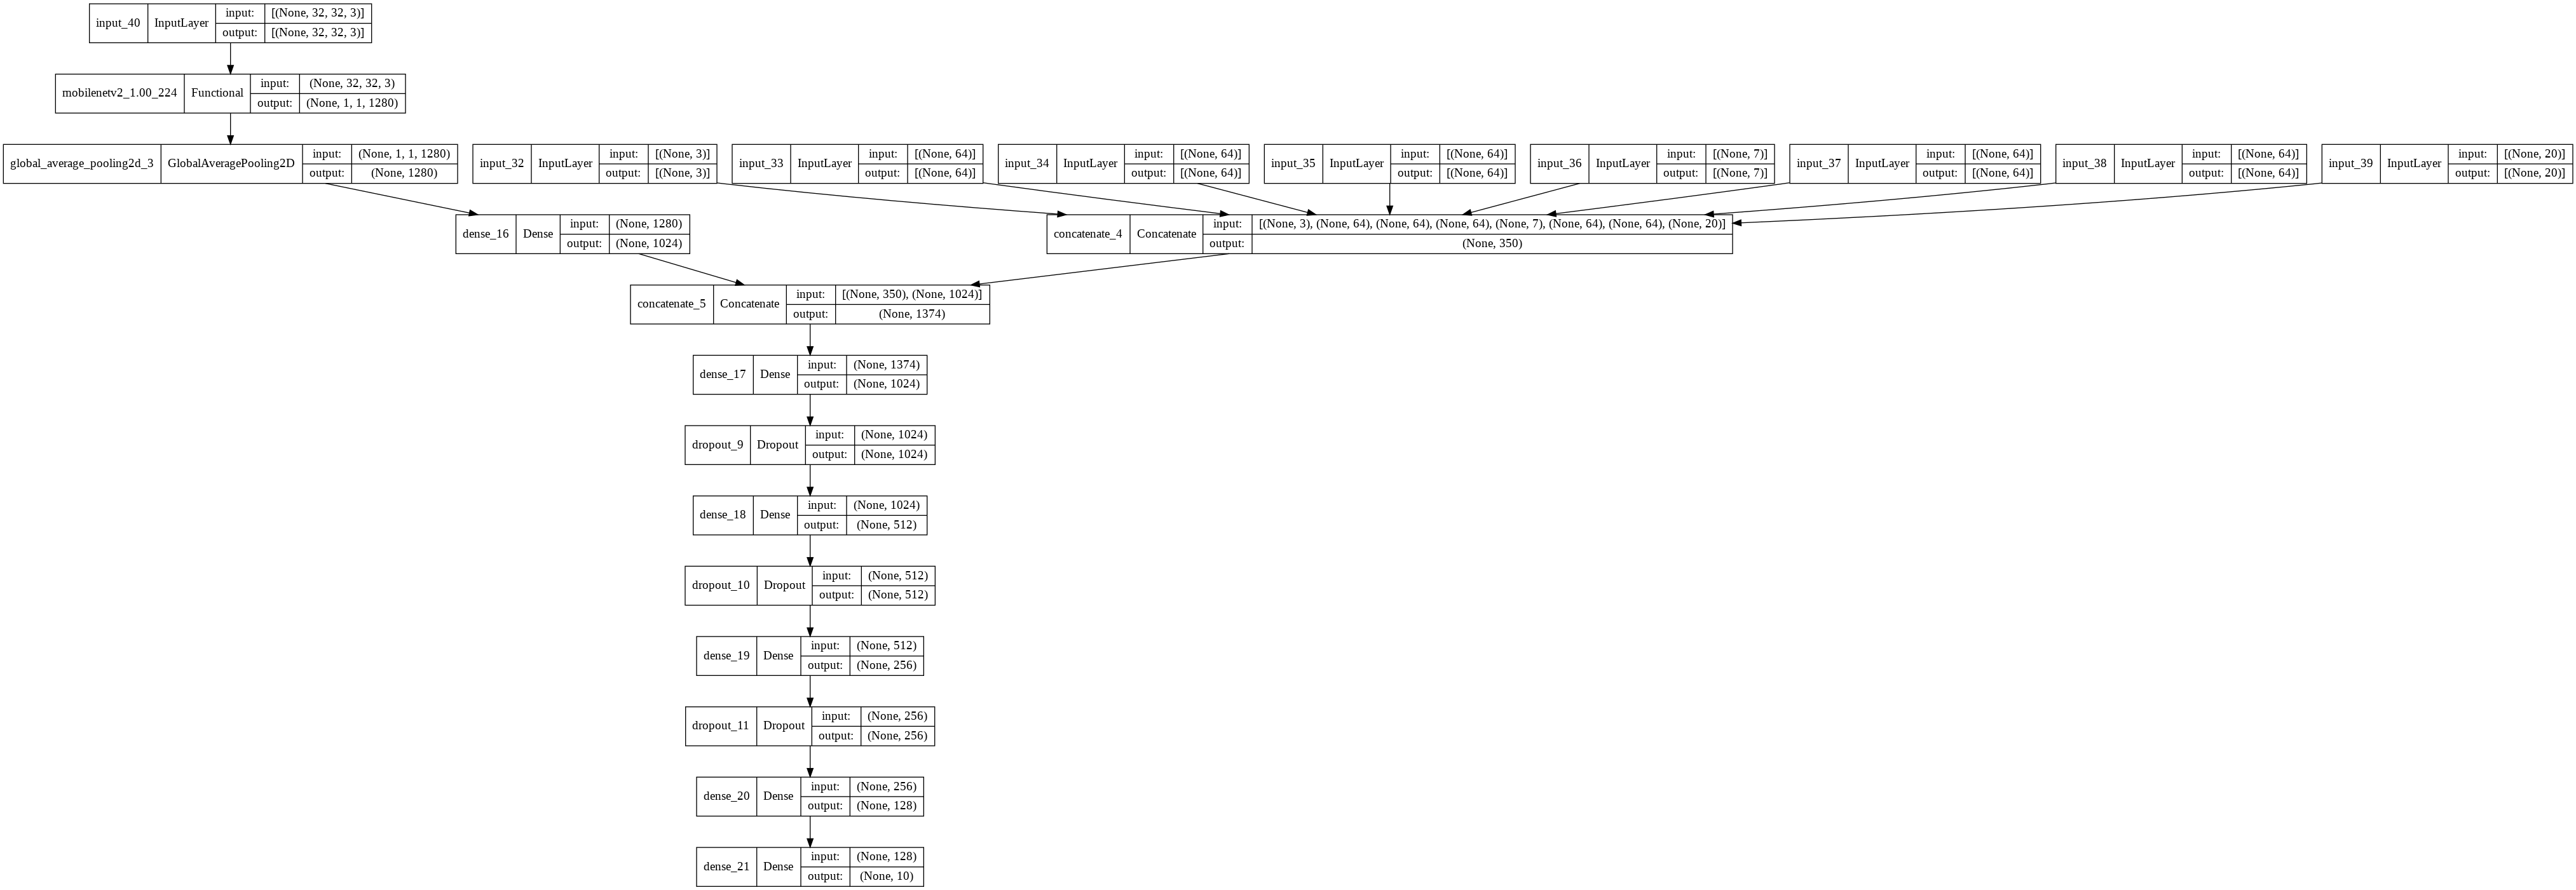

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

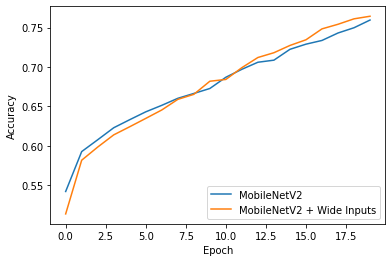

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 512 Param Deep Input + 350 Param Wide Input
- **3** Dropout layers just before the prediction layer.
- Max accuracy 0.7835

In [ ]:
MobileNetV2WIDE_512_model3 = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_512_model3 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_512_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
MobileNetV2WIDE_512_model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_18[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_512_3 = MobileNetV2WIDE_512_model3.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
159/675 [======>.......................] - ETA: 59s - loss: 0.6102 - accuracy: 0.7801

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_512_3.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

NameError: ignored

### MobileNetv2 512 Param Deep Input + 350 Param Wide Input
- 2 Dropout layers just before the prediction layer.
- Max accuracy 0.8342

In [ ]:
MobileNetV2WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_512_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_60[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_512 = MobileNetV2WIDE_512_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 130s 192ms/step - loss: 1.3312 - accuracy: 0.5154 - val_loss: 1.1543 - val_accuracy: 0.5865
Epoch 2/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1560 - accuracy: 0.5845 - val_loss: 1.1383 - val_accuracy: 0.5926
Epoch 3/20
675/675 [==============================] - 125s 185ms/step - loss: 1.0923 - accuracy: 0.6105 - val_loss: 1.1143 - val_accuracy: 0.6057
Epoch 4/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0476 - accuracy: 0.6263 - val_loss: 1.0902 - val_accuracy: 0.6089
Epoch 5/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0219 - accuracy: 0.6337 - val_loss: 1.0710 - val_accuracy: 0.6257
Epoch 6/20
675/675 [==============================] - 124s 184ms/step - loss: 0.9814 - accuracy: 0.6479 - val_loss: 1.0380 - val_accuracy: 0.6252
Epoch 7/20
675/675 [==============================] - 129s 192ms/step - loss: 0.9425 - accuracy: 0.6646 - val_loss: 1.0702 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
history_MobileNetV2WIDE_512, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

AttributeError: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 256 Param Deep Input + 350 Param Wide Input
- No Dropout Layer
- Max accuracy 0.8917

In [ ]:
MobileNetV2WIDE_256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_256_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_80[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_256 = MobileNetV2WIDE_256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 190ms/step - loss: 1.2446 - accuracy: 0.5469 - val_loss: 1.1702 - val_accuracy: 0.5759
Epoch 2/20
675/675 [==============================] - 122s 181ms/step - loss: 1.0908 - accuracy: 0.6062 - val_loss: 1.0834 - val_accuracy: 0.6100
Epoch 3/20
675/675 [==============================] - 122s 181ms/step - loss: 1.0386 - accuracy: 0.6252 - val_loss: 1.0647 - val_accuracy: 0.6200
Epoch 4/20
675/675 [==============================] - 127s 188ms/step - loss: 0.9858 - accuracy: 0.6395 - val_loss: 1.0528 - val_accuracy: 0.6181
Epoch 5/20
675/675 [==============================] - 122s 181ms/step - loss: 0.9451 - accuracy: 0.6539 - val_loss: 1.0493 - val_accuracy: 0.6250
Epoch 6/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9012 - accuracy: 0.6714 - val_loss: 1.0280 - val_accuracy: 0.6357
Epoch 7/20
675/675 [==============================] - 127s 188ms/step - loss: 0.8605 - accuracy: 0.6891 - val_loss: 1.0275 -

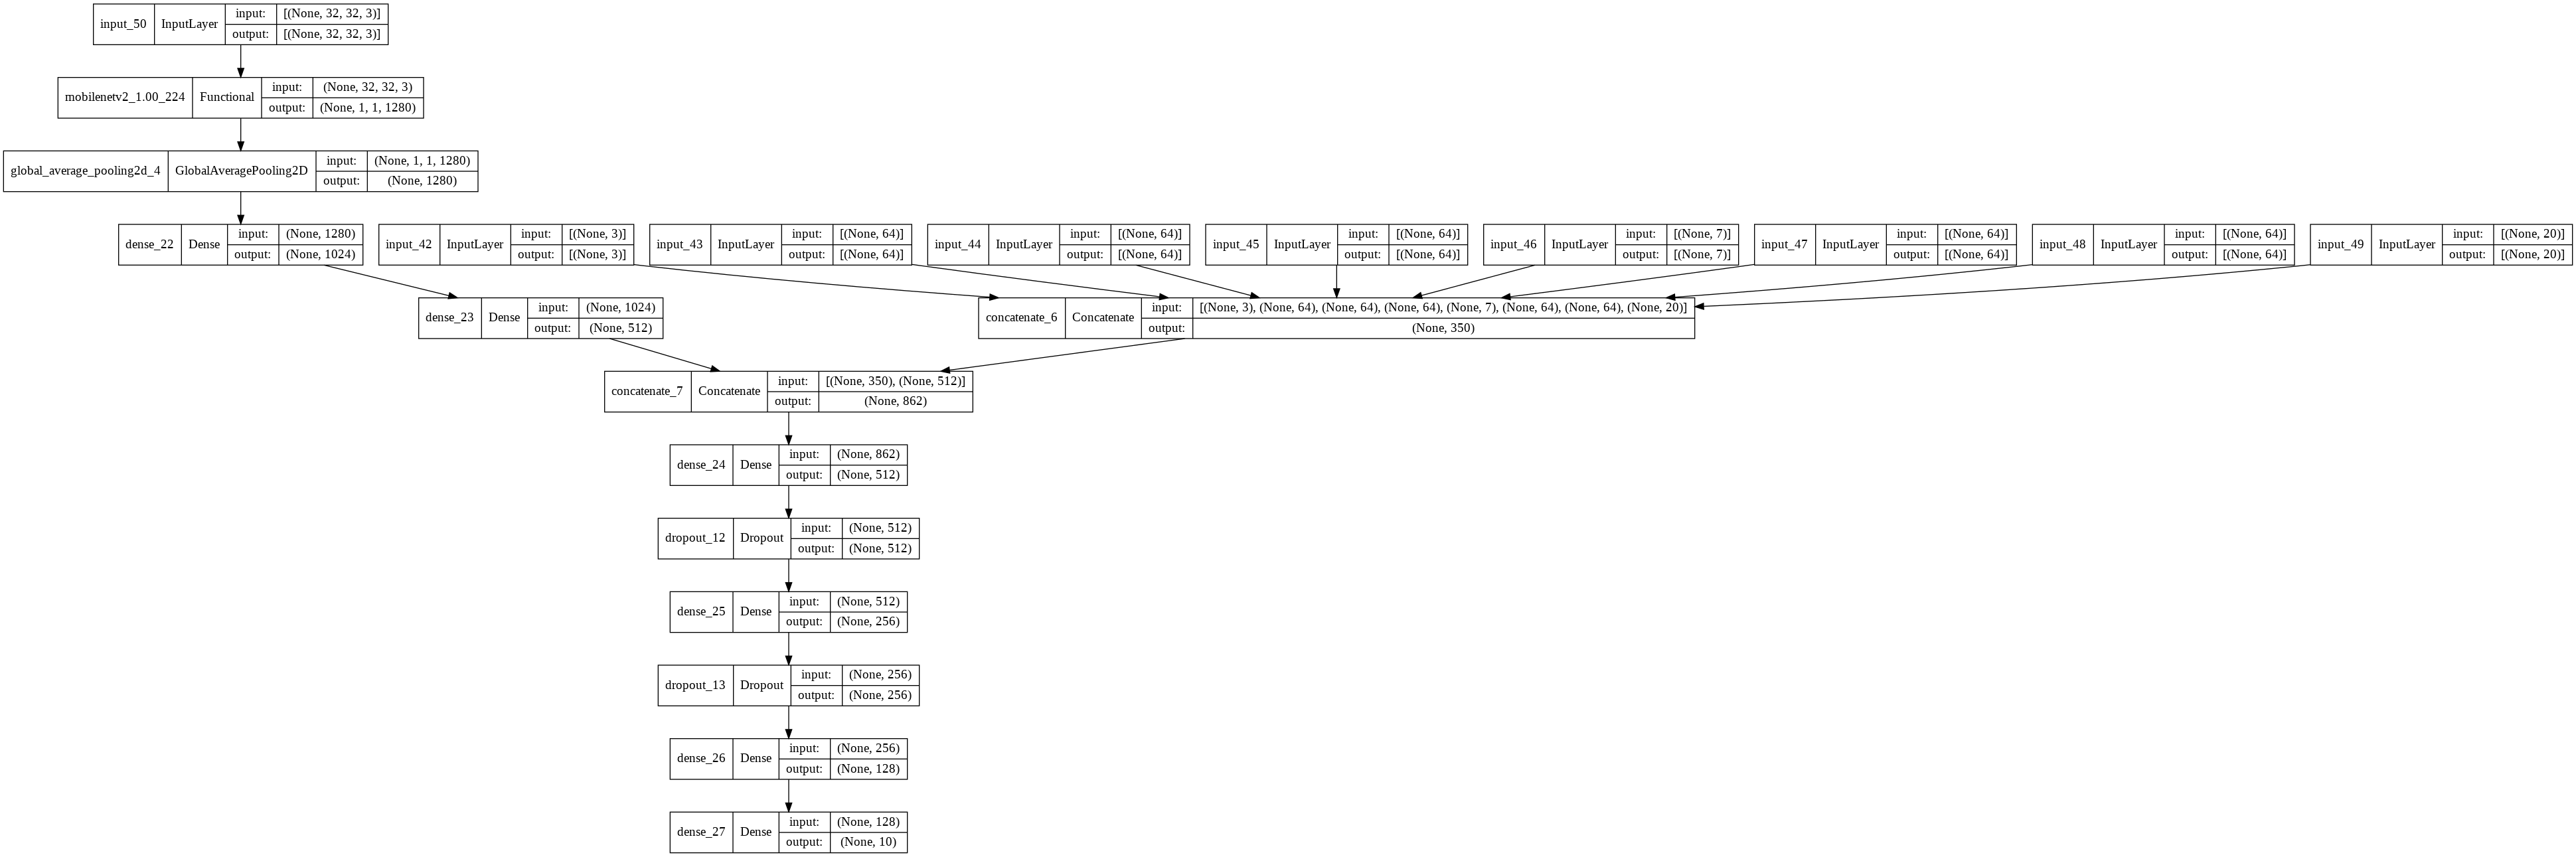

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

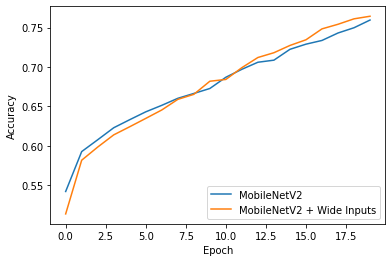

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 256 Param Deep Input + 350 Param Wide Input
- 3 Dropout Layer
- 3 Batch Normalization Layer
- Max accuracy 0.7599

In [ ]:
MobileNetV2WIDE_256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = BatchNormalization()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = BatchNormalization()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_out = BatchNormalization()(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_256_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_38[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_256 = MobileNetV2WIDE_256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 108s 159ms/step - loss: 1.3034 - accuracy: 0.5324 - val_loss: 1.1337 - val_accuracy: 0.5841
Epoch 2/20
675/675 [==============================] - 99s 146ms/step - loss: 1.1511 - accuracy: 0.5785 - val_loss: 1.1034 - val_accuracy: 0.5967
Epoch 3/20
675/675 [==============================] - 98s 145ms/step - loss: 1.1114 - accuracy: 0.5970 - val_loss: 1.0721 - val_accuracy: 0.6141
Epoch 4/20
675/675 [==============================] - 98s 146ms/step - loss: 1.0792 - accuracy: 0.6063 - val_loss: 1.0817 - val_accuracy: 0.6094
Epoch 5/20
675/675 [==============================] - 108s 159ms/step - loss: 1.0554 - accuracy: 0.6175 - val_loss: 1.0817 - val_accuracy: 0.6076
Epoch 6/20
675/675 [==============================] - 108s 160ms/step - loss: 1.0320 - accuracy: 0.6244 - val_loss: 1.0480 - val_accuracy: 0.6237
Epoch 7/20
675/675 [==============================] - 107s 159ms/step - loss: 1.0118 - accuracy: 0.6322 - val_loss: 1.0599 - va

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

## 2nd Experiment:

### MobileNetV2 2nd Experiment without wide inputs:
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy 0.6902

In [ ]:

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x)
x=Dropout(0.25)(x)
x = BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.25)(x)
x = BatchNormalization()(x)
predictions = Dense(10, activation= 'softmax')(x)

xx_model = Model(inputs = inputs, outputs = predictions)

xx_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
xx_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096

In [ ]:
history_xx_model = xx_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=epochs,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 131s 194ms/step - loss: 1.3393 - accuracy: 0.5300 - val_loss: 1.1286 - val_accuracy: 0.5822
Epoch 2/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1608 - accuracy: 0.5799 - val_loss: 1.0907 - val_accuracy: 0.6061
Epoch 3/20
675/675 [==============================] - 125s 186ms/step - loss: 1.1116 - accuracy: 0.5912 - val_loss: 1.0748 - val_accuracy: 0.6100
Epoch 4/20
675/675 [==============================] - 123s 182ms/step - loss: 1.0759 - accuracy: 0.6031 - val_loss: 1.0814 - val_accuracy: 0.6094
Epoch 5/20
675/675 [==============================] - 121s 180ms/step - loss: 1.0596 - accuracy: 0.6093 - val_loss: 1.0629 - val_accuracy: 0.6204
Epoch 6/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0343 - accuracy: 0.6241 - val_loss: 1.0590 - val_accuracy: 0.6159
Epoch 7/20
675/675 [==============================] - 127s 189ms/step - loss: 1.0193 - accuracy: 0.6270 - val_loss: 1.0608 -

### MobileNetv2 with wide inputs:
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy 0.6237

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out =Dense(1024,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out =Dense(256,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 24,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/24
675/675 [==============================] - 132s 196ms/step - loss: 1.5567 - accuracy: 0.4612 - val_loss: 2.0882 - val_accuracy: 0.3293
Epoch 2/24
675/675 [==============================] - 123s 183ms/step - loss: 1.4156 - accuracy: 0.4854 - val_loss: 1.2984 - val_accuracy: 0.5133
Epoch 3/24
675/675 [==============================] - 121s 179ms/step - loss: 1.3375 - accuracy: 0.5209 - val_loss: 1.3041 - val_accuracy: 0.5294
Epoch 4/24
675/675 [==============================] - 120s 178ms/step - loss: 1.2803 - accuracy: 0.5422 - val_loss: 1.1616 - val_accuracy: 0.5861
Epoch 5/24
675/675 [==============================] - 126s 186ms/step - loss: 1.2823 - accuracy: 0.5393 - val_loss: 1.2109 - val_accuracy: 0.5422
Epoch 6/24
675/675 [==============================] - 131s 194ms/step - loss: 1.2244 - accuracy: 0.5647 - val_loss: 1.1257 - val_accuracy: 0.5770
Epoch 7/24
675/675 [==============================] - 129s 191ms/step - loss: 1.1941 - accuracy: 0.5753 - val_loss: 1.2178 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

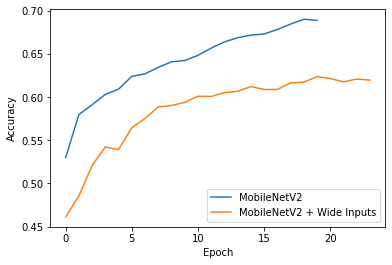

In [ ]:
plt.plot(history_xx_model.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

# **MobileNetV2 TestV2 05.02.2022**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

## 1st Experiment:

### MobileNet DL Only
- Flatten Layer only!
- Max accuracy 0.5984

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
#inputs = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
#inputs = layers.experimental.preprocessing.RandomRotation(0.15)(inputs)
#inputs = layers.experimental.preprocessing.RandomContrast(0.2)(inputs)

x = base_model(inputs, training=False)
x = Flatten()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNet_model = Model(inputs = inputs, outputs = predictions)

MobileNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNet_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_MobileNetV2 = MobileNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size=64
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 65s 167ms/step - loss: 1.9380 - accuracy: 0.4232 - val_loss: 1.6888 - val_accuracy: 0.4983
Epoch 2/20
338/338 [==============================] - 93s 274ms/step - loss: 1.5589 - accuracy: 0.5212 - val_loss: 1.4610 - val_accuracy: 0.5372
Epoch 3/20
338/338 [==============================] - 58s 171ms/step - loss: 1.4014 - accuracy: 0.5457 - val_loss: 1.3525 - val_accuracy: 0.5498
Epoch 4/20
338/338 [==============================] - 59s 174ms/step - loss: 1.3192 - accuracy: 0.5552 - val_loss: 1.2918 - val_accuracy: 0.5589
Epoch 5/20
338/338 [==============================] - 59s 176ms/step - loss: 1.2695 - accuracy: 0.5658 - val_loss: 1.2532 - val_accuracy: 0.5622
Epoch 6/20
338/338 [==============================] - 55s 164ms/step - loss: 1.2364 - accuracy: 0.5715 - val_loss: 1.2266 - val_accuracy: 0.5707
Epoch 7/20
338/338 [==============================] - 60s 178ms/step - loss: 1.2127 - accuracy: 0.5752 - val_loss: 1.2066 - val_ac

### MobileNet with wide inputs:
- Flatten Layer only!
- Max accuracy 0.6185

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape = (input_shape))
base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetWIDE_model = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 59s 174ms/step - loss: 1.9081 - accuracy: 0.4080 - val_loss: 1.6557 - val_accuracy: 0.5122
Epoch 2/20
338/338 [==============================] - 56s 166ms/step - loss: 1.5267 - accuracy: 0.5170 - val_loss: 1.4397 - val_accuracy: 0.5393
Epoch 3/20
338/338 [==============================] - 59s 174ms/step - loss: 1.3768 - accuracy: 0.5459 - val_loss: 1.3331 - val_accuracy: 0.5620
Epoch 4/20
338/338 [==============================] - 59s 175ms/step - loss: 1.2975 - accuracy: 0.5593 - val_loss: 1.2753 - val_accuracy: 0.5674
Epoch 5/20
338/338 [==============================] - 56s 166ms/step - loss: 1.2488 - accuracy: 0.5692 - val_loss: 1.2336 - val_accuracy: 0.5730
Epoch 6/20
338/338 [==============================] - 56s 165ms/step - loss: 1.2159 - accuracy: 0.5778 - val_loss: 1.2067 - val_accuracy: 0.5780
Epoch 7/20
338/338 [==============================] - 59s 175ms/step - loss: 1.1929 - accuracy: 0.5827 - val_loss: 1.1840 - val_ac

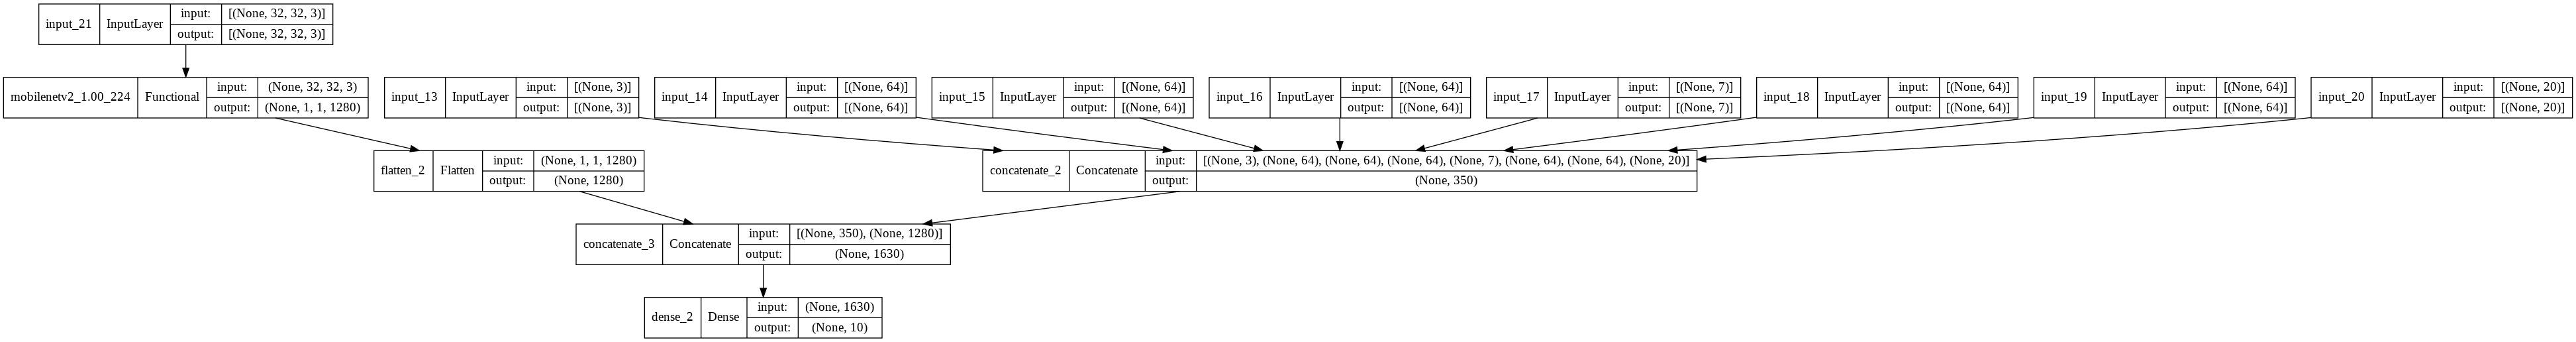

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetWIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

# **MobileNetV2 TestV3 05.02.2022**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

## 1st Experiment:

### MobileNet DL Only
- Flatten Layer only!
- Max accuracy 0.5984

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
#inputs = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
#inputs = layers.experimental.preprocessing.RandomRotation(0.15)(inputs)
#inputs = layers.experimental.preprocessing.RandomContrast(0.2)(inputs)

x = base_model(inputs, training=False)
x = Flatten()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNet_model = Model(inputs = inputs, outputs = predictions)

MobileNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNet_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_MobileNetV2 = MobileNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size=64
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 65s 167ms/step - loss: 1.9380 - accuracy: 0.4232 - val_loss: 1.6888 - val_accuracy: 0.4983
Epoch 2/20
338/338 [==============================] - 93s 274ms/step - loss: 1.5589 - accuracy: 0.5212 - val_loss: 1.4610 - val_accuracy: 0.5372
Epoch 3/20
338/338 [==============================] - 58s 171ms/step - loss: 1.4014 - accuracy: 0.5457 - val_loss: 1.3525 - val_accuracy: 0.5498
Epoch 4/20
338/338 [==============================] - 59s 174ms/step - loss: 1.3192 - accuracy: 0.5552 - val_loss: 1.2918 - val_accuracy: 0.5589
Epoch 5/20
338/338 [==============================] - 59s 176ms/step - loss: 1.2695 - accuracy: 0.5658 - val_loss: 1.2532 - val_accuracy: 0.5622
Epoch 6/20
338/338 [==============================] - 55s 164ms/step - loss: 1.2364 - accuracy: 0.5715 - val_loss: 1.2266 - val_accuracy: 0.5707
Epoch 7/20
338/338 [==============================] - 60s 178ms/step - loss: 1.2127 - accuracy: 0.5752 - val_loss: 1.2066 - val_ac

### MobileNet with wide inputs:
- Flatten Layer only!
- Max accuracy 0.6185

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape = (input_shape))
base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetWIDE_model = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 59s 174ms/step - loss: 1.9081 - accuracy: 0.4080 - val_loss: 1.6557 - val_accuracy: 0.5122
Epoch 2/20
338/338 [==============================] - 56s 166ms/step - loss: 1.5267 - accuracy: 0.5170 - val_loss: 1.4397 - val_accuracy: 0.5393
Epoch 3/20
338/338 [==============================] - 59s 174ms/step - loss: 1.3768 - accuracy: 0.5459 - val_loss: 1.3331 - val_accuracy: 0.5620
Epoch 4/20
338/338 [==============================] - 59s 175ms/step - loss: 1.2975 - accuracy: 0.5593 - val_loss: 1.2753 - val_accuracy: 0.5674
Epoch 5/20
338/338 [==============================] - 56s 166ms/step - loss: 1.2488 - accuracy: 0.5692 - val_loss: 1.2336 - val_accuracy: 0.5730
Epoch 6/20
338/338 [==============================] - 56s 165ms/step - loss: 1.2159 - accuracy: 0.5778 - val_loss: 1.2067 - val_accuracy: 0.5780
Epoch 7/20
338/338 [==============================] - 59s 175ms/step - loss: 1.1929 - accuracy: 0.5827 - val_loss: 1.1840 - val_ac

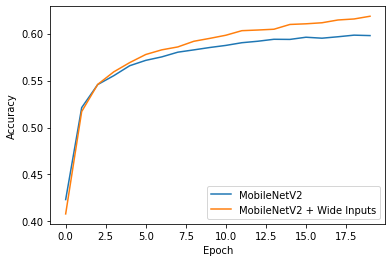

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

### MobileNet with Color Invariants:
- Flatten Layer only!
- Max accuracy 0.5977

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
#wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
#wideInputHU = layers.Input(shape=(7,))
#wideInputHOG = layers.Input(shape=(64,))
#wideInputLPB = layers.Input(shape=(64,))
#wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape = (input_shape))
base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([#wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    #wideInputHU,
                                                    #wideInputHOG,
                                                    #wideInputLPB,
                                                    #wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[#wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     #wideInputHU,
                                     #wideInputHOG,
                                     #wideInputLPB,
                                     #wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [#x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        #x_train_HU,
                        #x_train_hog_vector,
                        #x_train_lbp_vector,
                        #x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [#x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      #x_test_HU,
                     # x_test_hog_vector,
                      #x_test_lbp_vector,
                      #x_test_glcm,
                      x_test
                      ]

history_MobileNetWIDE_model2 = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 135s 400ms/step - loss: 1.9078 - accuracy: 0.4268 - val_loss: 1.6565 - val_accuracy: 0.5048
Epoch 2/20
338/338 [==============================] - 92s 272ms/step - loss: 1.5324 - accuracy: 0.5183 - val_loss: 1.4406 - val_accuracy: 0.5233
Epoch 3/20
338/338 [==============================] - 130s 385ms/step - loss: 1.3838 - accuracy: 0.5404 - val_loss: 1.3371 - val_accuracy: 0.5509
Epoch 4/20
338/338 [==============================] - 142s 422ms/step - loss: 1.3071 - accuracy: 0.5539 - val_loss: 1.2832 - val_accuracy: 0.5565
Epoch 5/20
338/338 [==============================] - 138s 407ms/step - loss: 1.2613 - accuracy: 0.5612 - val_loss: 1.2426 - val_accuracy: 0.5689
Epoch 6/20
338/338 [==============================] - 104s 306ms/step - loss: 1.2304 - accuracy: 0.5714 - val_loss: 1.2202 - val_accuracy: 0.5676
Epoch 7/20
338/338 [==============================] - 86s 255ms/step - loss: 1.2080 - accuracy: 0.5751 - val_loss: 1.2029 - v

### MobileNet with Local Binary Patterns:
- Flatten Layer only!
- Max accuracy 0.5979

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
wideInputLPB = layers.Input(shape=(64,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape = (input_shape))
base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInputLPB])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInputLPB,
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_32[0][0]']               
 al)                                                                                              
                                                                                                  
 concatenate_8 (Concatenate)    (None, 64)           0           ['input_31[0][0]']         

In [ ]:
GLCMdata_trainMerged = [#x_train_mean ,
                        #x_train_invariant_Red,
                        #x_train_invariant_Green,
                        #x_train_invariant_Blue,
                        #x_train_HU,
                        #x_train_hog_vector,
                        x_train_lbp_vector,
                        #x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [#x_test_mean,
                      #x_test_invariant_Red, 
                      #x_test_invariant_Green,
                      #x_test_invariant_Blue,
                      #x_test_HU,
                     # x_test_hog_vector,
                      x_test_lbp_vector,
                      #x_test_glcm,
                      x_test
                      ]

history_MobileNetWIDE_model3 = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 116s 343ms/step - loss: 1.9180 - accuracy: 0.4191 - val_loss: 1.6646 - val_accuracy: 0.4978
Epoch 2/20
338/338 [==============================] - 100s 295ms/step - loss: 1.5378 - accuracy: 0.5200 - val_loss: 1.4423 - val_accuracy: 0.5326
Epoch 3/20
338/338 [==============================] - 102s 303ms/step - loss: 1.3855 - accuracy: 0.5445 - val_loss: 1.3398 - val_accuracy: 0.5544
Epoch 4/20
338/338 [==============================] - 96s 286ms/step - loss: 1.3075 - accuracy: 0.5561 - val_loss: 1.2806 - val_accuracy: 0.5598
Epoch 5/20
338/338 [==============================] - 101s 299ms/step - loss: 1.2602 - accuracy: 0.5654 - val_loss: 1.2448 - val_accuracy: 0.5648
Epoch 6/20
338/338 [==============================] - 80s 235ms/step - loss: 1.2289 - accuracy: 0.5710 - val_loss: 1.2190 - val_accuracy: 0.5724
Epoch 7/20
338/338 [==============================] - 62s 183ms/step - loss: 1.2063 - accuracy: 0.5771 - val_loss: 1.2011 - va

### Results Graphs Comparison

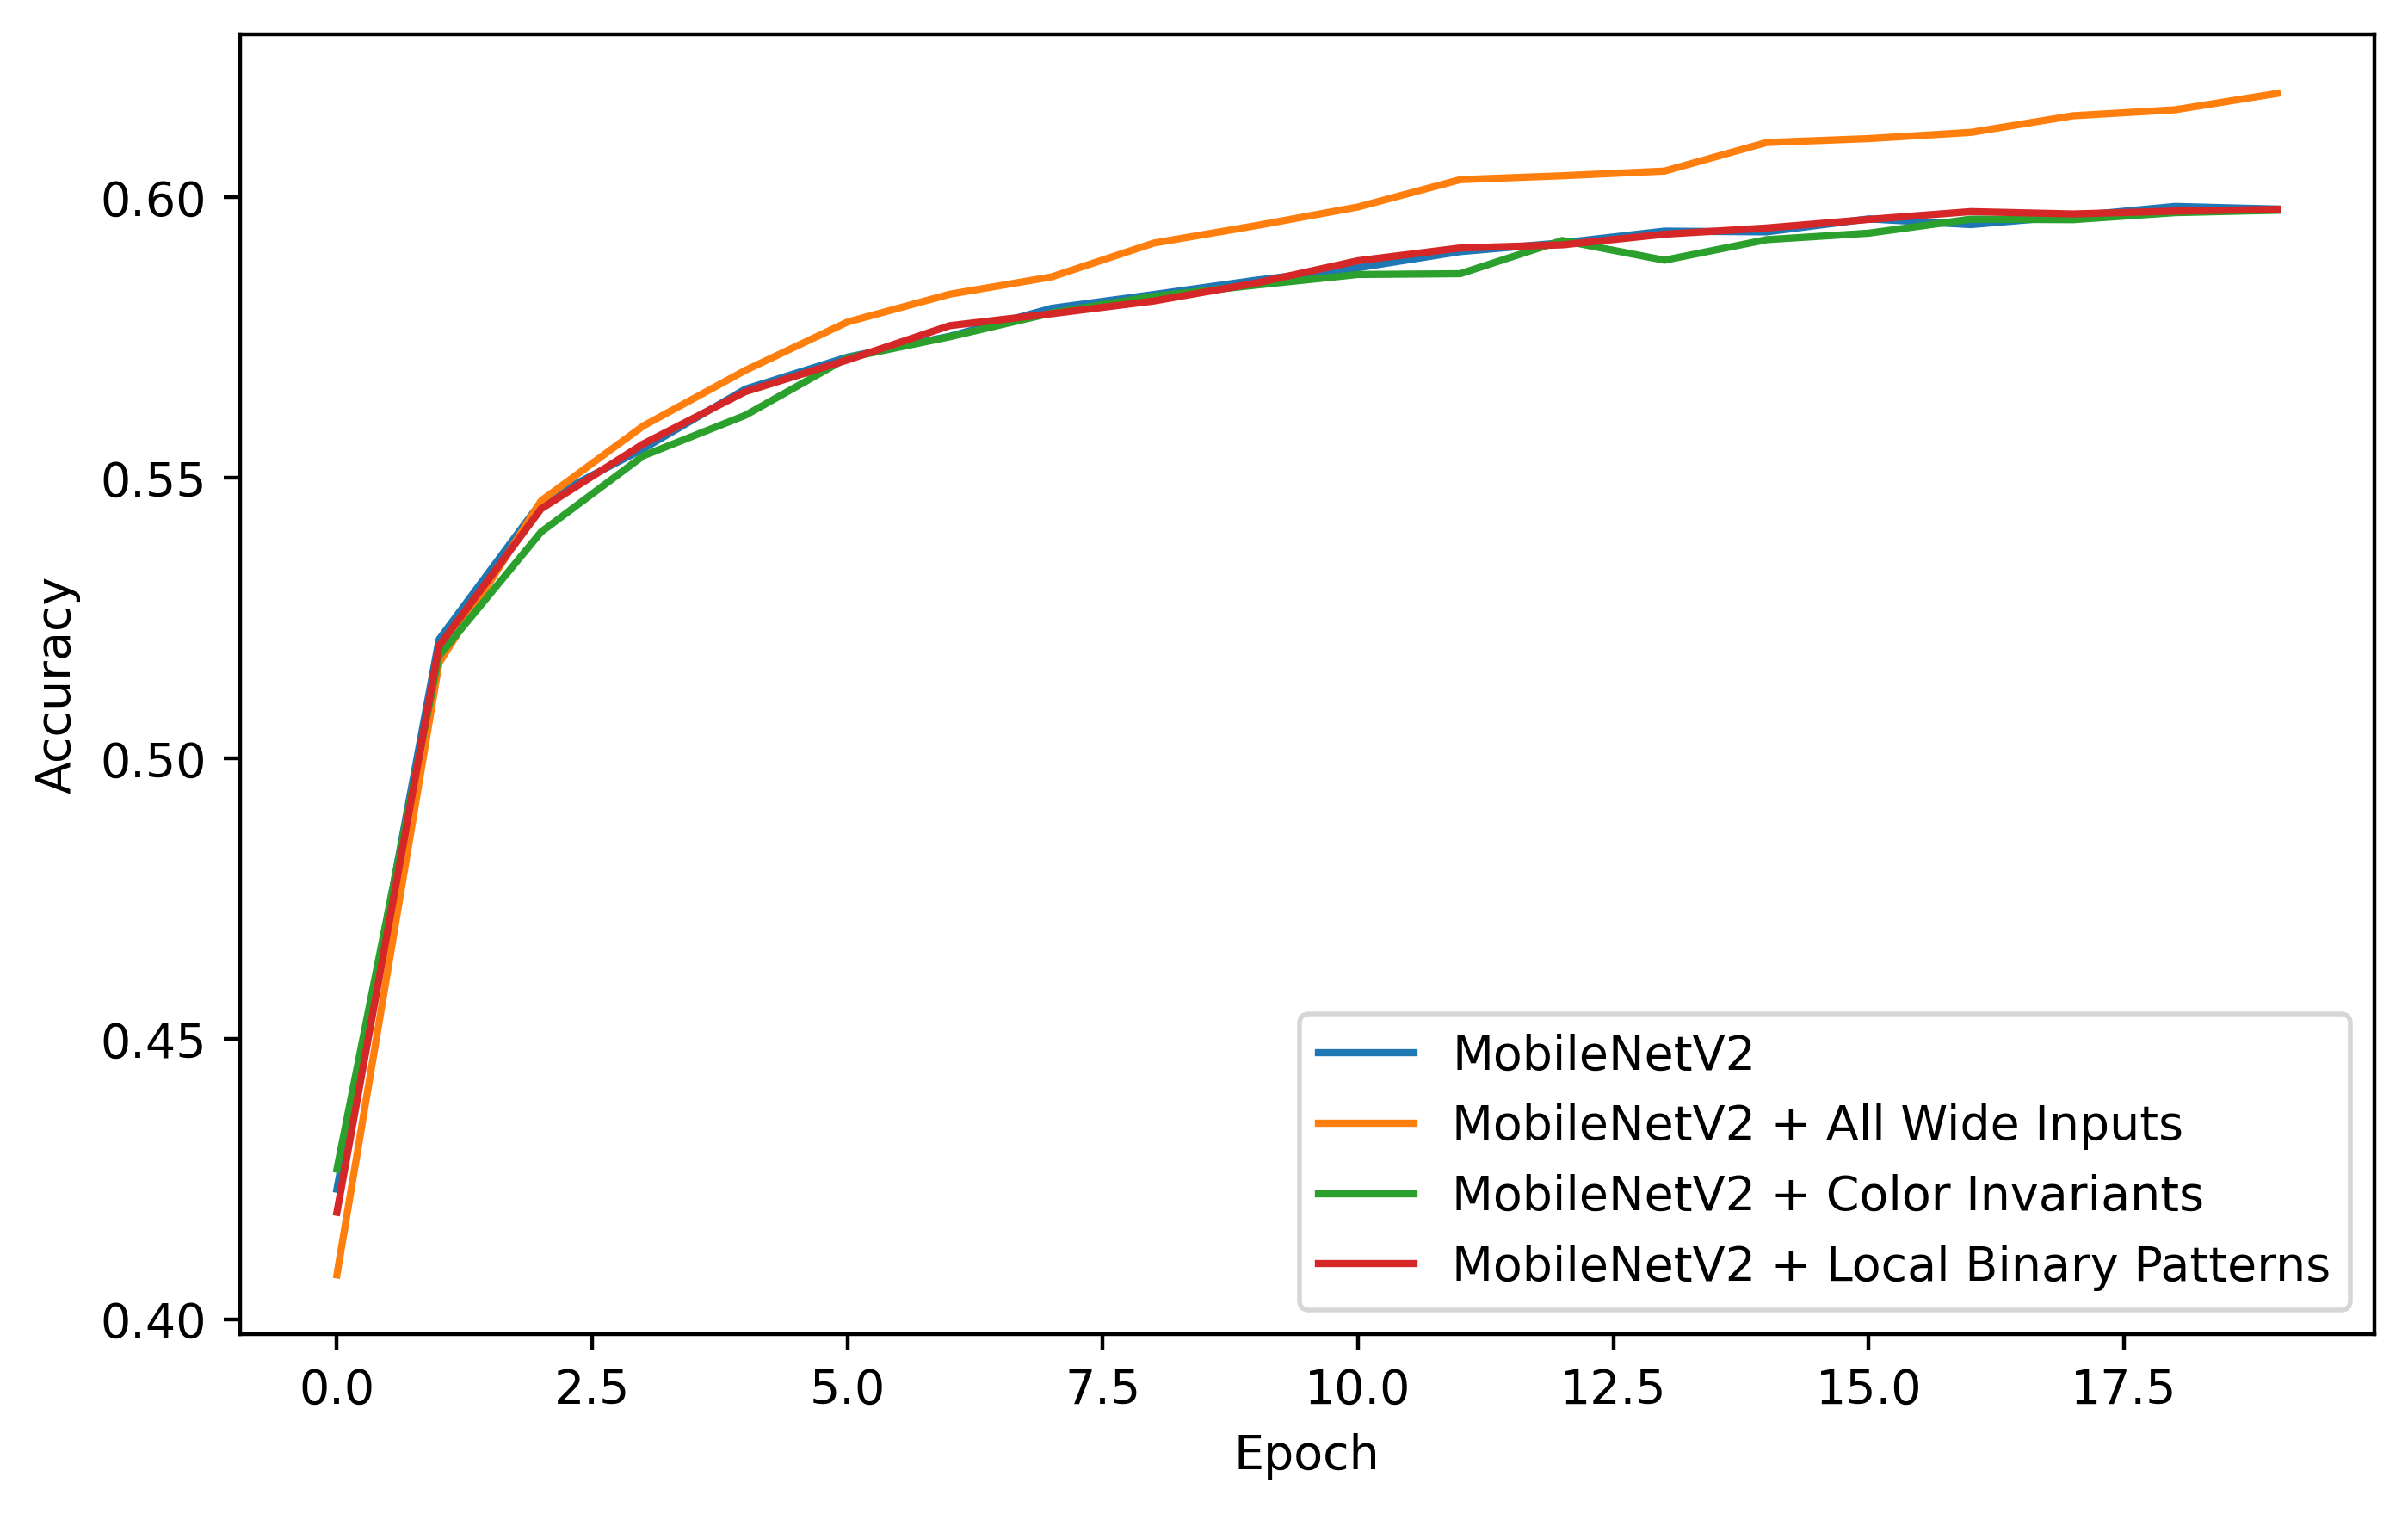

In [ ]:
plt.figure(figsize=(8, 5), dpi=400)
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.plot(history_MobileNetWIDE_model2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model3.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + All Wide Inputs', 'MobileNetV2 + Color Invariants',  'MobileNetV2 + Local Binary Patterns'], loc='lower right')

# **EfficientNetB0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

## 1st Experiment:

### EfficientNetB0 DL Only
- 
- Max accuracy xxx

In [ ]:
base_model = EfficientNetB0(weights= 'imagenet', include_top=False, input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation= 'softmax')(x)

efficientnetb0_model = Model(inputs = inputs, outputs = predictions)

efficientnetb0_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
efficientnetb0_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history_efficientnetb0_model = efficientnetb0_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = 64
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 226s 668ms/step - loss: 2.3209 - accuracy: 0.1072 - val_loss: 2.3211 - val_accuracy: 0.0935
Epoch 2/20
 21/338 [>.............................] - ETA: 2:04 - loss: 2.3132 - accuracy: 0.0997

KeyboardInterrupt: ignored

### EfficientNetB0 with wide inputs:
- 
- Max accuracy xxx

In [ ]:
efficientnetb0Wide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = EfficientNetB0(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

efficientnetb0Wide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

efficientnetb0Wide_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
efficientnetb0Wide_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_efficientnetb0Wide_model = efficientnetb0Wide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = 64
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
 11/338 [..............................] - ETA: 2:13 - loss: 2.3140 - accuracy: 0.1065

KeyboardInterrupt: ignored

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Results Graph Comparison

In [ ]:
plt.plot(history_efficientnetb0_model.history['accuracy'])
plt.plot(history_efficientnetb0Wide_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

----------------------------------
# **APRIL TESTS**


-------------------------------------


# **ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

## 1st Experiment:

### ResNet50 DL Only
- 
- Max accuracy 0.4126

In [ ]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation= 'softmax')(x)

ResNet50_model = Model(inputs = inputs, outputs = predictions)

ResNet50_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50_model.summary()

KeyboardInterrupt: ignored

In [ ]:
history_ResNet50_model = ResNet50_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = 64
                                #callbacks=[reduce_lr]
                                )

### ResNet50 with wide inputs:
- 
- Max accuracy 0.4361

In [ ]:
ResNet50wide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50wide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50wide_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
ResNet50wide_model.summary()

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50wide_model = ResNet50wide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = 64
                                            #callbacks = [reduce_lr]
                                            )
                                    

### Results Graph Comparison

In [ ]:
plt.plot(history_ResNet50_model.history['accuracy'])
plt.plot(history_ResNet50wide_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

# **SqueezeNet**

Wide Parameter **%0.7** better!

Source: https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=M3G-2aUBQJ-H

## DL Only

In [ ]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=input_shape)

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(y)

SqueezeNet_model = tf.keras.Model(x, y)

SqueezeNet_model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

#SqueezeNet_model.summary()

In [ ]:
history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = 64
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 41s 116ms/step - loss: 0.8609 - accuracy: 0.7102 - val_loss: 2.5536 - val_accuracy: 0.3802
Epoch 2/20
338/338 [==============================] - 39s 115ms/step - loss: 0.5587 - accuracy: 0.8088 - val_loss: 0.8133 - val_accuracy: 0.7231
Epoch 3/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4542 - accuracy: 0.8466 - val_loss: 0.7428 - val_accuracy: 0.7537
Epoch 4/20
338/338 [==============================] - 35s 104ms/step - loss: 0.3795 - accuracy: 0.8701 - val_loss: 0.7633 - val_accuracy: 0.7541
Epoch 5/20
338/338 [==============================] - 26s 78ms/step - loss: 0.3294 - accuracy: 0.8850 - val_loss: 0.5130 - val_accuracy: 0.8315
Epoch 6/20
338/338 [==============================] - 23s 68ms/step - loss: 0.2902 - accuracy: 0.9010 - val_loss: 0.5967 - val_accuracy: 0.8017
Epoch 7/20
338/338 [==============================] - 23s 67ms/step - loss: 0.2587 - accuracy: 0.9107 - val_loss: 0.6878 - val_accur

## With wide features:

In [ ]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

#Deep Inputs
x = tf.keras.layers.Input(shape=input_shape)
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Model design:
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])

merged_out = layers.Concatenate(axis=1)([merged_wide, y])

y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(merged_out)

SqueezeNet_Wide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     x],  outputs=y)
SqueezeNet_Wide_model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Wide_model = SqueezeNet_Wide_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 38s 111ms/step - loss: 0.8991 - accuracy: 0.7025 - val_loss: 1.3283 - val_accuracy: 0.5737
Epoch 2/20
338/338 [==============================] - 38s 113ms/step - loss: 0.5783 - accuracy: 0.7959 - val_loss: 0.6945 - val_accuracy: 0.7574
Epoch 3/20
338/338 [==============================] - 38s 113ms/step - loss: 0.4534 - accuracy: 0.8450 - val_loss: 0.7696 - val_accuracy: 0.7424
Epoch 4/20
338/338 [==============================] - 64s 190ms/step - loss: 0.3690 - accuracy: 0.8742 - val_loss: 0.5323 - val_accuracy: 0.8150
Epoch 5/20
338/338 [==============================] - 58s 171ms/step - loss: 0.3185 - accuracy: 0.8888 - val_loss: 0.7015 - val_accuracy: 0.7654
Epoch 6/20
338/338 [==============================] - 56s 167ms/step - loss: 0.2694 - accuracy: 0.9063 - val_loss: 0.5191 - val_accuracy: 0.8244
Epoch 7/20
338/338 [==============================] - 45s 133ms/step - loss: 0.2388 - accuracy: 0.9185 - val_loss: 0.5466 - val_ac

### Results Graphs Comparison

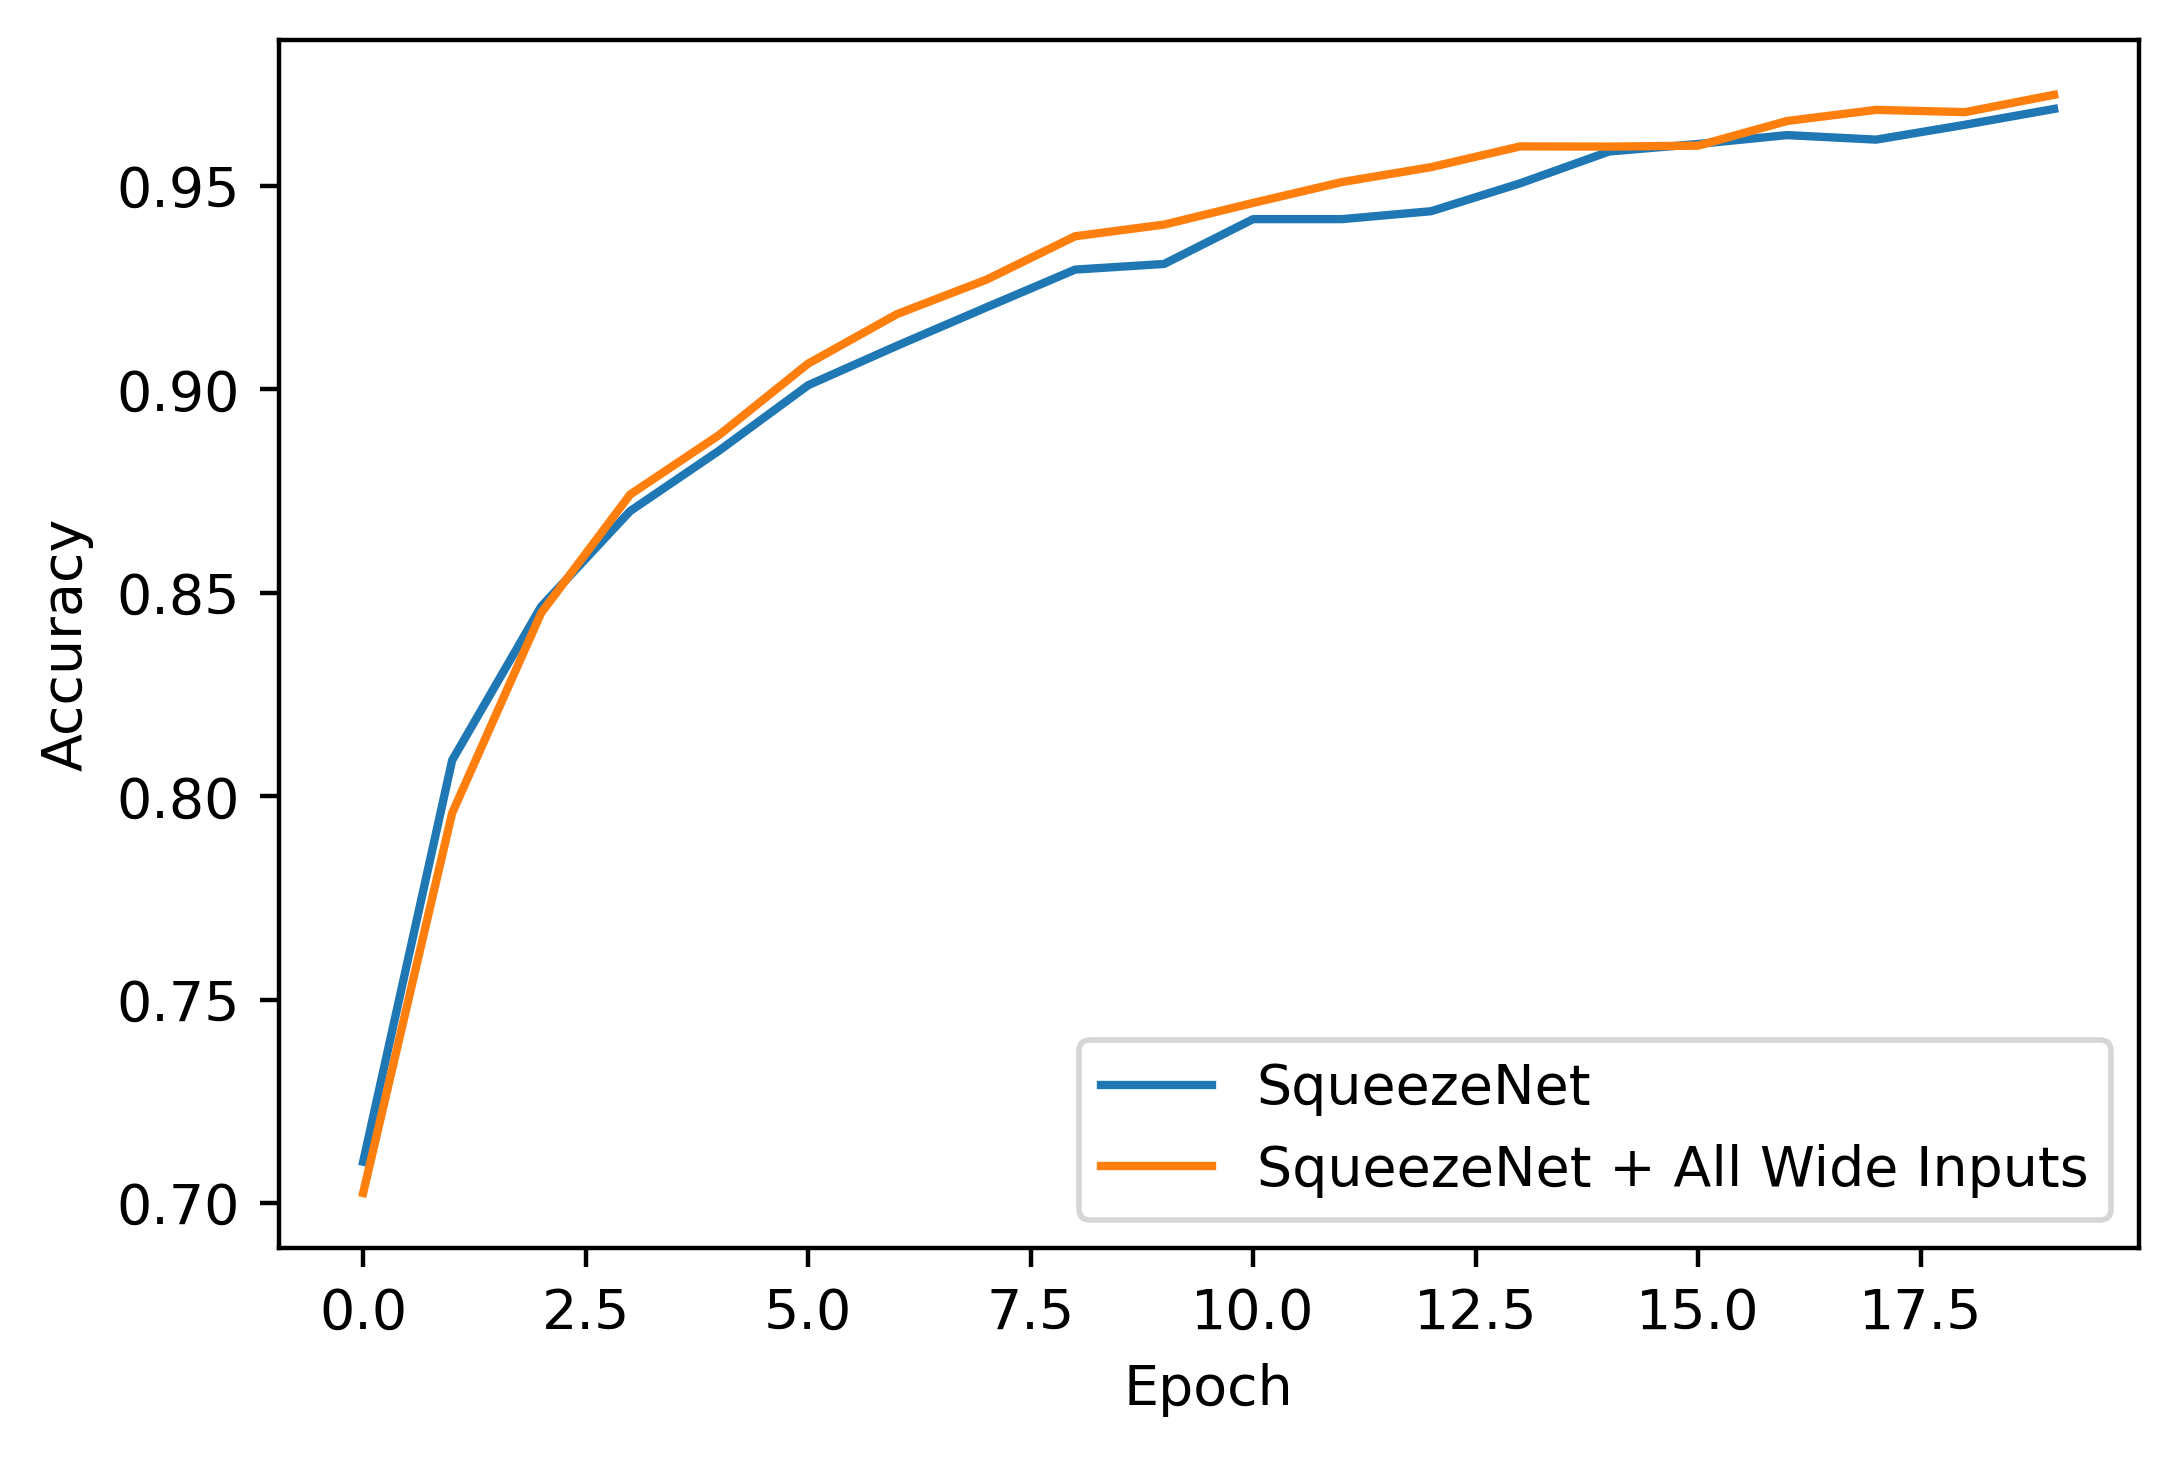

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Wide_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

# **SqueezeNet Test2**
No performance gain

Source: https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=M3G-2aUBQJ-H

In [ ]:
epochs = 30
batch_size = 128
bnmomemtum=0.9
optimizer = "Nadam"

## DL Only

In [ ]:
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=input_shape)

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(y)

SqueezeNet_model = tf.keras.Model(x, y)

SqueezeNet_model.compile(
  optimizer=optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

#SqueezeNet_model.summary()

In [ ]:
history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
169/169 [==============================] - 59s 344ms/step - loss: 0.8502 - accuracy: 0.7128 - val_loss: 1.0520 - val_accuracy: 0.6343
Epoch 2/30
169/169 [==============================] - 57s 334ms/step - loss: 0.5039 - accuracy: 0.8257 - val_loss: 0.5962 - val_accuracy: 0.7950
Epoch 3/30
169/169 [==============================] - 58s 344ms/step - loss: 0.4027 - accuracy: 0.8603 - val_loss: 0.7314 - val_accuracy: 0.7615
Epoch 4/30
169/169 [==============================] - 56s 329ms/step - loss: 0.3171 - accuracy: 0.8918 - val_loss: 0.9742 - val_accuracy: 0.6950
Epoch 5/30
169/169 [==============================] - 58s 341ms/step - loss: 0.2741 - accuracy: 0.9053 - val_loss: 1.5439 - val_accuracy: 0.6254
Epoch 6/30
169/169 [==============================] - 97s 573ms/step - loss: 0.2314 - accuracy: 0.9204 - val_loss: 0.6720 - val_accuracy: 0.7954
Epoch 7/30
169/169 [==============================] - 58s 344ms/step - loss: 0.2073 - accuracy: 0.9265 - val_loss: 0.8236 - val_ac

## With wide features:

In [ ]:

def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

#Deep Inputs
x = tf.keras.layers.Input(shape=input_shape)
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Model design:
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])

merged_out = layers.Concatenate(axis=1)([merged_wide, y])

y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(merged_out)

SqueezeNet_Wide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     x],  outputs=y)
SqueezeNet_Wide_model.compile(
  optimizer=optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Wide_model = SqueezeNet_Wide_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 50s 147ms/step - loss: 0.8848 - accuracy: 0.7095 - val_loss: 1.0044 - val_accuracy: 0.6709
Epoch 2/30
338/338 [==============================] - 49s 144ms/step - loss: 0.5285 - accuracy: 0.8192 - val_loss: 1.3982 - val_accuracy: 0.5404
Epoch 3/30
338/338 [==============================] - 49s 146ms/step - loss: 0.4026 - accuracy: 0.8627 - val_loss: 1.2630 - val_accuracy: 0.6517
Epoch 4/30
338/338 [==============================] - 49s 144ms/step - loss: 0.3358 - accuracy: 0.8878 - val_loss: 0.3776 - val_accuracy: 0.8741
Epoch 5/30
338/338 [==============================] - 49s 144ms/step - loss: 0.2869 - accuracy: 0.8994 - val_loss: 1.2108 - val_accuracy: 0.6276
Epoch 6/30
338/338 [==============================] - 49s 145ms/step - loss: 0.2590 - accuracy: 0.9105 - val_loss: 0.8140 - val_accuracy: 0.7450
Epoch 7/30
338/338 [==============================] - 49s 145ms/step - loss: 0.2181 - accuracy: 0.9252 - val_loss: 0.4490 - val_accuracy: 0.8

## Results Graphs Comparison

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Wide_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

NameError: ignored

<Figure size 2400x1600 with 0 Axes>

In [ ]:
epochs = 25

from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = input_shape

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)
    return model

In [ ]:
model_SqueezeNet_test2 = SqueezeNet(weights= None, classes = 10, use_bn_on_input = True, input_shape= (input_shape))

for layer in model_SqueezeNet_test2.layers:
    layer.trainable = False

model_SqueezeNet_test2.compile(optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model_test2 = model_SqueezeNet_test2.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = 64
                                )

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 31s 90ms/step - loss: 2.3026 - accuracy: 0.0929 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 2/25
338/338 [==============================] - 24s 72ms/step - loss: 2.3026 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 3/25
338/338 [==============================] - 27s 79ms/step - loss: 2.3026 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 4/25
338/338 [==============================] - 27s 81ms/step - loss: 2.3026 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 5/25
338/338 [==============================] - 22s 64ms/step - loss: 2.3026 - accuracy: 0.0944 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 6/25
338/338 [==============================] - 16s 48ms/step - loss: 2.3026 - accuracy: 0.0971 - val_loss: 2.3026 - val_accuracy: 0.0898
Epoch 7/25
338/338 [==============================] - 16s 47ms/step - loss: 2.3026 - accuracy: 0.0962 - val_loss: 2.3026 - val_accuracy: 0.0898
Epo

# **SqueezeNet Test with FREEZED! ImageNet Weigths**

Source: https://github.com/chasingbob/squeezenet-keras/blob/master/model.py

In [ ]:
batch_size = 64
optimizer = "Adam"
epochs = 20

## Model Definition

In [ ]:
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs #https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
from tensorflow.keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture."""
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    input_shape = input_shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

        #x = Dense(10, activation= 'softmax')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model

## DL only
Epoch 20/20
338/338 [==============================] - 26s 78ms/step - loss: 0.9790 - accuracy: 0.6515 - val_loss: 0.9870 - val_accuracy: 0.6500

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image


In [ ]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)
base_model.trainable = False
inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

predictions = Dense(10, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                )

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 squeezenet (Functional)     (None, 512)               722496    
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 727,626
Trainable params: 5,130
Non-trainable params: 722,496
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 35s 103ms/step - loss: 1.7904 - accuracy: 0.3977 - val_loss: 1.5077 - val_accuracy: 0.4706
Epoch 2/20
338/338 [==============================] - 34s 102ms/step - loss: 1.4064 - accuracy: 0.5203 - val_loss: 1.3268 - val_accuracy: 0.5181
Epoch 3/20
338/338 [==============================] - 54s 161ms/step - loss: 1.2803 - accuracy: 0.5601 - val_loss: 1.2408 - val_accuracy: 0.5922
Epoch 4/20
338/338 [==============================] - 51s 150ms/step - loss: 1.2134 - accuracy: 0.5744 - val_loss: 1.1881 - val_accuracy: 0.5815
Epoch 5/20
338/338 [==============================] - 51s 150ms/step - loss: 1.1701 - accuracy: 0.5860 - val_loss: 1.1560 - val_accuracy: 0.6111
Epoch 6/20
338/338 [==============================] - 50s 149ms/step - loss: 1.1382 - accuracy: 0.5979 - val_loss: 1.1275 - val_accuracy: 0.5906
Epoch 7/20
338/338 [==============================] - 57s 168ms/step - loss: 1.1132 - accuracy: 0.6057 - val_loss: 1.1077 - val_ac

## Wide:
Epoch 20/20
338/338 [==============================] - 36s 108ms/step - loss: 0.9550 - accuracy: 0.6624 - val_loss: 0.9580 - val_accuracy: 0.6626

In [ ]:
SqueezeNetwide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

SqueezeNetwide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

SqueezeNetwide_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Widemodel  = SqueezeNetwide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = batch_size
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 60s 177ms/step - loss: 1.7750 - accuracy: 0.4200 - val_loss: 1.4906 - val_accuracy: 0.4794
Epoch 2/20
338/338 [==============================] - 55s 164ms/step - loss: 1.3998 - accuracy: 0.5188 - val_loss: 1.3169 - val_accuracy: 0.5654
Epoch 3/20
338/338 [==============================] - 59s 176ms/step - loss: 1.2735 - accuracy: 0.5651 - val_loss: 1.2402 - val_accuracy: 0.5713
Epoch 4/20
338/338 [==============================] - 60s 176ms/step - loss: 1.2087 - accuracy: 0.5794 - val_loss: 1.1815 - val_accuracy: 0.5874
Epoch 5/20
338/338 [==============================] - 59s 175ms/step - loss: 1.1631 - accuracy: 0.5909 - val_loss: 1.1428 - val_accuracy: 0.6202
Epoch 6/20
338/338 [==============================] - 58s 173ms/step - loss: 1.1301 - accuracy: 0.6040 - val_loss: 1.1178 - val_accuracy: 0.6035
Epoch 7/20
338/338 [==============================] - 58s 171ms/step - loss: 1.1043 - accuracy: 0.6093 - val_loss: 1.1007 - val_ac

## Results Graphs Comparison

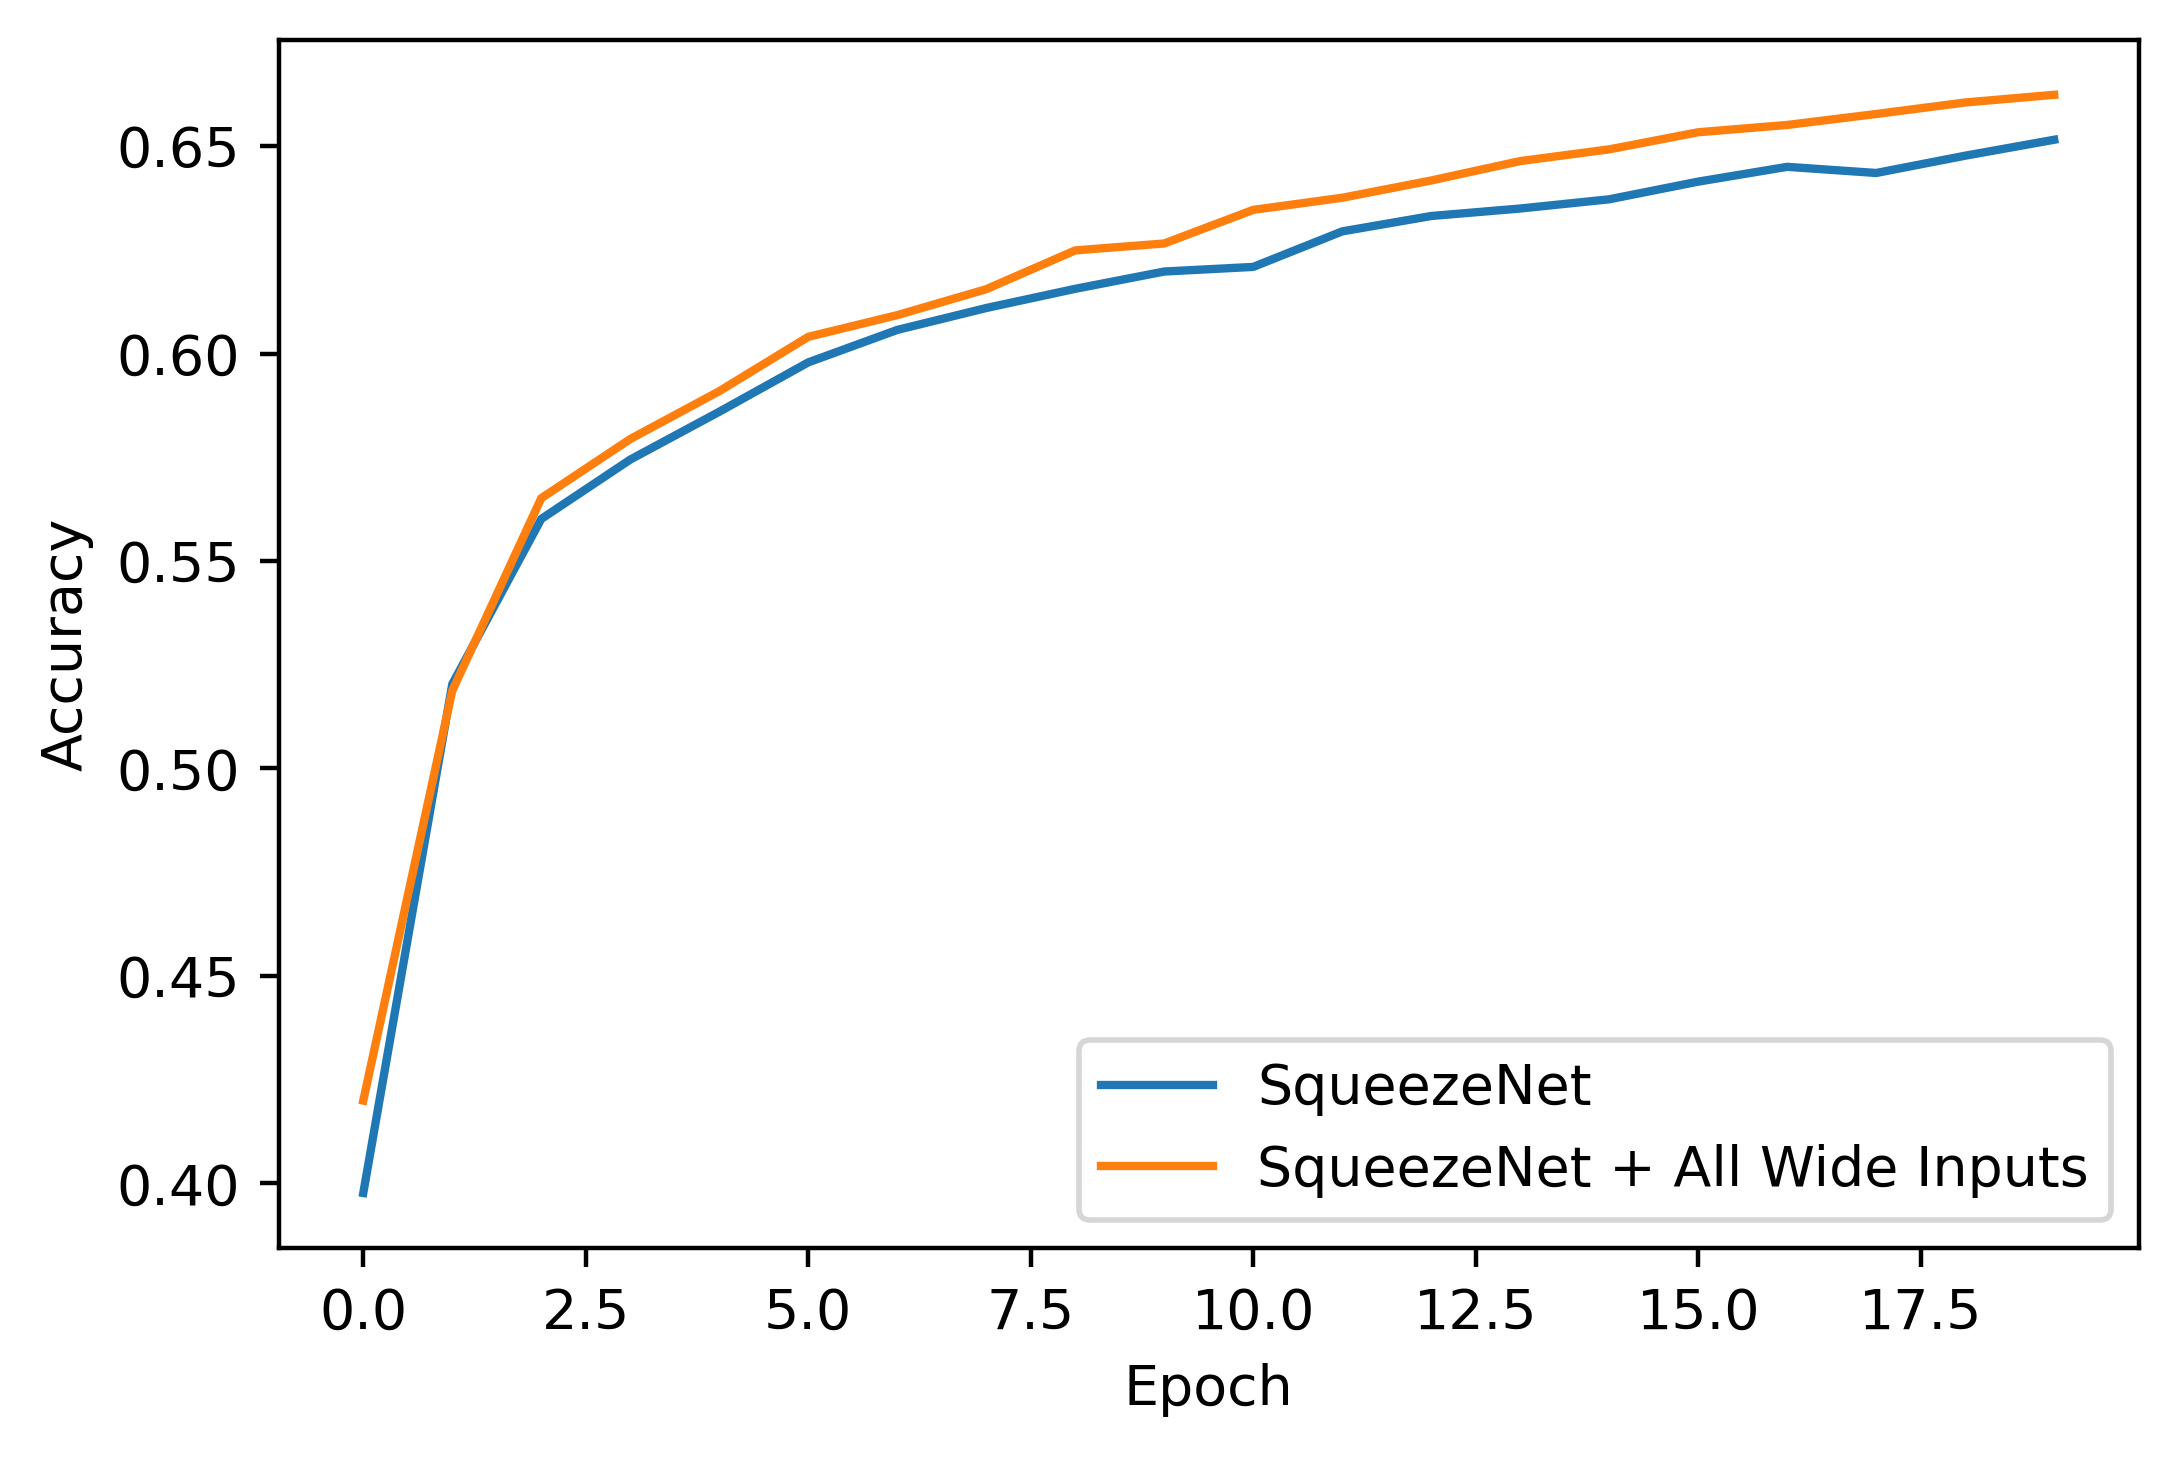

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Widemodel.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
ypred = SqueezeNet_model.predict(x_test, verbose=1)
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

  3/169 [..............................] - ETA: 6s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 6s 37ms/step


In [ ]:

ypred = SqueezeNetwide_model.predict(GLCMdata_valMerged, verbose=1)
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T

df['support'] = df.support.apply(int)

df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

  1/169 [..............................] - ETA: 13s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 7s 40ms/step


# **SqueezeNet Test with NOT FREEZED! ImageNet Weigths**

- No performance difference exist.

Source: https://github.com/chasingbob/squeezenet-keras/blob/master/model.py

In [ ]:
batch_size = 64
optimizer = "Adam"
epochs = 50

## Model Definition

In [ ]:
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs #https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
from tensorflow.keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture."""
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    input_shape = input_shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

        #x = Dense(10, activation= 'softmax')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model

## DL only
accuracy: 0.9762

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image


In [ ]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

#x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                )

3047424/3032184 [==============================] - 0s 0us/step
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_114 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 squeezenet (Functional)     (None, 512)               722496    
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 727,626
Trainable params: 727,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 50s 146ms/step - loss: 0.7968 - accuracy: 0.7149 - val_loss: 0.5446 - val_accuracy: 0.8185
Epoch 2/50
338/338 [==============================] - 48s 142ms/step - loss: 0.4619 - accuracy: 0.8410 - val_loss: 0.5193 - val_accuracy: 0.8324
Epoch 3/50
338/338 [==============================] - 48s 143ms/step - loss: 0.4237 - accuracy: 0.8546 - val_loss: 0.4014 - val_accuracy: 0.8650
Epoch 4/50
338/338 [==============================] - 55s 163ms/step - loss: 0.3453 - accuracy: 0.8826 - val_loss: 0.3310 - val_accuracy: 0.8891
Epoch 5/50
338/338 [==============================] - 36s 107ms/step - loss: 0.3322 - accuracy: 0.8876 - val_loss: 0.3841 - val_accuracy: 0.8763
Epoch 6/50
338/338 [==============================] - 34s 100ms/step - loss: 0.2888 - accuracy: 0.9035 - val_loss: 0.4084 - val_accuracy: 0.8667
Epoch 7/50
338/338 [==============================] - 35s 105ms/step - loss: 0.2803 - accuracy: 0.9061 - val_loss: 0.3725 - val_accuracy: 0.8

## Wide:

accuracy: 0.9751

In [ ]:
SqueezeNetwide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)

merged_deep = base_model(wideInputD, training=False)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

SqueezeNetwide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

SqueezeNetwide_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Widemodel  = SqueezeNetwide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = batch_size
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
338/338 [==============================] - 72s 212ms/step - loss: 0.8435 - accuracy: 0.6954 - val_loss: 0.5224 - val_accuracy: 0.8224
Epoch 2/50
338/338 [==============================] - 76s 224ms/step - loss: 0.5126 - accuracy: 0.8233 - val_loss: 0.4530 - val_accuracy: 0.8493
Epoch 3/50
338/338 [==============================] - 72s 214ms/step - loss: 0.4224 - accuracy: 0.8576 - val_loss: 0.4198 - val_accuracy: 0.8559
Epoch 4/50
338/338 [==============================] - 53s 155ms/step - loss: 0.3777 - accuracy: 0.8737 - val_loss: 0.4113 - val_accuracy: 0.8644
Epoch 5/50
338/338 [==============================] - 49s 145ms/step - loss: 0.3260 - accuracy: 0.8882 - val_loss: 0.3788 - val_accuracy: 0.8665
Epoch 6/50
338/338 [==============================] - 49s 144ms/step - loss: 0.3236 - accuracy: 0.8920 - val_loss: 0.3543 - val_accuracy: 0.8828
Epoch 7/50
338/338 [==============================] - 59s 176ms/step - loss: 0.2713 - accuracy: 0.9092 - val_loss: 0.4502 - val_ac

## Results Graphs Comparison

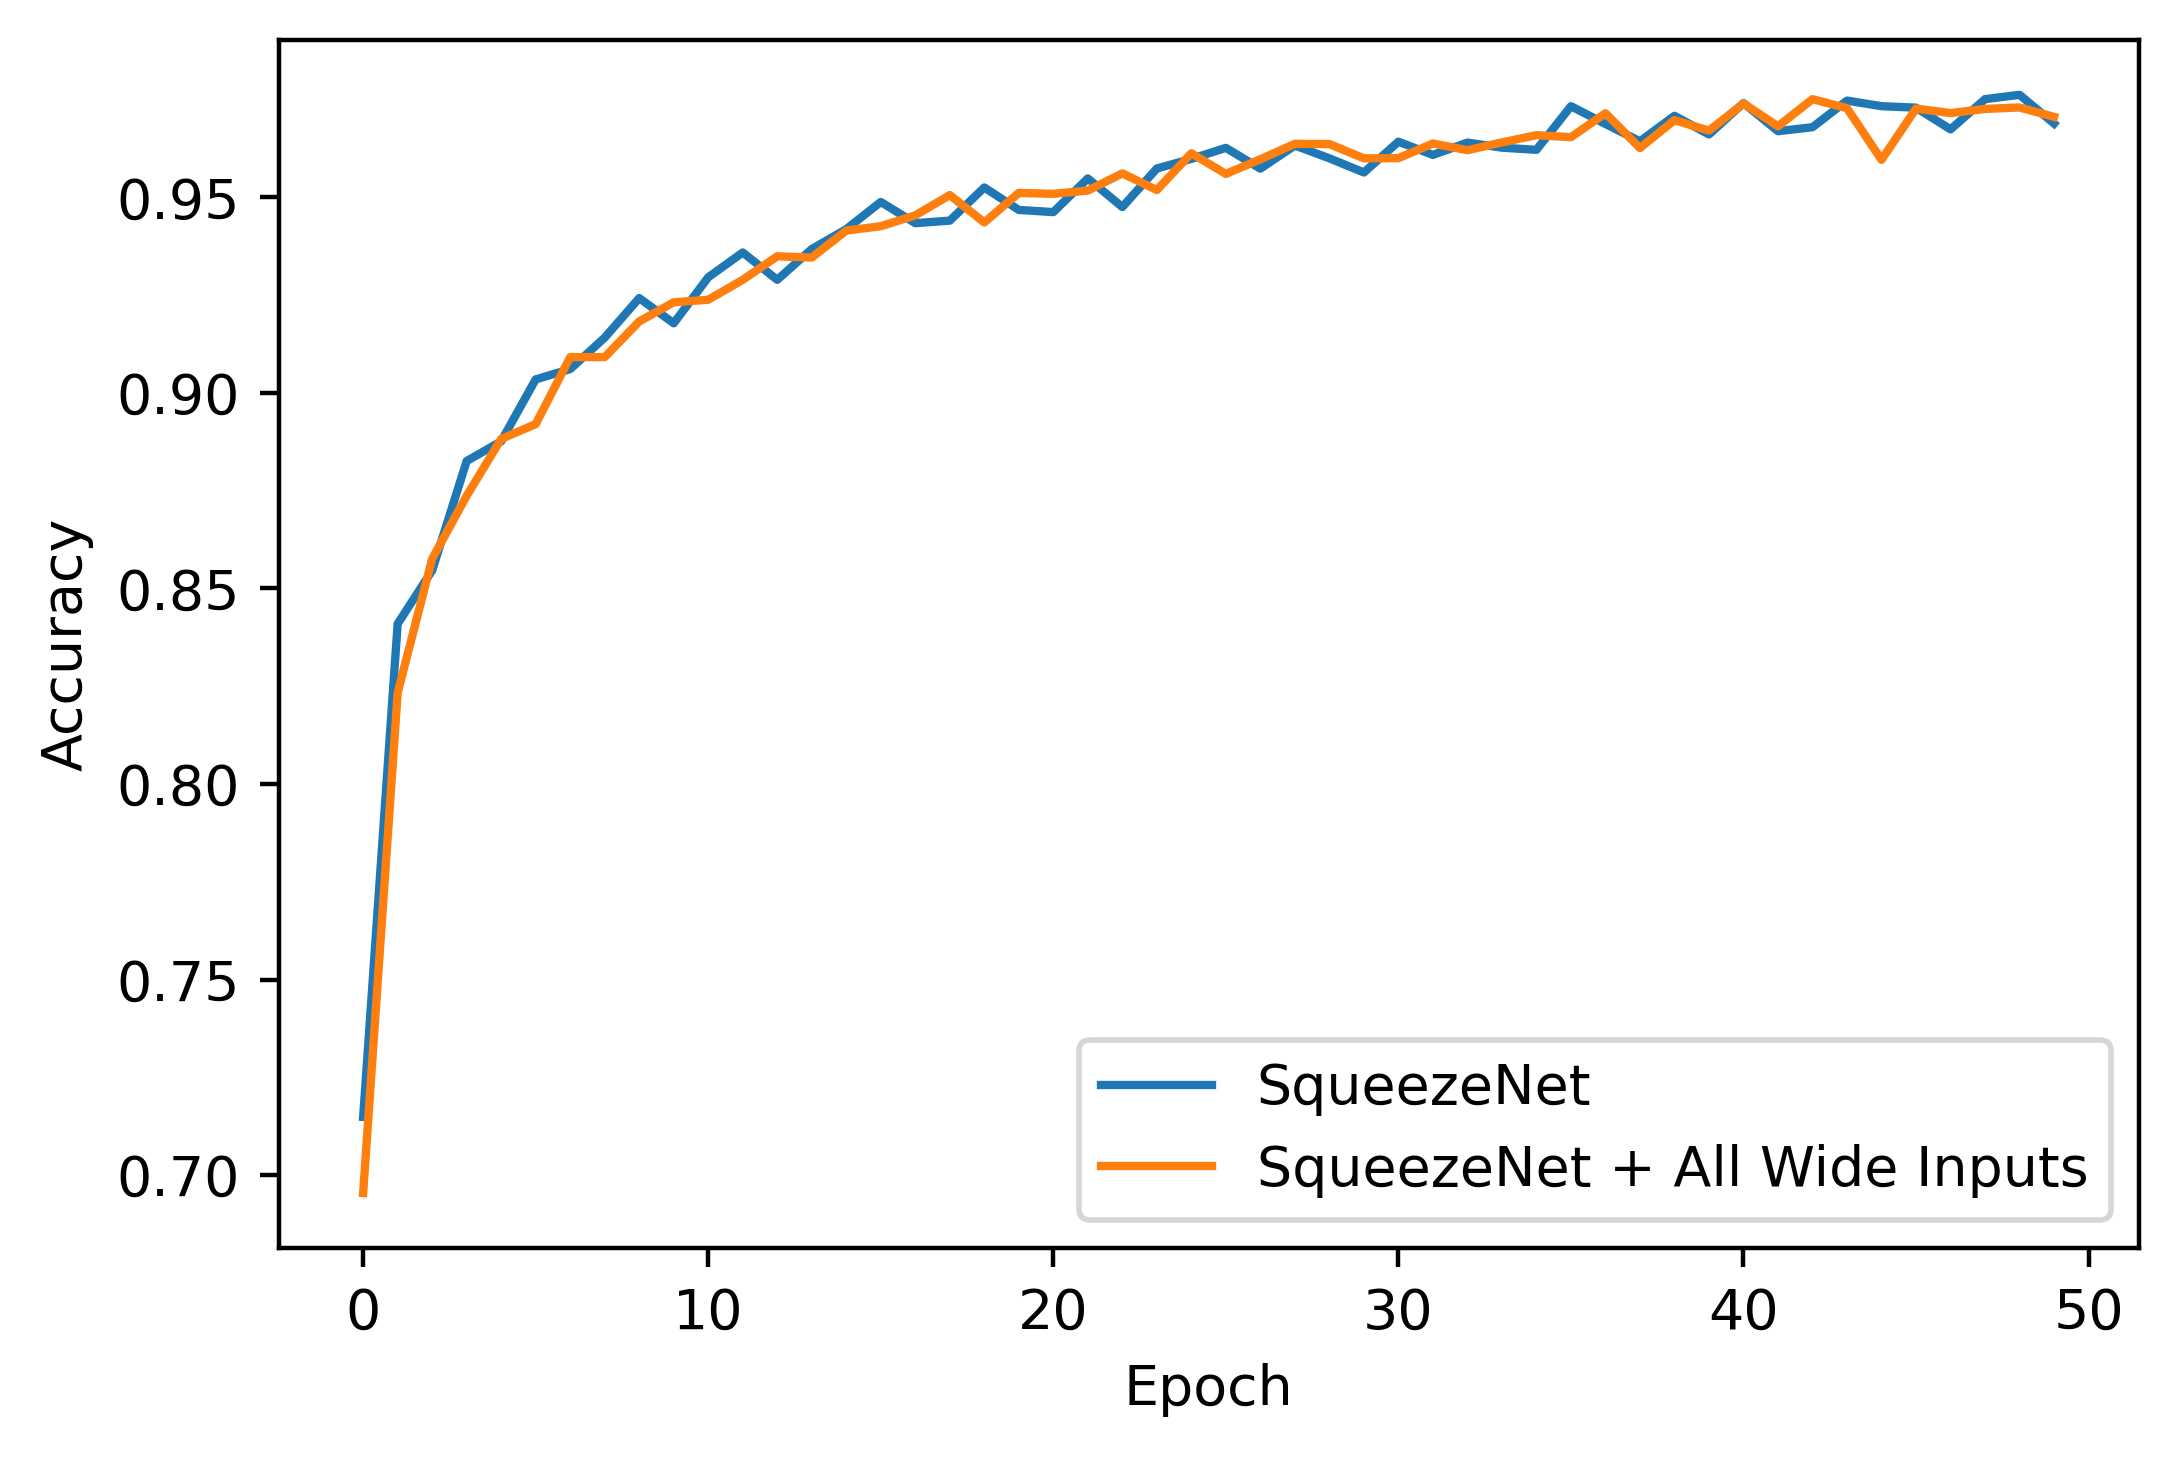

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Widemodel.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

# **MobileNetV2 TestV4**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
epochsMobile = 50

### MobileNet DL Only

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
#inputs = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
#inputs = layers.experimental.preprocessing.RandomRotation(0.15)(inputs)
#inputs = layers.experimental.preprocessing.RandomContrast(0.2)(inputs)

x = base_model(inputs, training=False)
x = Flatten()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNet_model = Model(inputs = inputs, outputs = predictions)

MobileNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
history_MobileNetV2 = MobileNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochsMobile,
                                batch_size=64
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
338/338 [==============================] - 58s 171ms/step - loss: 1.9523 - accuracy: 0.4108 - val_loss: 1.7018 - val_accuracy: 0.4830
Epoch 2/50
338/338 [==============================] - 59s 176ms/step - loss: 1.5658 - accuracy: 0.5185 - val_loss: 1.4743 - val_accuracy: 0.5274
Epoch 3/50
338/338 [==============================] - 65s 193ms/step - loss: 1.4044 - accuracy: 0.5447 - val_loss: 1.3650 - val_accuracy: 0.5424
Epoch 4/50
338/338 [==============================] - 60s 176ms/step - loss: 1.3201 - accuracy: 0.5581 - val_loss: 1.3039 - val_accuracy: 0.5550
Epoch 5/50
338/338 [==============================] - 46s 136ms/step - loss: 1.2695 - accuracy: 0.5650 - val_loss: 1.2636 - val_accuracy: 0.5589
Epoch 6/50
338/338 [==============================] - 38s 112ms/step - loss: 1.2354 - accuracy: 0.5732 - val_loss: 1.2370 - val_accuracy: 0.5631
Epoch 7/50
338/338 [==============================] - 38s 112ms/step - loss: 1.2112 - accuracy: 0.5781 - val_loss: 1.2179 - val_ac

### MobileNet with wide inputs:


In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape = (input_shape))
base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetWIDE_model = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochsMobile,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=64
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 38s 112ms/step - loss: 1.9294 - accuracy: 0.4053 - val_loss: 1.6712 - val_accuracy: 0.4965
Epoch 2/50
338/338 [==============================] - 38s 111ms/step - loss: 1.5369 - accuracy: 0.5223 - val_loss: 1.4507 - val_accuracy: 0.5194
Epoch 3/50
338/338 [==============================] - 38s 111ms/step - loss: 1.3800 - accuracy: 0.5459 - val_loss: 1.3412 - val_accuracy: 0.5483
Epoch 4/50
338/338 [==============================] - 38s 113ms/step - loss: 1.2988 - accuracy: 0.5608 - val_loss: 1.2840 - val_accuracy: 0.5589
Epoch 5/50
338/338 [==============================] - 38s 112ms/step - loss: 1.2499 - accuracy: 0.5697 - val_loss: 1.2492 - val_accuracy: 0.5596
Epoch 6/50
338/338 [==============================] - 38s 112ms/step - loss: 1.2156 - accuracy: 0.5765 - val_loss: 1.2170 - val_accuracy: 0.5731
Epoch 7/50
338/338 [==============================] - 38s 112ms/step - loss: 1.1906 - accuracy: 0.5839 - val_loss: 1.2026 - val_accuracy: 0.5

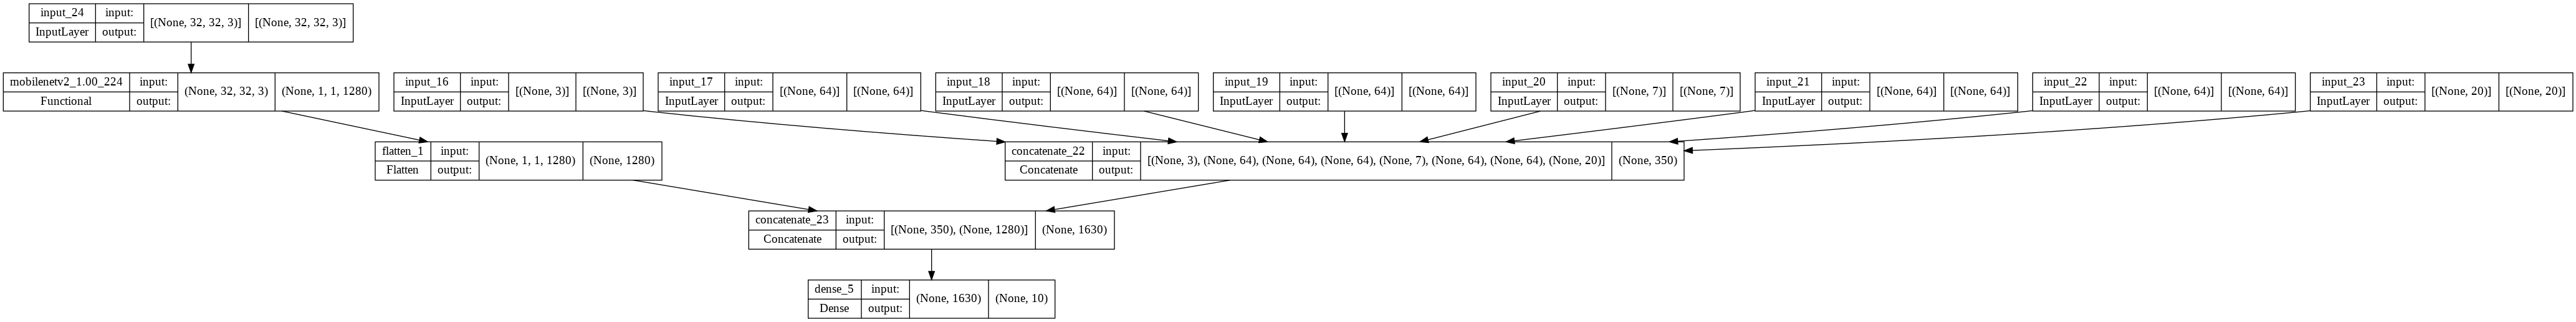

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetWIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

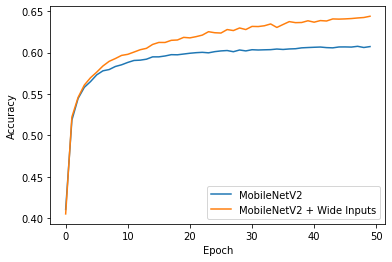

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

### Results Graphs Comparison

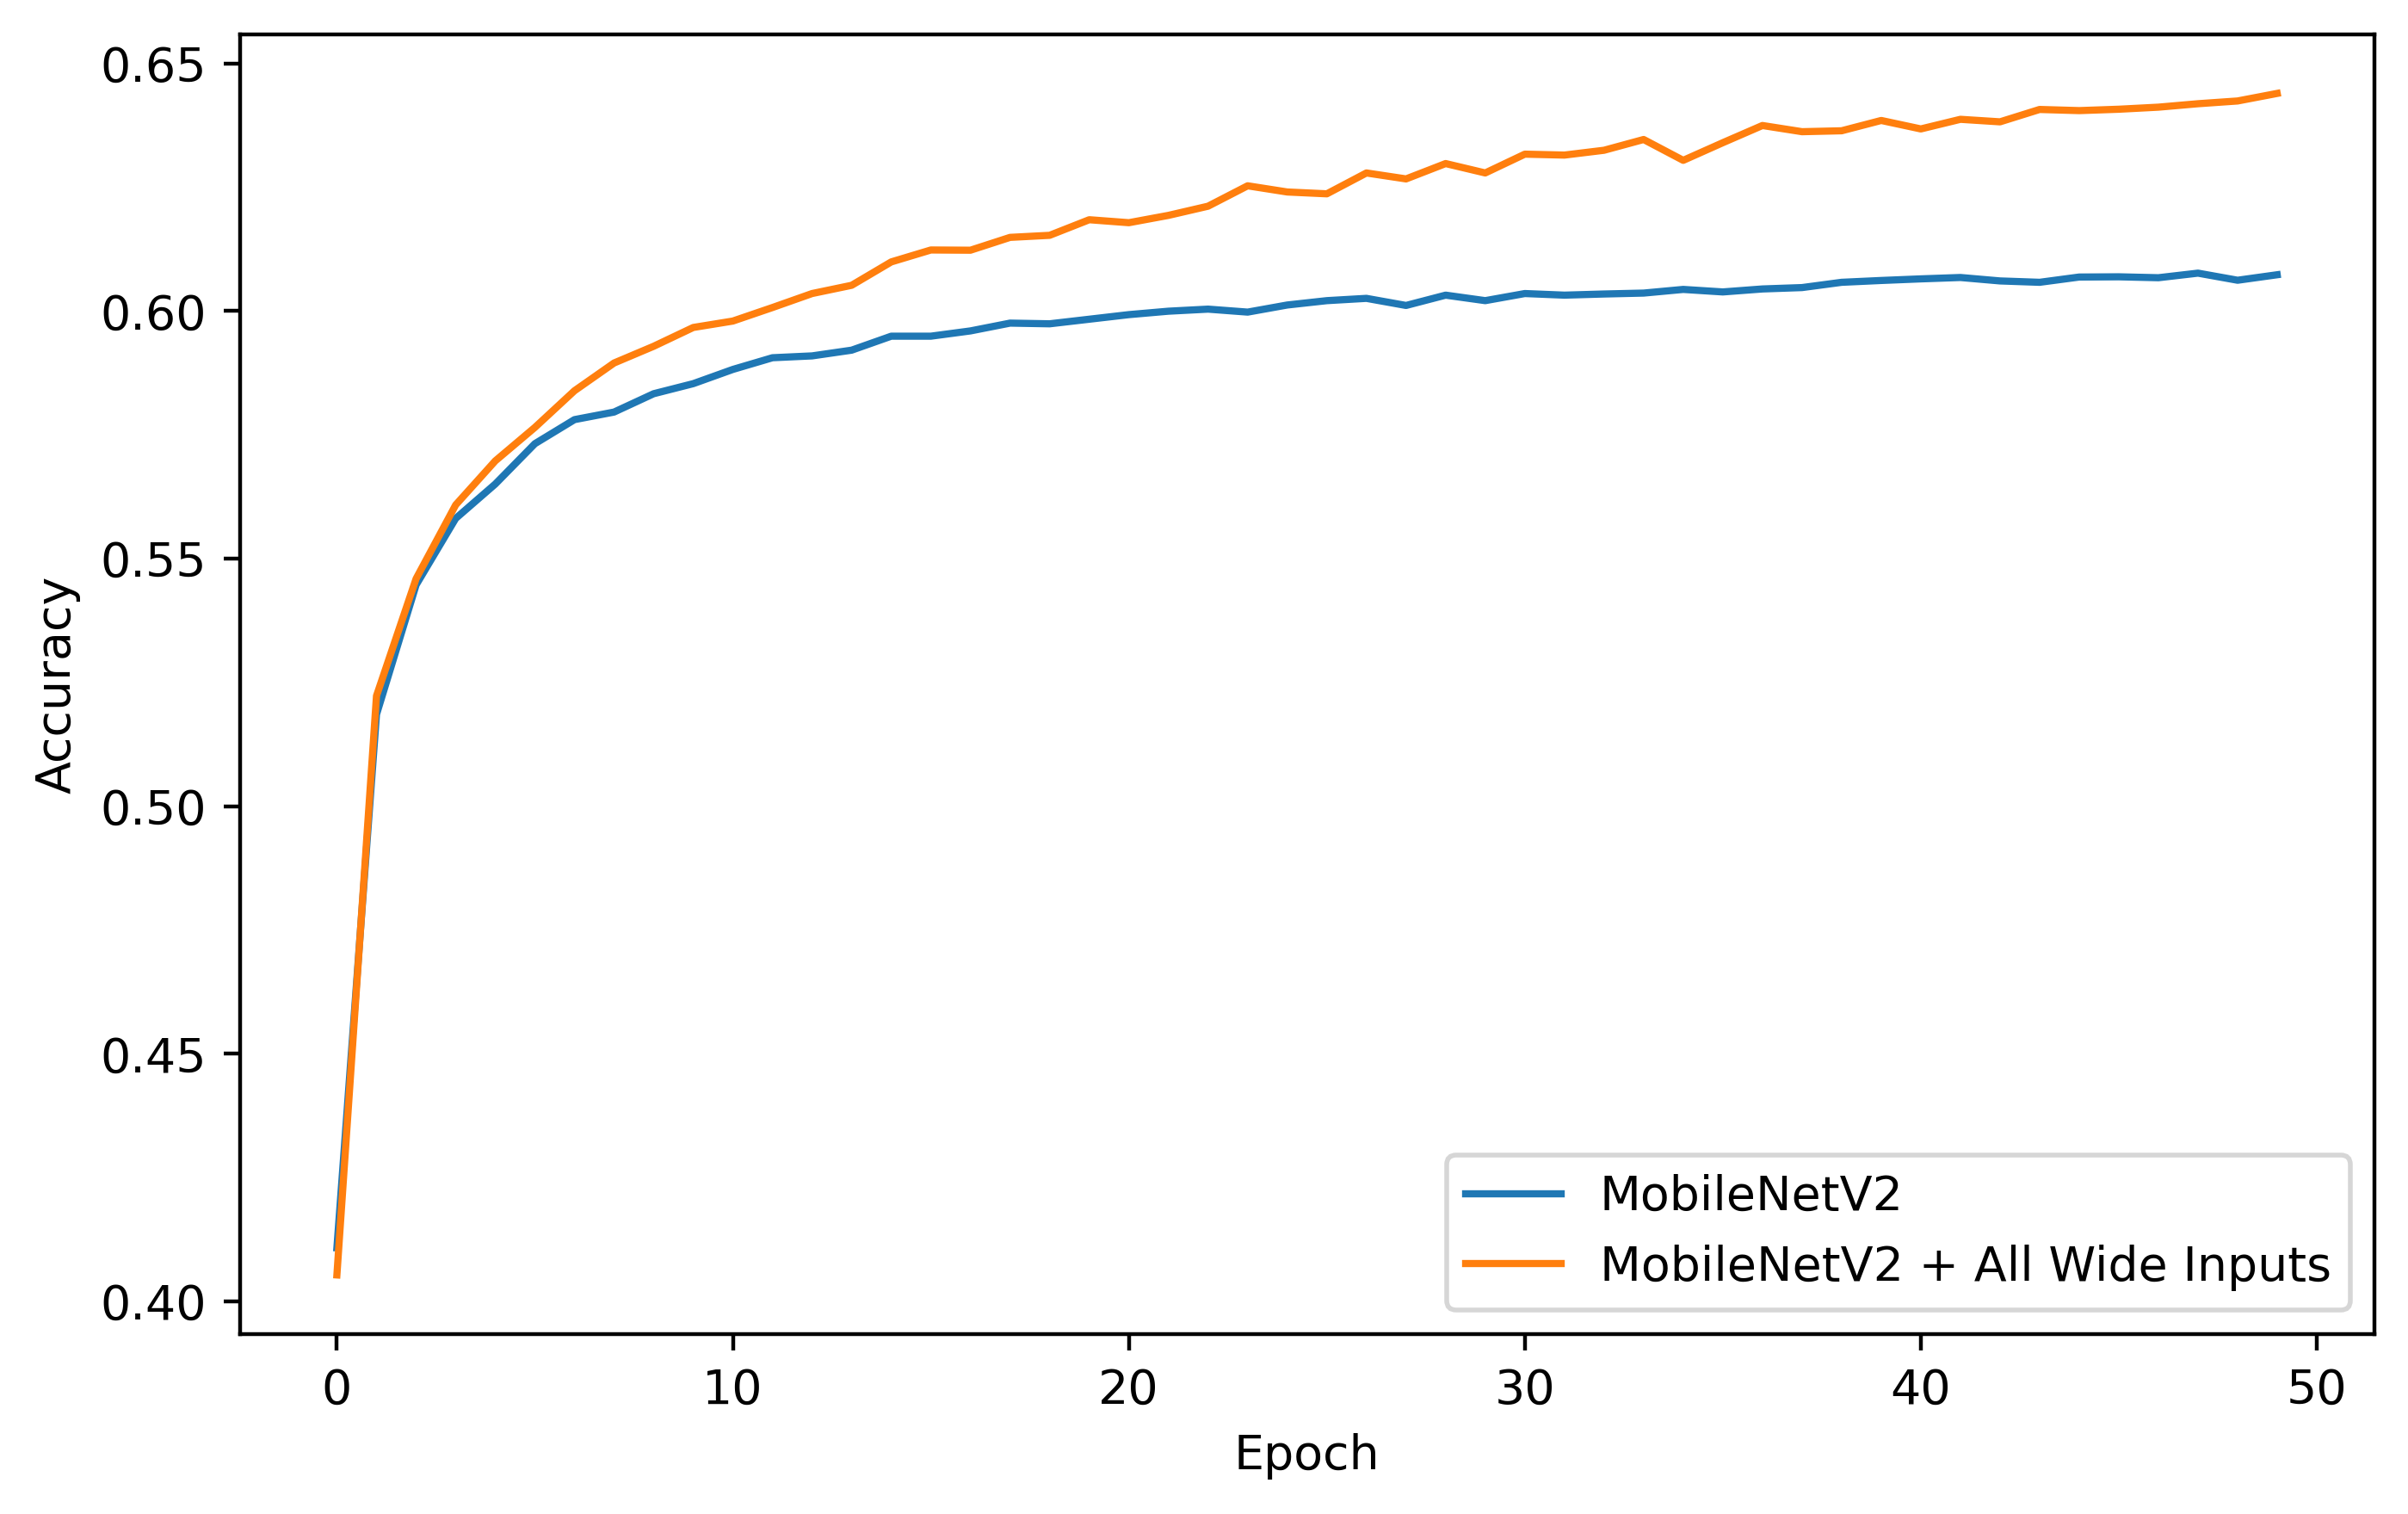

In [ ]:
plt.figure(figsize=(8, 5), dpi=400)
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + All Wide Inputs'], loc='lower right')

# **DenseNet201**

In [ ]:
from tensorflow.keras.applications import DenseNet201
batch_size = 64
optimizer = "adam"
epochs = 50

## DL Only

In [ ]:
base_model = DenseNet201(weights= 'imagenet', include_top=False, input_shape= (input_shape))
inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

effnetb0_model = Model(inputs = inputs, outputs = predictions)

effnetb0_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

effnetb0_model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 10)                19210     
                                                                 
Total params: 18,341,194
Trainable params: 18,112,138
Non-trai

In [ ]:
history_effnetb0_model = effnetb0_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size=batch_size
                                )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 1510s 4s/step - loss: 1.9615 - accuracy: 0.2367 - val_loss: 1.2830 - val_accuracy: 0.4993
Epoch 2/50
338/338 [==============================] - 1486s 4s/step - loss: 1.1672 - accuracy: 0.5582 - val_loss: 1.0600 - val_accuracy: 0.6107
Epoch 3/50
338/338 [==============================] - 1386s 4s/step - loss: 0.8217 - accuracy: 0.7031 - val_loss: 0.7449 - val_accuracy: 0.7287
Epoch 4/50
338/338 [==============================] - 1431s 4s/step - loss: 0.6884 - accuracy: 0.7500 - val_loss: 0.8026 - val_accuracy: 0.7011
Epoch 5/50
338/338 [==============================] - 1552s 5s/step - loss: 0.6078 - accuracy: 0.7813 - val_loss: 0.5663 - val_accuracy: 0.8026
Epoch 6/50
338/338 [==============================] - 1613s 5s/step - loss: 0.5438 - accuracy: 0.8046 - val_loss: 0.4734 - val_accuracy: 0.8302
Epoch 7/50
338/338 [==============================] - 1529s 5s/step - loss: 0.4715 - accuracy: 0.8319 - val_loss: 0.4719 - val_accuracy: 0.8317
Epo

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-737417ab0b9a>", line 5, in <module>
    batch_size=batch_size
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1021, in train_function
    return step_function(self, iterator)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1010, in step_function
    outputs = model.distribute_strategy.run(run_step, args=(data,))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1312, in run
    return self.

KeyboardInterrupt: ignored

## with wide inputs:


In [ ]:
effnetb0_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = DenseNet201(weights= 'imagenet', include_top=False, input_shape = (input_shape))

merged_deep = base_model(wideInputD, training=False)
merged_deep = Flatten()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

effnetb0_WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

effnetb0_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

effnetb0_WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_effnetb0_WIDE_model = effnetb0_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size
                                                      #callbacks = [reduce_lr]
                                                      )
                                    

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 1914s 6s/step - loss: 1.5398 - accuracy: 0.3958 - val_loss: 0.9820 - val_accuracy: 0.6520
Epoch 2/50
338/338 [==============================] - 1782s 5s/step - loss: 0.8574 - accuracy: 0.6784 - val_loss: 0.7356 - val_accuracy: 0.7198
Epoch 3/50
338/338 [==============================] - 1791s 5s/step - loss: 0.6559 - accuracy: 0.7594 - val_loss: 0.4987 - val_accuracy: 0.8181
Epoch 4/50
338/338 [==============================] - 1848s 5s/step - loss: 0.5164 - accuracy: 0.8155 - val_loss: 0.5309 - val_accuracy: 0.8141
Epoch 5/50
338/338 [==============================] - 1894s 6s/step - loss: 0.4397 - accuracy: 0.8433 - val_loss: 0.3940 - val_accuracy: 0.8665
Epoch 6/50
 31/338 [=>............................] - ETA: 25:45 - loss: 0.3708 - accuracy: 0.8674

In [ ]:
plt.plot(history_effnetb0_model.history['accuracy'])
plt.plot(history_effnetb0_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

### Results Graphs Comparison

In [ ]:
plt.figure(figsize=(8, 5), dpi=400)
plt.plot(history_effnetb0_model.history['accuracy'])
plt.plot(history_effnetb0_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
batch_size = 128
optimizer = "adam"
epochs = 25

## VGG16 Deep Learning Only
max accuracy: 0.8859

In [ ]:
base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________

In [ ]:
history_VGG16 = VGG16_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 57s 155ms/step - loss: 1.9525 - accuracy: 0.2615 - val_loss: 1.5884 - val_accuracy: 0.3265
Epoch 2/20
338/338 [==============================] - 50s 147ms/step - loss: 1.4812 - accuracy: 0.4214 - val_loss: 1.2137 - val_accuracy: 0.5502
Epoch 3/20
338/338 [==============================] - 48s 142ms/step - loss: 1.3982 - accuracy: 0.4623 - val_loss: 1.2820 - val_accuracy: 0.4935
Epoch 4/20
338/338 [==============================] - 47s 139ms/step - loss: 1.2165 - accuracy: 0.5470 - val_loss: 1.0204 - val_accuracy: 0.6356
Epoch 5/20
338/338 [==============================] - 48s 142ms/step - loss: 1.0406 - accuracy: 0.6225 - val_loss: 0.9086 - val_accuracy: 0.6698
Epoch 6/20
338/338 [==============================] - 47s 139ms/step - loss: 0.9130 - accuracy: 0.6851 - val_loss: 0.7543 - val_accuracy: 0.7319
Epoch 7/20
338/338 [==============================] - 48s 142ms/step - loss: 0.8130 - accuracy: 0.7225 - val_loss: 0.7576 - val_ac

## VGG16 with Wide Input

0.69


In [ ]:
VGG16WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

merged_out = Dropout(0.5)(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test)
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/25
169/169 [==============================] - 30s 177ms/step - loss: 1.7410 - accuracy: 0.3769 - val_loss: 1.2954 - val_accuracy: 0.5624
Epoch 2/25
169/169 [==============================] - 29s 173ms/step - loss: 1.2652 - accuracy: 0.5566 - val_loss: 1.0949 - val_accuracy: 0.6748
Epoch 3/25
169/169 [==============================] - 30s 180ms/step - loss: 1.1371 - accuracy: 0.6084 - val_loss: 1.0111 - val_accuracy: 0.7000
Epoch 4/25
169/169 [==============================] - 33s 194ms/step - loss: 1.0741 - accuracy: 0.6321 - val_loss: 0.9528 - val_accuracy: 0.7194
Epoch 5/25
169/169 [==============================] - 30s 180ms/step - loss: 1.0304 - accuracy: 0.6450 - val_loss: 0.9145 - val_accuracy: 0.7078
Epoch 6/25
169/169 [==============================] - 33s 194ms/step - loss: 1.0045 - accuracy: 0.6500 - val_loss: 0.8830 - val_accuracy: 0.7437
Epoch 7/25
169/169 [==============================] - 30s 179ms/step - loss: 0.9829 - accuracy: 0.6581 - val_loss: 0.8618 - val_ac

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

NameError: ignored

# **ShuffleNet**

64 Batch Size, Adam Optimizer
BatchNormalization + 50% DropOut

Wide Inputs increase accuracy up to **4%!**

Source: https://github.com/scheckmedia/keras-shufflenet

In [ ]:
batch_size = 64
optimizer = "adam"
epochs = 16
import time

## Model Definition
Source code: https://github.com/opconty/keras-shufflenetV2/blob/master/shufflenetv2.py


In [ ]:

from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K



import os
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np


def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(32,32,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=131):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = input_shape
  
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    inputs = img_input
    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

## DL Only

In [ ]:
base_model = ShuffleNetV2(include_top=False, input_shape= (input_shape))

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

ShuffleNet_model = Model(inputs = inputs, outputs = predictions)

ShuffleNet_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

start_time = time.time()
history_ShuffleNet = ShuffleNet_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 145s 388ms/step - loss: 1.3873 - accuracy: 0.5432 - val_loss: 2.6170 - val_accuracy: 0.0906
Epoch 2/16
338/338 [==============================] - 130s 386ms/step - loss: 0.9022 - accuracy: 0.6881 - val_loss: 2.4997 - val_accuracy: 0.2165
Epoch 3/16
338/338 [==============================] - 82s 241ms/step - loss: 0.7770 - accuracy: 0.7335 - val_loss: 1.8336 - val_accuracy: 0.5380
Epoch 4/16
338/338 [==============================] - 77s 229ms/step - loss: 0.6902 - accuracy: 0.7620 - val_loss: 2.4783 - val_accuracy: 0.4287
Epoch 5/16
338/338 [==============================] - 79s 234ms/step - loss: 0.6503 - accuracy: 0.7799 - val_loss: 1.8268 - val_accuracy: 0.5517
Epoch 6/16
338/338 [==============================] - 78s 230ms/step - loss: 0.5984 - accuracy: 0.7976 - val_loss: 0.9894 - val_accuracy: 0.6533
Epoch 7/16
338/338 [==============================] - 79s 233ms/step - loss: 0.5356 - accuracy: 0.8156 - val_loss: 2.4671 - val_

## with SOME wide inputs:


In [ ]:
shuffleNet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
#wideInput0 = layers.Input(shape=(3,))
#wideInputInvariantRed = layers.Input(shape=(64,))
#wideInputInvariantGreen = layers.Input(shape=(64,))
#wideInputInvariantBlue = layers.Input(shape=(64,))
#wideInputHU = layers.Input(shape=(7,))
#wideInputHOG = layers.Input(shape=(64,))
#wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ShuffleNetV2(include_top=False, input_shape = (input_shape))

merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([#wideInput0,
                                                    #wideInputInvariantRed,
                                                    #wideInputInvariantGreen,
                                                    #wideInputInvariantBlue, 
                                                    #wideInputHU,
                                                    #wideInputHOG,
                                                    #wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.5)(merged_out)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

shuffleNet_WIDE_model = tf.keras.Model(inputs=[#wideInput0, 
                                    # wideInputInvariantRed,
                                     #wideInputInvariantGreen,
                                     #wideInputInvariantBlue, 
                                     #wideInputHU,
                                     #wideInputHOG,
                                     #wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

shuffleNet_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

shuffleNet_WIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 20)           0           ['input_26[0][0]']               
                                                                                                  
 ShuffleNetV2_1.0_1_373 (Functi  (None, 1024)        4018740     ['input_27[0][0]']               
 onal)                                                                                      

In [ ]:
GLCMdata_trainMerged = [#x_train_mean ,
                       # x_train_invariant_Red,
                       # x_train_invariant_Green,
                       # x_train_invariant_Blue,
                       # x_train_HU,
                       # x_train_hog_vector,
                      #  x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [#x_test_mean,
                      #x_test_invariant_Red, 
                      #x_test_invariant_Green,
                      #x_test_invariant_Blue,
                      #x_test_HU,
                      #x_test_hog_vector,
                     # x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_shuffleNet_WIDE_model = shuffleNet_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      shuffle=True
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 129s 264ms/step - loss: 1.4038 - accuracy: 0.5350 - val_loss: 2.8332 - val_accuracy: 0.0906
Epoch 2/16
338/338 [==============================] - 89s 263ms/step - loss: 0.9088 - accuracy: 0.6830 - val_loss: 3.8181 - val_accuracy: 0.1311
Epoch 3/16
338/338 [==============================] - 90s 267ms/step - loss: 0.7901 - accuracy: 0.7271 - val_loss: 2.5506 - val_accuracy: 0.3781
Epoch 4/16
338/338 [==============================] - 88s 260ms/step - loss: 0.7359 - accuracy: 0.7462 - val_loss: 3.3305 - val_accuracy: 0.4198
Epoch 5/16
338/338 [==============================] - 89s 262ms/step - loss: 0.6468 - accuracy: 0.7746 - val_loss: 3.2555 - val_accuracy: 0.5161
Epoch 6/16
338/338 [==============================] - 87s 259ms/step - loss: 0.6365 - accuracy: 0.7801 - val_loss: 2.0092 - val_accuracy: 0.5169
Epoch 7/16
338/338 [==============================] - 88s 259ms/step - loss: 0.5842 - accuracy: 0.7980 - val_loss: 2.9648 - val_a

In [ ]:
plt.plot(history_ShuffleNet.history['accuracy'])
plt.plot(history_shuffleNet_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

NameError: ignored

## with wide inputs:


In [ ]:
shuffleNet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ShuffleNetV2(include_top=False, input_shape = (input_shape))

merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.5)(merged_out)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

shuffleNet_WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

shuffleNet_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

shuffleNet_WIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_67 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_68 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

#mcp_save = ModelCheckpoint('/drive/MyDrive/EnetB0_wide_TL.h5', save_best_only=True, monitor='val_acc')
start_time = time.time()
history_shuffleNet_WIDE_model = shuffleNet_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      #callbacks=[mcp_save],
                                                      shuffle=True
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))                    

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 435s 1s/step - loss: 1.2745 - accuracy: 0.5791 - val_loss: 2.7969 - val_accuracy: 0.1196
Epoch 2/16
338/338 [==============================] - 349s 1s/step - loss: 0.8423 - accuracy: 0.7043 - val_loss: 3.7951 - val_accuracy: 0.2398
Epoch 3/16
338/338 [==============================] - 348s 1s/step - loss: 0.7332 - accuracy: 0.7400 - val_loss: 2.8861 - val_accuracy: 0.3669
Epoch 4/16
338/338 [==============================] - 380s 1s/step - loss: 0.6697 - accuracy: 0.7659 - val_loss: 3.5636 - val_accuracy: 0.3057
Epoch 5/16
338/338 [==============================] - 349s 1s/step - loss: 0.6587 - accuracy: 0.7734 - val_loss: 4.6784 - val_accuracy: 0.3656
Epoch 6/16
338/338 [==============================] - 350s 1s/step - loss: 0.5525 - accuracy: 0.8083 - val_loss: 2.6353 - val_accuracy: 0.4163
Epoch 7/16
338/338 [==============================] - 352s 1s/step - loss: 0.5210 - accuracy: 0.8202 - val_loss: 3.5839 - val_accuracy: 0.3396
Epoch 8/16

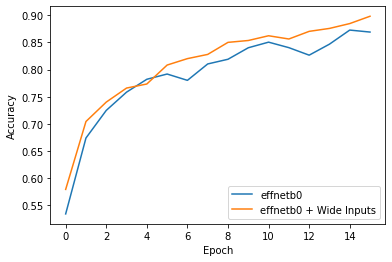

In [ ]:
plt.plot(history_ShuffleNet.history['accuracy'])
plt.plot(history_shuffleNet_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

## Results Graphs Comparison

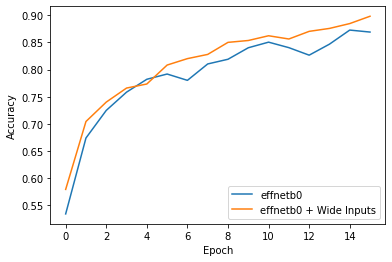

In [ ]:
plt.plot(history_ShuffleNet.history['accuracy'])
plt.plot(history_shuffleNet_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

# **SqueezeNet Test 2**

64 Batch Size, Adam Optimizer
BatchNormalization + 50% DropOut
- No performance difference exist.

Source: https://github.com/chasingbob/squeezenet-keras/blob/master/model.py

In [ ]:
batch_size = 64
optimizer = "Adam"
epochs = 20

## Model Definition

In [ ]:
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs #https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
from tensorflow.keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture."""
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    input_shape = input_shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

        #x = Dense(10, activation= 'softmax')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model

## DL only
accuracy: 0.9609

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image


In [ ]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                )

3047424/3032184 [==============================] - 0s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 squeezenet (Functional)     (None, 512)               722496    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 729,674
Trainable params: 728,650
Non-trainable 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 73s 215ms/step - loss: 0.8245 - accuracy: 0.7141 - val_loss: 0.8786 - val_accuracy: 0.7050
Epoch 2/20
338/338 [==============================] - 73s 215ms/step - loss: 0.4837 - accuracy: 0.8391 - val_loss: 0.8870 - val_accuracy: 0.7491
Epoch 3/20
338/338 [==============================] - 72s 212ms/step - loss: 0.3947 - accuracy: 0.8667 - val_loss: 0.5475 - val_accuracy: 0.8120
Epoch 4/20
338/338 [==============================] - 71s 210ms/step - loss: 0.3512 - accuracy: 0.8813 - val_loss: 1.1316 - val_accuracy: 0.7113
Epoch 5/20
338/338 [==============================] - 72s 212ms/step - loss: 0.3283 - accuracy: 0.8883 - val_loss: 0.7630 - val_accuracy: 0.7850
Epoch 6/20
338/338 [==============================] - 71s 212ms/step - loss: 0.2771 - accuracy: 0.9060 - val_loss: 0.4439 - val_accuracy: 0.8524
Epoch 7/20
338/338 [==============================] - 72s 213ms/step - loss: 0.2684 - accuracy: 0.9100 - val_loss: 0.6827 - val_accuracy: 0.8

## Wide:

accuracy: *

In [ ]:
SqueezeNetwide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'avg', classes=10)

merged_deep = base_model(wideInputD, training=False)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.5)(merged_out)
# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

SqueezeNetwide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

SqueezeNetwide_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


3047424/3032184 [==============================] - 0s 0us/step


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Widemodel  = SqueezeNetwide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = batch_size
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 50s 146ms/step - loss: 0.8225 - accuracy: 0.7095 - val_loss: 0.9700 - val_accuracy: 0.6735
Epoch 2/20
205/338 [=================>............] - ETA: 23s - loss: 0.5021 - accuracy: 0.8260

KeyboardInterrupt: ignored

## Results Graphs Comparison

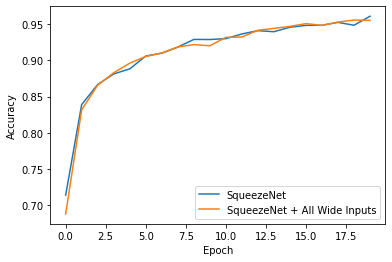

In [ ]:
#plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Widemodel.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

# **SqueezeNet Test 3**

Wide Parameter **%0.7** better!

Source: https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=M3G-2aUBQJ-H

In [ ]:
batch_size = 32
epochs = 20

## DL Only

In [ ]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=input_shape)

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)
y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(y)

SqueezeNet_model = tf.keras.Model(x, y)

SqueezeNet_model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

#SqueezeNet_model.summary()

In [ ]:
history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = 64
                                )

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 408s 1s/step - loss: 0.9349 - accuracy: 0.6801 - val_loss: 0.8795 - val_accuracy: 0.6820
Epoch 2/20
338/338 [==============================] - 253s 747ms/step - loss: 0.6176 - accuracy: 0.7872 - val_loss: 0.8109 - val_accuracy: 0.7256
Epoch 3/20
338/338 [==============================] - 221s 655ms/step - loss: 0.5146 - accuracy: 0.8269 - val_loss: 0.7755 - val_accuracy: 0.7311
Epoch 4/20
338/338 [==============================] - 209s 617ms/step - loss: 0.4537 - accuracy: 0.8471 - val_loss: 1.0276 - val_accuracy: 0.6669
Epoch 5/20
338/338 [==============================] - 215s 637ms/step - loss: 0.3682 - accuracy: 0.8760 - val_loss: 0.4782 - val_accuracy: 0.8356
Epoch 6/20
338/338 [==============================] - 208s 614ms/step - loss: 0.3358 - accuracy: 0.8876 - val_loss: 0.5920 - val_accuracy: 0.8115
Epoch 7/20
338/338 [==============================] - 205s 607ms/step - loss: 0.3002 - accuracy: 0.8994 - val_loss: 0.8914 - val_accuracy:

## With wide features:

In [ ]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

#Deep Inputs
x = tf.keras.layers.Input(shape=input_shape)
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Model design:
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])

y = layers.Concatenate(axis=1)([merged_wide, y])
y = BatchNormalization()(y)
y = Dropout(0.2)(y)
y = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(y)

SqueezeNet_Wide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     x],  outputs=y)
SqueezeNet_Wide_model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Wide_model = SqueezeNet_Wide_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size
                                                      #callbacks = [reduce_lr]
                                                      )


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


675/675 [==============================] - 258s 382ms/step - loss: 0.9826 - accuracy: 0.6612 - val_loss: 1.9205 - val_accuracy: 0.4122
Epoch 2/20
675/675 [==============================] - 259s 383ms/step - loss: 0.6420 - accuracy: 0.7773 - val_loss: 6.4157 - val_accuracy: 0.0946
Epoch 3/20
675/675 [==============================] - 258s 382ms/step - loss: 0.5200 - accuracy: 0.8197 - val_loss: 3.8020 - val_accuracy: 0.2046
Epoch 4/20
675/675 [==============================] - 257s 381ms/step - loss: 0.4253 - accuracy: 0.8581 - val_loss: 2.6478 - val_accuracy: 0.3741
Epoch 5/20
675/675 [==============================] - 252s 374ms/step - loss: 0.3665 - accuracy: 0.8748 - val_loss: 2.5548 - val_accuracy: 0.3713
Epoch 6/20
675/675 [==============================] - 253s 375ms/step - loss: 0.3105 - accuracy: 0.8929 - val_loss: 2.3776 - val_accuracy: 0.3926
Epoch 7/20
675/675 [==============================] - 253s 374ms/step - loss: 0.2790 - accuracy: 0.9050 - val_loss: 2.1897 - val_accura

### Results Graphs Comparison

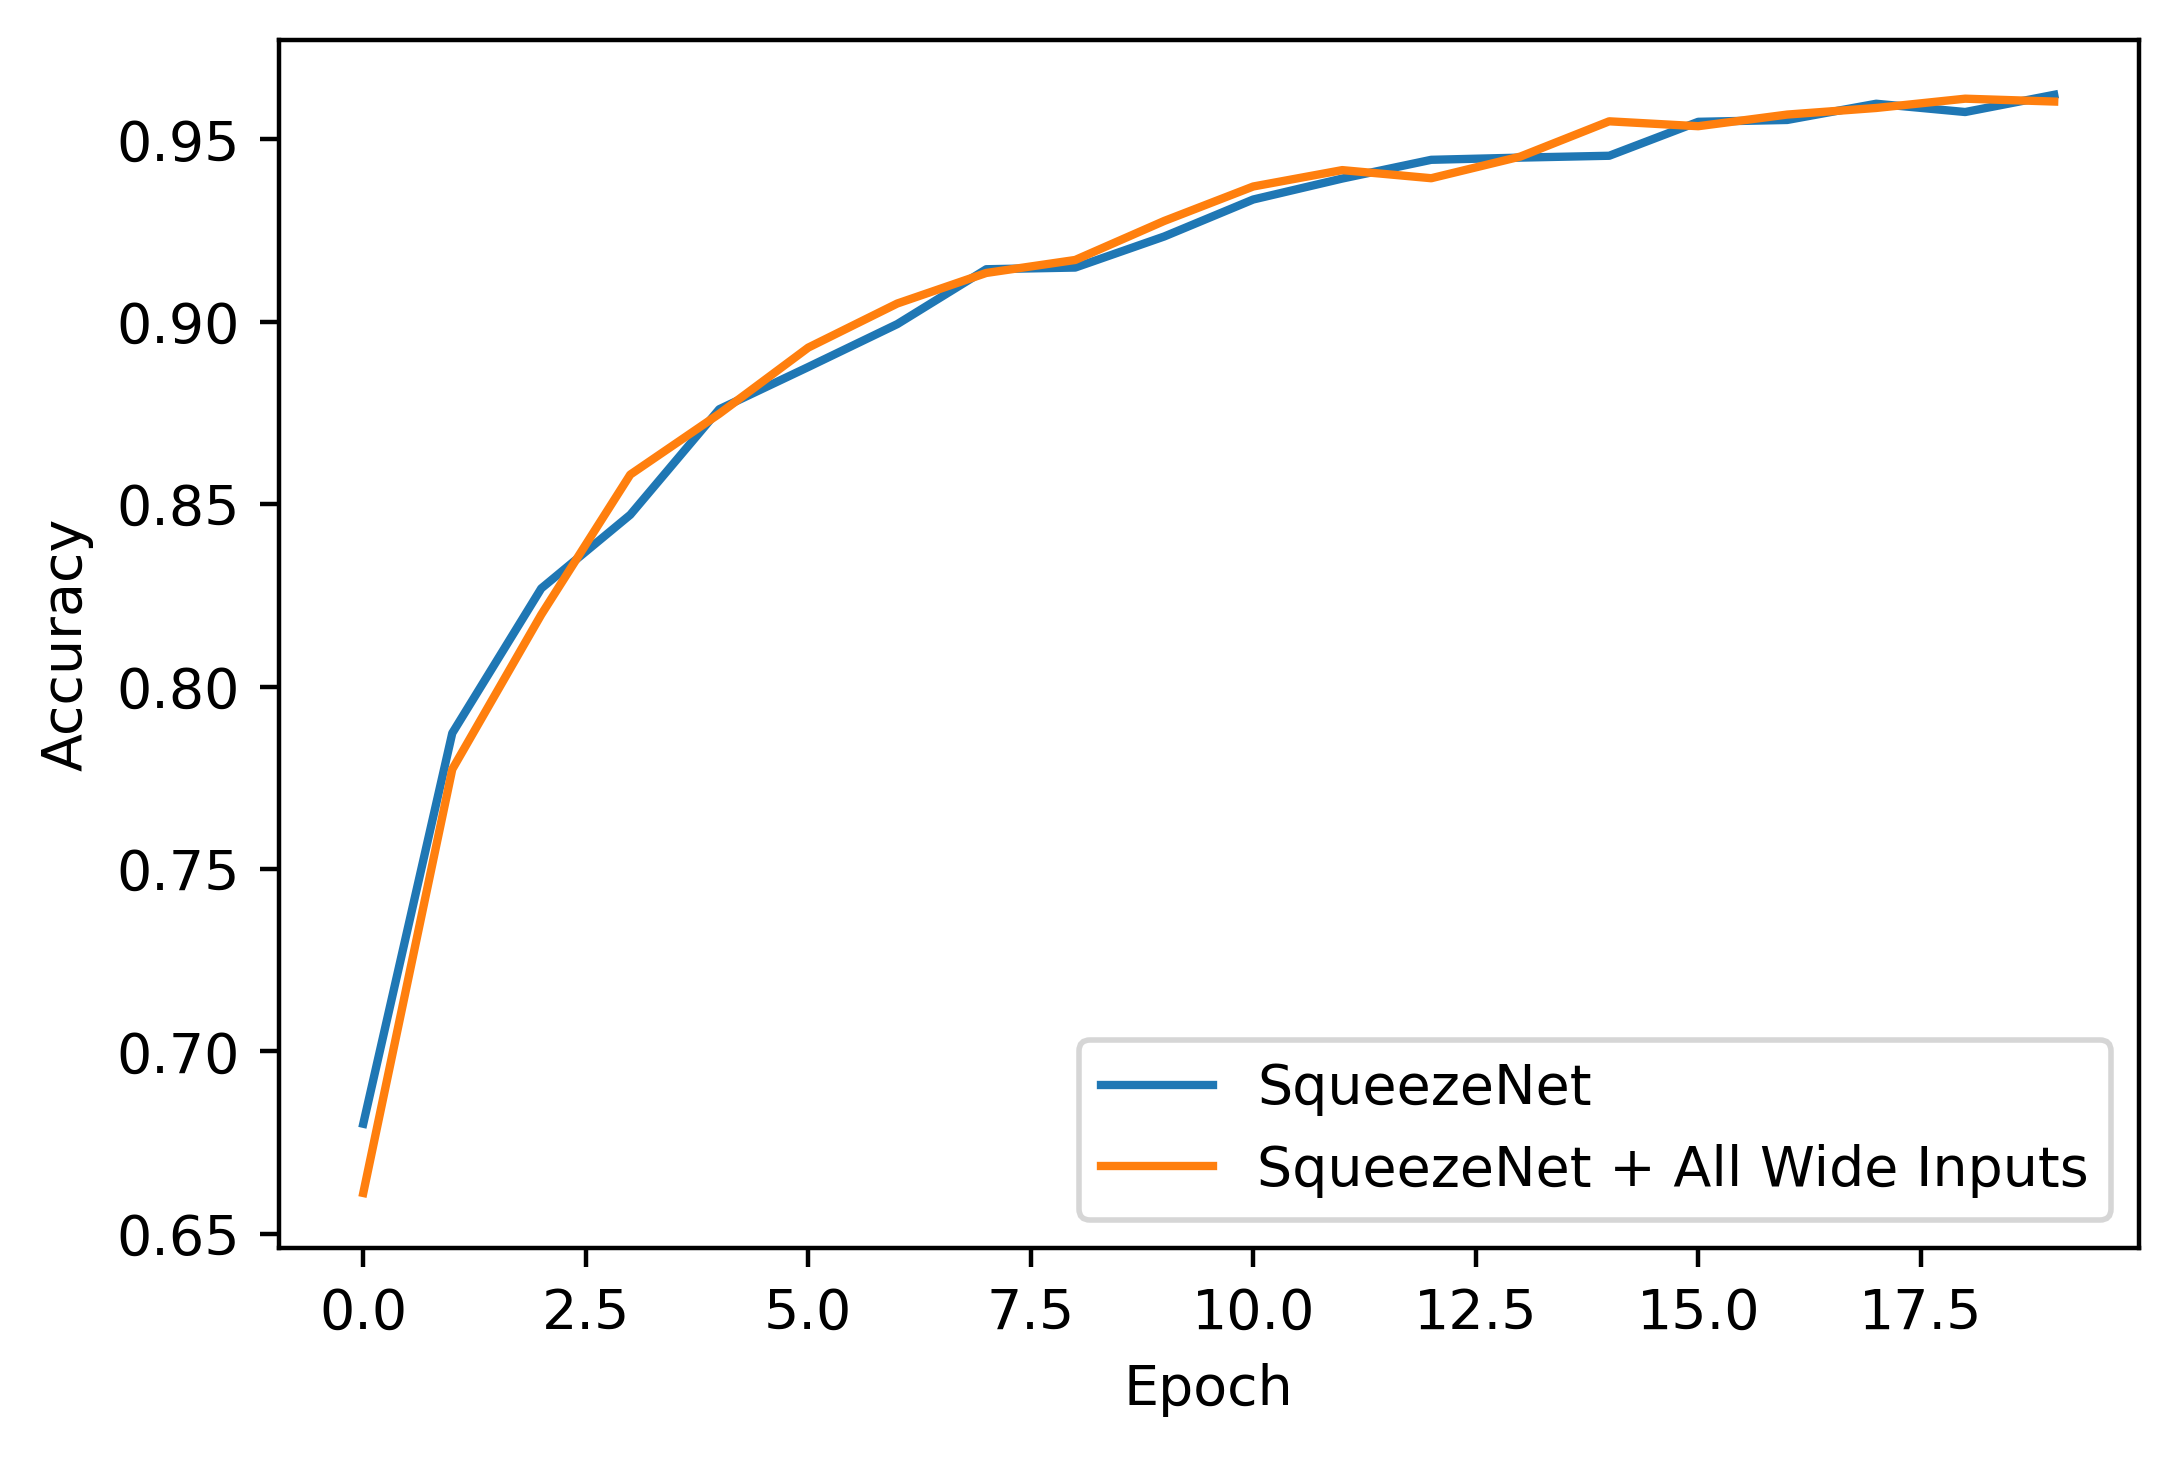

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Wide_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

----------------------------------
# **MAY 15 TESTS**
----------------------------------




# **RESNET50V2**

%1 Performance Increase is obtained!

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import ModelCheckpoint
batch_size = 64
optimizer = "Adam"
epochs = 16
import time

## DL Only

In [ ]:
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape = (input_shape), pooling = 'max', classes=10)
base_model.trainable = False
inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

resnet_model = Model(inputs = inputs, outputs = predictions)
resnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

resnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,593,482
Trainable params: 24,586
Non-trainable params: 23,568,896
_________________________________________________________________


In [ ]:
start_time = time.time()
history_resnet_model = resnet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                shuffle=True,
                                batch_size=batch_size
                                )
print("--- %s seconds ---" % (time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 73s 215ms/step - loss: 1.3741 - accuracy: 0.5400 - val_loss: 1.2171 - val_accuracy: 0.6011
Epoch 2/16
338/338 [==============================] - 75s 222ms/step - loss: 1.0633 - accuracy: 0.6376 - val_loss: 1.1000 - val_accuracy: 0.6296
Epoch 3/16
338/338 [==============================] - 95s 281ms/step - loss: 0.9895 - accuracy: 0.6604 - val_loss: 1.0963 - val_accuracy: 0.6356
Epoch 4/16
338/338 [==============================] - 88s 261ms/step - loss: 0.9519 - accuracy: 0.6687 - val_loss: 1.1055 - val_accuracy: 0.6357
Epoch 5/16
338/338 [==============================] - 118s 348ms/step - loss: 0.9243 - accuracy: 0.6781 - val_loss: 1.1208 - val_accuracy: 0.6337
Epoch 6/16
338/338 [==============================] - 94s 279ms/step - loss: 0.9023 - accuracy: 0.6849 - val_loss: 1.1322 - val_accuracy: 0.6350
Epoch 7/16
338/338 [==============================] - 74s 220ms/step - loss: 0.8968 - accuracy: 0.6878 - val_loss: 1.1661 - val_a

In [ ]:
resnet_model.save("resnet_model.h5")

## with ALL wide inputs:


In [ ]:
resnet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape = (input_shape), pooling = 'max', classes=10)
base_model.trainable = False
merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

resnet_WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

resnet_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

resnet_WIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

mcp_save = ModelCheckpoint('/drive/MyDrive/EnetB0_wide_TL.h5', save_best_only=True, monitor='val_acc')
start_time = time.time()
history_effnetb0_WIDE_model = resnet_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      callbacks=[mcp_save],
                                                      shuffle=True
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 66s 196ms/step - loss: 1.5515 - accuracy: 0.5057 - val_loss: 1.3121 - val_accuracy: 0.5720
Epoch 2/16
338/338 [==============================] - 53s 157ms/step - loss: 1.2546 - accuracy: 0.5876 - val_loss: 1.2020 - val_accuracy: 0.5994
Epoch 3/16
338/338 [==============================] - 53s 156ms/step - loss: 1.1653 - accuracy: 0.6128 - val_loss: 1.1540 - val_accuracy: 0.6094
Epoch 4/16
338/338 [==============================] - 50s 149ms/step - loss: 1.1128 - accuracy: 0.6287 - val_loss: 1.1278 - val_accuracy: 0.6172
Epoch 5/16
338/338 [==============================] - 53s 158ms/step - loss: 1.0758 - accuracy: 0.6384 - val_loss: 1.1045 - val_accuracy: 0.6265
Epoch 6/16
338/338 [==============================] - 49s 145ms/step - loss: 1.0480 - accuracy: 0.6459 - val_loss: 1.0982 - val_accuracy: 0.6241
Epoch 7/16
338/338 [==============================] - 53s 156ms/step - loss: 1.0249 - accuracy: 0.6525 - val_loss: 1.0803 - val_ac

In [ ]:
resnet_WIDE_model.save("resnet_WIDE_model.h5
")

## with SOME wide inputs:


In [ ]:
resnet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
#wideInputHU = layers.Input(shape=(7,))
#wideInputHOG = layers.Input(shape=(64,))
#wideInputLPB = layers.Input(shape=(64,))
#wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape = (input_shape), pooling = 'max', classes=10)
base_model.trainable = False
merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                   wideInputInvariantRed,
                                                   wideInputInvariantGreen,
                                                   wideInputInvariantBlue, 
                                                   # wideInputHU,
                                                   # wideInputHOG,
                                                   # wideInputLPB,
                                                   # wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

resnet_WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                    wideInputInvariantRed,
                                    wideInputInvariantGreen,
                                    wideInputInvariantBlue, 
                                    # wideInputHU,
                                     #wideInputHOG,
                                    # wideInputLPB,
                                    # wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

resnet_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

resnet_WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                       # x_train_HU,
                       ## x_train_hog_vector,
                        #x_train_lbp_vector,
                        #x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                     x_test_invariant_Blue,
                      #x_test_HU,
                     # x_test_hog_vector,
                     # x_test_lbp_vector,
                    #  x_test_glcm,
                      x_test
                      ]

start_time = time.time()
history_effnetb0_WIDE_model = resnet_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      shuffle=True
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 71s 210ms/step - loss: 1.5457 - accuracy: 0.5044 - val_loss: 1.3270 - val_accuracy: 0.5713
Epoch 2/16
338/338 [==============================] - 59s 175ms/step - loss: 1.2514 - accuracy: 0.5868 - val_loss: 1.2142 - val_accuracy: 0.6052
Epoch 3/16
338/338 [==============================] - 47s 140ms/step - loss: 1.1640 - accuracy: 0.6112 - val_loss: 1.1595 - val_accuracy: 0.6120
Epoch 4/16
338/338 [==============================] - 48s 142ms/step - loss: 1.1135 - accuracy: 0.6286 - val_loss: 1.1252 - val_accuracy: 0.6237
Epoch 5/16
338/338 [==============================] - 47s 140ms/step - loss: 1.0768 - accuracy: 0.6359 - val_loss: 1.1019 - val_accuracy: 0.6285
Epoch 6/16
338/338 [==============================] - 52s 154ms/step - loss: 1.0491 - accuracy: 0.6474 - val_loss: 1.0860 - val_accuracy: 0.6370
Epoch 7/16
338/338 [==============================] - 52s 154ms/step - loss: 1.0271 - accuracy: 0.6530 - val_loss: 1.0740 - val_ac

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
start_time = time.time()
ypred = resnet_WIDE_model.predict(GLCMdata_valMerged, verbose=1)
#ypred = MobileNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 23s 137ms/step
--- 41.29121923446655 seconds ---


### Results Graphs Comparison

In [ ]:
plt.figure(figsize=(8, 5), dpi=400)
plt.plot(history_effnetb0_model.history['accuracy'])
plt.plot(history_effnetb0_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

In [ ]:
import time

## Results Graphs Comparison

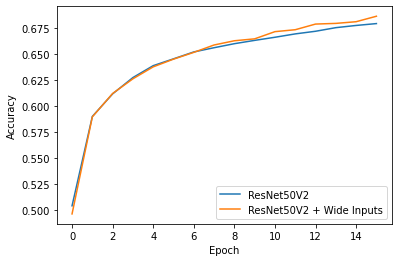

In [ ]:
plt.plot(history_resnet_model.history['accuracy'])
plt.plot(history_effnetb0_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50V2', 'ResNet50V2 + Wide Inputs'], loc='lower right')




# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
batch_size = 64
optimizer = "Adam"
epochs = 16
import time

## with wide inputs:


In [ ]:
resnet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape = (input_shape), pooling = 'max', classes=10)
base_model.trainable = False
merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

VGG16_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

VGG16_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 64)]         0           []                               
                           

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

start_time = time.time()
history_VGG16_model = VGG16_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      shuffle=True
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 35s 99ms/step - loss: 1.3877 - accuracy: 0.5621 - val_loss: 1.0694 - val_accuracy: 0.7013
Epoch 2/16
338/338 [==============================] - 32s 95ms/step - loss: 0.9724 - accuracy: 0.7010 - val_loss: 0.9290 - val_accuracy: 0.6878
Epoch 3/16
338/338 [==============================] - 31s 91ms/step - loss: 0.8581 - accuracy: 0.7290 - val_loss: 0.8338 - val_accuracy: 0.7372
Epoch 4/16
338/338 [==============================] - 33s 99ms/step - loss: 0.7949 - accuracy: 0.7467 - val_loss: 0.7826 - val_accuracy: 0.7544
Epoch 5/16
338/338 [==============================] - 32s 94ms/step - loss: 0.7541 - accuracy: 0.7544 - val_loss: 0.7481 - val_accuracy: 0.7567
Epoch 6/16
338/338 [==============================] - 31s 91ms/step - loss: 0.7241 - accuracy: 0.7647 - val_loss: 0.7223 - val_accuracy: 0.7667
Epoch 7/16
338/338 [==============================] - 31s 91ms/step - loss: 0.6990 - accuracy: 0.7714 - val_loss: 0.7077 - val_accuracy:

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
start_time = time.time()
ypred = VGG16_model.predict(GLCMdata_valMerged, verbose=1)
#ypred = MobileNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

  4/169 [..............................] - ETA: 2s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 3s 17ms/step
--- 3.058641195297241 seconds ---


### Results Graphs Comparison

In [ ]:
plt.figure(figsize=(8, 5), dpi=400)
plt.plot(history_effnetb0_model.history['accuracy'])
plt.plot(history_effnetb0_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

In [ ]:
import time

# **SqueezeNet Test 4**

64 Batch Size, Adam Optimizer
BatchNormalization,
Max Pooling


**8% PERFORMANCE INCREASE** is obtained.


Source: https://github.com/chasingbob/squeezenet-keras/blob/master/model.py

In [40]:
batch_size = 64
optimizer = "Adam"
epochs = 16

## Model Definition

In [23]:
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs #https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
from tensorflow.keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture."""
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    input_shape = input_shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

        #x = Dense(10, activation= 'softmax')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model

## DL only
accuracy: 0.6988

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image


In [ ]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'max', classes=10)
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                )

3047424/3032184 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 squeezenet (Functional)     (None, 512)               722496    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 729,674
Trainable params: 6,154
Non-trainable params: 723,520
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
120/338 [=========>....................] - ETA: 15s - loss: 1.4704 - accuracy: 0.4904

KeyboardInterrupt: ignored

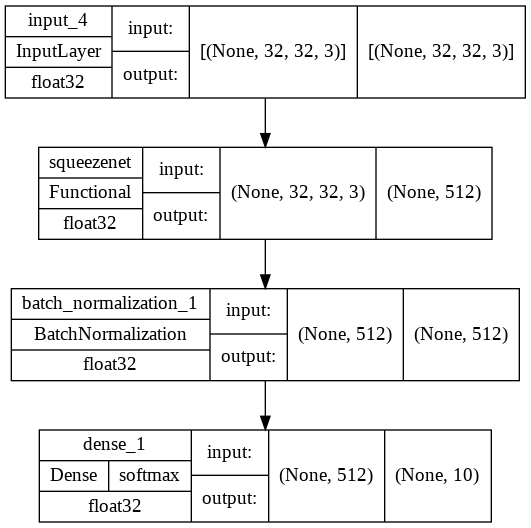

## Wide:

accuracy: 0.7754

In [ ]:
SqueezeNetwide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'max', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
merged_out = BatchNormalization()(merged_out)

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

SqueezeNetwide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

SqueezeNetwide_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


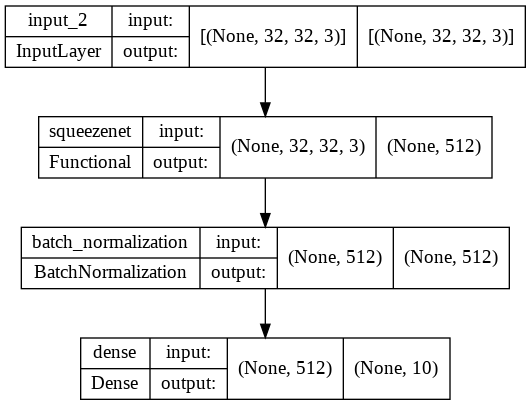

In [ ]:
tf.keras.utils.plot_model(SqueezeNet_model, show_shapes=True)

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]
                      
start_time = time.time()
history_SqueezeNet_Widemodel  = SqueezeNetwide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = batch_size
                                            )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 45s 129ms/step - loss: 1.1286 - accuracy: 0.6135 - val_loss: 1.3689 - val_accuracy: 0.5276
Epoch 2/16
338/338 [==============================] - 49s 145ms/step - loss: 0.8330 - accuracy: 0.7179 - val_loss: 1.5407 - val_accuracy: 0.4815
Epoch 3/16
338/338 [==============================] - 45s 133ms/step - loss: 0.7620 - accuracy: 0.7344 - val_loss: 1.6369 - val_accuracy: 0.4791
Epoch 4/16
338/338 [==============================] - 43s 129ms/step - loss: 0.7272 - accuracy: 0.7443 - val_loss: 1.4901 - val_accuracy: 0.5180
Epoch 5/16
338/338 [==============================] - 29s 85ms/step - loss: 0.7071 - accuracy: 0.7533 - val_loss: 1.4266 - val_accuracy: 0.5270
Epoch 6/16
338/338 [==============================] - 30s 89ms/step - loss: 0.6897 - accuracy: 0.7562 - val_loss: 1.3590 - val_accuracy: 0.5520
Epoch 7/16
338/338 [==============================] - 28s 84ms/step - loss: 0.6826 - accuracy: 0.7630 - val_loss: 1.3862 - val_accur

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
start_time = time.time()
ypred = SqueezeNetwide_model.predict(GLCMdata_valMerged, verbose=1)
#ypred = MobileNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

  4/169 [..............................] - ETA: 3s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 4s 21ms/step
--- 5.229204177856445 seconds ---


## Results Graphs Comparison

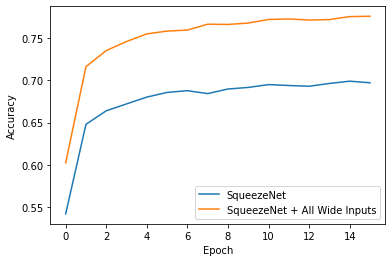

In [ ]:
#plt.figure(figsize=(6, 4), dpi=400)
plt.plot(history_SqueezeNet_model.history['accuracy'])
plt.plot(history_SqueezeNet_Widemodel.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SqueezeNet', 'SqueezeNet + All Wide Inputs',], loc='lower right')

#**SqueezeNet Test 5**
Different Test Train Size 60% 40% Train and Test

In [102]:
batch_size = 64
optimizer = "Adam"
epochs = 16

## DL only
accuracy: 0.6928

In [100]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image


In [101]:
base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'max', classes=10)
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

SqueezeNet_model = Model(inputs = inputs, outputs = predictions)

SqueezeNet_model.summary()

SqueezeNet_model.compile(
  optimizer= optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

history_SqueezeNet_model = SqueezeNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 squeezenet (Functional)     (None, 512)               722496    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 729,674
Trainable params: 6,154
Non-trainable params: 723,520
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


296/296 [==============================] - 21s 72ms/step - loss: 1.2536 - accuracy: 0.5541 - val_loss: 1.3248 - val_accuracy: 0.5384
Epoch 2/20
296/296 [==============================] - 21s 72ms/step - loss: 1.0025 - accuracy: 0.6456 - val_loss: 0.9853 - val_accuracy: 0.6591
Epoch 3/20
296/296 [==============================] - 19s 66ms/step - loss: 0.9496 - accuracy: 0.6628 - val_loss: 0.9254 - val_accuracy: 0.6770
Epoch 4/20
296/296 [==============================] - 20s 66ms/step - loss: 0.9235 - accuracy: 0.6737 - val_loss: 0.9094 - val_accuracy: 0.6760
Epoch 5/20
296/296 [==============================] - 21s 73ms/step - loss: 0.9057 - accuracy: 0.6796 - val_loss: 0.8922 - val_accuracy: 0.6794
Epoch 6/20
296/296 [==============================] - 19s 65ms/step - loss: 0.8919 - accuracy: 0.6854 - val_loss: 0.8838 - val_accuracy: 0.6798
Epoch 7/20
296/296 [==============================] - 19s 65ms/step - loss: 0.8819 - accuracy: 0.6874 - val_loss: 0.8790 - val_accuracy: 0.6868
Epo

KeyboardInterrupt: ignored

## Wide:

accuracy: 0.7736

In [103]:
SqueezeNetwide_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = SqueezeNet(weights="imagenet", input_shape=input_shape, include_top=False, pooling = 'max', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
merged_out = BatchNormalization()(merged_out)

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

SqueezeNetwide_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

SqueezeNetwide_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_SqueezeNet_Widemodel  = SqueezeNetwide_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            batch_size = batch_size
                                            )

Epoch 1/16
296/296 [==============================] - 20s 69ms/step - loss: 1.1892 - accuracy: 0.5952 - val_loss: 1.3102 - val_accuracy: 0.5541
Epoch 2/16
296/296 [==============================] - 20s 69ms/step - loss: 0.8529 - accuracy: 0.7155 - val_loss: 1.2522 - val_accuracy: 0.5502
Epoch 3/16
296/296 [==============================] - 20s 69ms/step - loss: 0.7760 - accuracy: 0.7328 - val_loss: 1.6897 - val_accuracy: 0.5040
Epoch 4/16
296/296 [==============================] - 21s 70ms/step - loss: 0.7332 - accuracy: 0.7478 - val_loss: 1.5437 - val_accuracy: 0.5259
Epoch 5/16
296/296 [==============================] - 20s 69ms/step - loss: 0.7104 - accuracy: 0.7519 - val_loss: 1.3588 - val_accuracy: 0.5677
Epoch 6/16
296/296 [==============================] - 20s 68ms/step - loss: 0.6955 - accuracy: 0.7590 - val_loss: 1.2852 - val_accuracy: 0.5828
Epoch 7/16
 73/296 [======>.......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.7648

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
start_time = time.time()
#ypred = SqueezeNetwide_model.predict(GLCMdata_valMerged, verbose=1)
ypred = SqueezeNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

# **ShuffleNet**

64 Batch Size, Adam Optimizer
BatchNormalization

Wide Inputs increase accuracy up to **4%!**

Source: https://github.com/scheckmedia/keras-shufflenet

In [ ]:
batch_size = 64
optimizer = "Adam"
epochs = 16
import time

## Model Definition
Source code: https://github.com/opconty/keras-shufflenetV2/blob/master/shufflenetv2.py


In [ ]:

from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K



import os
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np


def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(32,32,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=131):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = input_shape
  
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    inputs = img_input
    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

## DL Only

In [ ]:
start = time.time()
base_model = ShuffleNetV2(include_top=False, input_shape= (input_shape), pooling = 'max', classes=10)

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

ShuffleNet_model = Model(inputs = inputs, outputs = predictions)

ShuffleNet_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

history_ShuffleNet = ShuffleNet_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                              )
end = time.time()
print(end - start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 135s 361ms/step - loss: 1.2286 - accuracy: 0.5800 - val_loss: 2.5717 - val_accuracy: 0.0887
Epoch 2/16
338/338 [==============================] - 133s 393ms/step - loss: 0.8165 - accuracy: 0.7111 - val_loss: 2.0809 - val_accuracy: 0.2728
Epoch 3/16
338/338 [==============================] - 85s 252ms/step - loss: 0.7055 - accuracy: 0.7495 - val_loss: 1.3100 - val_accuracy: 0.5785
Epoch 4/16
338/338 [==============================] - 81s 238ms/step - loss: 0.6418 - accuracy: 0.7732 - val_loss: 2.4827 - val_accuracy: 0.4252
Epoch 5/16
338/338 [==============================] - 85s 251ms/step - loss: 0.6215 - accuracy: 0.7875 - val_loss: 2.5474 - val_accuracy: 0.3887
Epoch 6/16
338/338 [==============================] - 80s 238ms/step - loss: 0.6216 - accuracy: 0.7837 - val_loss: 1.1251 - val_accuracy: 0.6556
Epoch 7/16
338/338 [==============================] - 83s 246ms/step - loss: 0.6197 - accuracy: 0.7898 - val_loss: 3.2459 - val_

In [ ]:
ShuffleNet_model.save('ShuffleNet_model.h5')

In [ ]:
# Prediction Step:
import pandas as pd

start_time = time.time()
#ypred = SqueezeNetwide_model.predict(GLCMdata_valMerged, verbose=1)
ypred = ShuffleNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 21s 124ms/step
--- 41.190539836883545 seconds ---


## with wide inputs:


In [ ]:
shuffleNet_WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = ShuffleNetV2(include_top=False, input_shape= (input_shape), pooling = 'max', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.5)(merged_out)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

shuffleNet_WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

shuffleNet_WIDE_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

shuffleNet_WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

#mcp_save = ModelCheckpoint('/drive/MyDrive/EnetB0_wide_TL.h5', save_best_only=True, monitor='val_acc')

history_shuffleNet_WIDE_model = shuffleNet_WIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      #callbacks=[mcp_save],
                                                      shuffle=True
                                                      )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 103s 304ms/step - loss: 2.0699 - accuracy: 0.2561 - val_loss: 2.2753 - val_accuracy: 0.1133
Epoch 2/16
338/338 [==============================] - 97s 286ms/step - loss: 1.7843 - accuracy: 0.3784 - val_loss: 4.0528 - val_accuracy: 0.1102
Epoch 3/16
338/338 [==============================] - 100s 297ms/step - loss: 1.6768 - accuracy: 0.4156 - val_loss: 4.6657 - val_accuracy: 0.1319
Epoch 4/16
338/338 [==============================] - 133s 394ms/step - loss: 1.6405 - accuracy: 0.4250 - val_loss: 3.9004 - val_accuracy: 0.2061
Epoch 5/16
338/338 [==============================] - 85s 251ms/step - loss: 1.6038 - accuracy: 0.4348 - val_loss: 3.4228 - val_accuracy: 0.1922
Epoch 6/16
338/338 [==============================] - 63s 186ms/step - loss: 1.5875 - accuracy: 0.4436 - val_loss: 3.0015 - val_accuracy: 0.2974
Epoch 7/16
338/338 [==============================] - 60s 178ms/step - loss: 1.5746 - accuracy: 0.4493 - val_loss: 3.2186 - val

In [ ]:
# Prediction Step:
import pandas as pd

start_time = time.time()
ypred = shuffleNet_WIDE_model.predict(GLCMdata_valMerged, verbose=1)
# ypred = shuffleNet_WIDE_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 33s 196ms/step
--- 41.20119309425354 seconds ---


In [ ]:
shuffleNet_WIDE_model.save("shuffleNet_WIDE_model.h5")

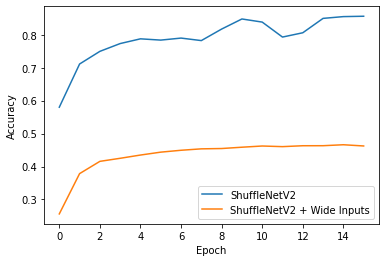

In [ ]:
plt.plot(history_ShuffleNet.history['accuracy'])
plt.plot(history_shuffleNet_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ShuffleNetV2', 'ShuffleNetV2 + Wide Inputs'], loc='lower right')

## Results Graphs Comparison

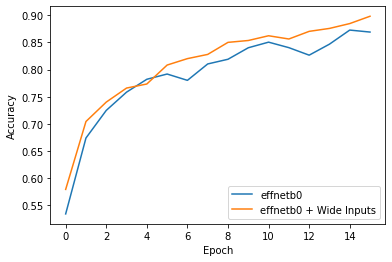

In [ ]:
plt.plot(history_ShuffleNet.history['accuracy'])
plt.plot(history_shuffleNet_WIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['effnetb0', 'effnetb0 + Wide Inputs'], loc='lower right')

# **MobileNetV2**


In [ ]:
from tensorflow.keras.applications import MobileNetV2

## 1st Experiment:
With Max Pooling

1percent performance increase!

### MobileNet DL Only

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape), pooling = 'max', classes=10)
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNet_model = Model(inputs = inputs, outputs = predictions)

MobileNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNet_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization_6 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,275,914
Trainable params: 15,370
Non-trainable params: 2,260,544
_________________________________________________________________


In [ ]:
start_time = time.time()
history_MobileNetV2 = MobileNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size=batch_size,
                                #callbacks=[reduce_lr]
                                )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 130s 384ms/step - loss: 1.5857 - accuracy: 0.4825 - val_loss: 1.3682 - val_accuracy: 0.5519
Epoch 2/16
338/338 [==============================] - 94s 279ms/step - loss: 1.2259 - accuracy: 0.5695 - val_loss: 1.2063 - val_accuracy: 0.5909
Epoch 3/16
338/338 [==============================] - 83s 247ms/step - loss: 1.1653 - accuracy: 0.5824 - val_loss: 1.1854 - val_accuracy: 0.5911
Epoch 4/16
338/338 [==============================] - 86s 253ms/step - loss: 1.1415 - accuracy: 0.5888 - val_loss: 1.1834 - val_accuracy: 0.5900
Epoch 5/16
338/338 [==============================] - 82s 243ms/step - loss: 1.1278 - accuracy: 0.5908 - val_loss: 1.1758 - val_accuracy: 0.5943
Epoch 6/16
338/338 [==============================] - 82s 241ms/step - loss: 1.1250 - accuracy: 0.5934 - val_loss: 1.1761 - val_accuracy: 0.5963
Epoch 7/16
338/338 [==============================] - 86s 253ms/step - loss: 1.1210 - accuracy: 0.5947 - val_loss: 1.1799 - val_a

### MobileNet with wide inputs:

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape), pooling = 'max', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD)
merged_deep= BatchNormalization()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]
start_time = time.time()
history_MobileNetWIDE_model = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      #callbacks = [reduce_lr]
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
338/338 [==============================] - 58s 173ms/step - loss: 1.5888 - accuracy: 0.4787 - val_loss: 1.3763 - val_accuracy: 0.5430
Epoch 2/16
338/338 [==============================] - 61s 180ms/step - loss: 1.2208 - accuracy: 0.5717 - val_loss: 1.2131 - val_accuracy: 0.5776
Epoch 3/16
338/338 [==============================] - 61s 179ms/step - loss: 1.1558 - accuracy: 0.5860 - val_loss: 1.1856 - val_accuracy: 0.5956
Epoch 4/16
338/338 [==============================] - 61s 180ms/step - loss: 1.1357 - accuracy: 0.5899 - val_loss: 1.1713 - val_accuracy: 0.5985
Epoch 5/16
338/338 [==============================] - 61s 179ms/step - loss: 1.1244 - accuracy: 0.5910 - val_loss: 1.1680 - val_accuracy: 0.6046
Epoch 6/16
338/338 [==============================] - 58s 173ms/step - loss: 1.1176 - accuracy: 0.5957 - val_loss: 1.1634 - val_accuracy: 0.6069
Epoch 7/16
338/338 [==============================] - 61s 181ms/step - loss: 1.1130 - accuracy: 0.5993 - val_loss: 1.1671 - val_ac

## Results Graphs Comparison

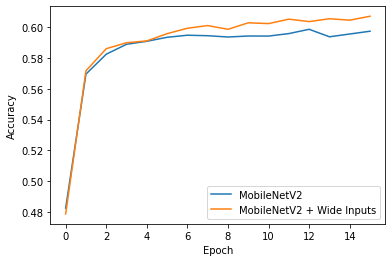

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')

## 2nd Experiment:
With Average Pooling

### MobileNet DL Only

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape), pooling = 'avg', classes=10)
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNet_model = Model(inputs = inputs, outputs = predictions)

MobileNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNet_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization_8 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,275,914
Trainable params: 15,370
Non-trainable params: 2,260,544
_________________________________________________________________


In [ ]:
start_time = time.time()
history_MobileNetV2 = MobileNet_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size=batch_size,
                                #callbacks=[reduce_lr]
                                )
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 59s 176ms/step - loss: 1.5962 - accuracy: 0.4740 - val_loss: 1.3780 - val_accuracy: 0.5589
Epoch 2/16
338/338 [==============================] - 60s 178ms/step - loss: 1.2242 - accuracy: 0.5710 - val_loss: 1.2106 - val_accuracy: 0.5781
Epoch 3/16
338/338 [==============================] - 60s 178ms/step - loss: 1.1632 - accuracy: 0.5804 - val_loss: 1.1867 - val_accuracy: 0.5915
Epoch 4/16
338/338 [==============================] - 57s 168ms/step - loss: 1.1412 - accuracy: 0.5875 - val_loss: 1.1795 - val_accuracy: 0.5943
Epoch 5/16
338/338 [==============================] - 60s 178ms/step - loss: 1.1294 - accuracy: 0.5869 - val_loss: 1.1764 - val_accuracy: 0.5961
Epoch 6/16
338/338 [==============================] - 60s 178ms/step - loss: 1.1224 - accuracy: 0.5912 - val_loss: 1.1768 - val_accuracy: 0.5950
Epoch 7/16
338/338 [==============================] - 60s 178ms/step - loss: 1.1173 - accuracy: 0.5957 - val_loss: 1.1772 - val_accuracy: 0.5

### MobileNet with wide inputs:

In [ ]:
MobileNetWIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape), pooling = 'avg', classes=10)
base_model.trainable = False

merged_deep = base_model(wideInputD)
merged_deep= BatchNormalization()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetWIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetWIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetWIDE_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]
start_time = time.time()
history_MobileNetWIDE_model = MobileNetWIDE_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size,
                                                      #callbacks = [reduce_lr]
                                                      )
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 61s 181ms/step - loss: 1.6150 - accuracy: 0.4686 - val_loss: 1.3715 - val_accuracy: 0.5561
Epoch 2/16
338/338 [==============================] - 62s 182ms/step - loss: 1.2285 - accuracy: 0.5695 - val_loss: 1.2070 - val_accuracy: 0.5883
Epoch 3/16
338/338 [==============================] - 58s 171ms/step - loss: 1.1682 - accuracy: 0.5838 - val_loss: 1.1822 - val_accuracy: 0.5961
Epoch 4/16
338/338 [==============================] - 61s 181ms/step - loss: 1.1339 - accuracy: 0.5919 - val_loss: 1.1724 - val_accuracy: 0.5969
Epoch 5/16
338/338 [==============================] - 58s 173ms/step - loss: 1.1277 - accuracy: 0.5897 - val_loss: 1.1662 - val_accuracy: 0.6030
Epoch 6/16
338/338 [==============================] - 61s 181ms/step - loss: 1.1153 - accuracy: 0.5976 - val_loss: 1.1687 - val_accuracy: 0.5980
Epoch 7/16
338/338 [==============================] - 58s 172ms/step - loss: 1.1114 - accuracy: 0.5959 - val_loss: 1.1644 - val_accuracy: 0.5

### Results Graphs Comparison

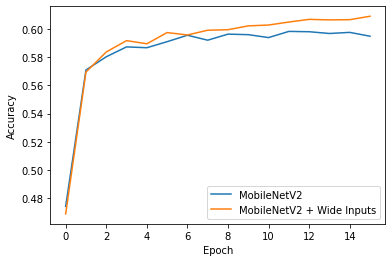

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetWIDE_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')

## classification_report


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

target_names = ['AnnualCrop',
                'Forest',
                'HerbaceousVegatation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']

In [ ]:
start_time = time.time()
ypred = MobileNetWIDE_model.predict(GLCMdata_valMerged, verbose=1)
#ypred = MobileNet_model.predict(x_test, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 31s 183ms/step
--- 31.223884105682373 seconds ---


In [ ]:
ypred = SqueezeNetwide_model.predict(GLCMdata_valMerged, verbose=1)
ypred = np.argmax(ypred, axis=1)

df = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names, digits=2,
                                        output_dict=True)).T

df['support'] = df.support.apply(int)

df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

  1/169 [..............................] - ETA: 13s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


169/169 [==============================] - 7s 40ms/step


# **Only Traditional Inputs Tests**

In [ ]:
ML_model = tf.keras.Sequential()                   
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

# Concatenate Wide + Deep Inputs
merged_out = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
# Dense Layers, Feature Selection
merged_out = BatchNormalization()(merged_out)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

ML_model = tf.keras.Model(inputs=[   wideInput0,
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM,
                                     ],  
                             outputs=merged_out)

ML_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

ML_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm
                        
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm
                      
                      ]

history_ML_model = ML_model.fit(GLCMdata_trainMerged, 
                                                      y_train,
                                                      epochs = epochs,
                                                      validation_data=(GLCMdata_valMerged, y_test),
                                                      batch_size=batch_size
                                                      )

Epoch 1/20
  1/338 [..............................] - ETA: 15s - loss: 2.3429 - accuracy: 0.0781

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


338/338 [==============================] - 9s 27ms/step - loss: 2.0136 - accuracy: 0.2817 - val_loss: 2.5572 - val_accuracy: 0.1852
Epoch 2/20
338/338 [==============================] - 9s 28ms/step - loss: 1.6422 - accuracy: 0.4477 - val_loss: 5.3930 - val_accuracy: 0.2204
Epoch 3/20
338/338 [==============================] - 9s 27ms/step - loss: 1.4752 - accuracy: 0.5104 - val_loss: 7.9480 - val_accuracy: 0.2163
Epoch 4/20
338/338 [==============================] - 9s 28ms/step - loss: 1.3927 - accuracy: 0.5363 - val_loss: 8.0458 - val_accuracy: 0.2220
Epoch 5/20
338/338 [==============================] - 10s 28ms/step - loss: 1.3461 - accuracy: 0.5477 - val_loss: 8.4868 - val_accuracy: 0.2096
Epoch 6/20
338/338 [==============================] - 9s 28ms/step - loss: 1.3164 - accuracy: 0.5541 - val_loss: 8.5745 - val_accuracy: 0.2459
Epoch 7/20
338/338 [==============================] - 9s 27ms/step - loss: 1.2888 - accuracy: 0.5623 - val_loss: 8.6222 - val_accuracy: 0.2511
Epoch 8/2

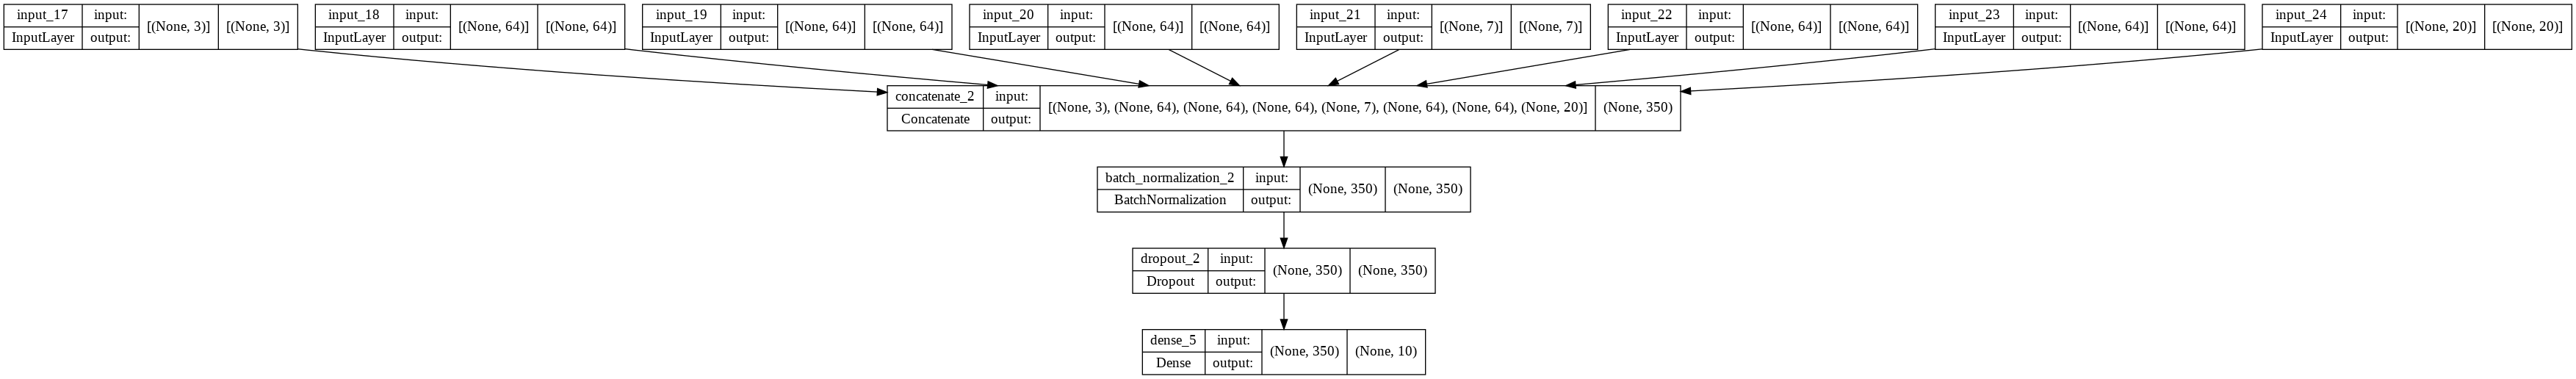

In [ ]:
plot_model(ML_model, show_shapes=True, show_layer_names=True)

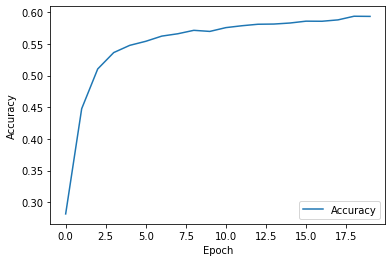

In [ ]:
plt.plot(history_ML_model.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='lower right')